In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(579548, 828)
(579548, 8)
validation
(80986, 828)
(80986, 8)
test
(68055, 828)
(68055, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/58 [..............................] - ETA: 1:38 - loss: 2.1398 - STD: 0.0531 - MAE: 0.2195

 4/58 [=>............................] - ETA: 1s - loss: 1.6207 - STD: 0.1250 - MAE: 0.1775  

 5/58 [=>............................] - ETA: 2s - loss: 1.5674 - STD: 0.1479 - MAE: 0.1674

 6/58 [==>...........................] - ETA: 2s - loss: 1.5354 - STD: 0.1646 - MAE: 0.1602

 7/58 [==>...........................] - ETA: 2s - loss: 1.5138 - STD: 0.1763 - MAE: 0.1553

 8/58 [===>..........................] - ETA: 2s - loss: 1.4947 - STD: 0.1838 - MAE: 0.1521

 9/58 [===>..........................] - ETA: 2s - loss: 1.4775 - STD: 0.1879 - MAE: 0.1501

10/58 [====>.........................] - ETA: 2s - loss: 1.4624 - STD: 0.1895 - MAE: 0.1491

11/58 [====>.........................] - ETA: 2s - loss: 1.4517 - STD: 0.1894 - MAE: 0.1489

12/58 [=====>........................] - ETA: 2s - loss: 1.4427 - STD: 0.1886 - MAE: 0.1491

13/58 [=====>........................] - ETA: 2s - loss: 1.4361 - STD: 0.1877 - MAE: 0.1494

14/58 [======>.......................] - ETA: 2s - loss: 1.4321 - STD: 0.1871 - MAE: 0.1496

15/58 [======>.......................] - ETA: 2s - loss: 1.4251 - STD: 0.1869 - MAE: 0.1495

16/58 [=======>......................] - ETA: 2s - loss: 1.4188 - STD: 0.1872 - MAE: 0.1493

17/58 [=======>......................] - ETA: 2s - loss: 1.4134 - STD: 0.1879 - MAE: 0.1489

18/58 [========>.....................] - ETA: 2s - loss: 1.4079 - STD: 0.1890 - MAE: 0.1483

19/58 [========>.....................] - ETA: 2s - loss: 1.4029 - STD: 0.1902 - MAE: 0.1477

20/58 [=========>....................] - ETA: 2s - loss: 1.3984 - STD: 0.1915 - MAE: 0.1472

21/58 [=========>....................] - ETA: 2s - loss: 1.3939 - STD: 0.1927 - MAE: 0.1466

22/58 [==========>...................] - ETA: 2s - loss: 1.3903 - STD: 0.1936 - MAE: 0.1461

23/58 [==========>...................] - ETA: 2s - loss: 1.3873 - STD: 0.1943 - MAE: 0.1458

24/58 [===========>..................] - ETA: 2s - loss: 1.3852 - STD: 0.1947 - MAE: 0.1456

25/58 [===========>..................] - ETA: 2s - loss: 1.3825 - STD: 0.1948 - MAE: 0.1456

26/58 [============>.................] - ETA: 1s - loss: 1.3800 - STD: 0.1946 - MAE: 0.1456

27/58 [============>.................] - ETA: 1s - loss: 1.3775 - STD: 0.1941 - MAE: 0.1457

28/58 [=============>................] - ETA: 1s - loss: 1.3757 - STD: 0.1935 - MAE: 0.1460

29/58 [==============>...............] - ETA: 1s - loss: 1.3740 - STD: 0.1928 - MAE: 0.1462

30/58 [==============>...............] - ETA: 1s - loss: 1.3715 - STD: 0.1921 - MAE: 0.1464

31/58 [===============>..............] - ETA: 1s - loss: 1.3696 - STD: 0.1915 - MAE: 0.1466

32/58 [===============>..............] - ETA: 1s - loss: 1.3679 - STD: 0.1910 - MAE: 0.1468

33/58 [================>.............] - ETA: 1s - loss: 1.3662 - STD: 0.1907 - MAE: 0.1468

34/58 [================>.............] - ETA: 1s - loss: 1.3637 - STD: 0.1905 - MAE: 0.1468

35/58 [=================>............] - ETA: 2s - loss: 1.3621 - STD: 0.1905 - MAE: 0.1468

38/58 [==================>...........] - ETA: 1s - loss: 1.3581 - STD: 0.1912 - MAE: 0.1465

40/58 [===================>..........] - ETA: 1s - loss: 1.3559 - STD: 0.1916 - MAE: 0.1463

41/58 [====================>.........] - ETA: 1s - loss: 1.3545 - STD: 0.1918 - MAE: 0.1462

42/58 [====================>.........] - ETA: 1s - loss: 1.3537 - STD: 0.1918 - MAE: 0.1462

43/58 [=====================>........] - ETA: 1s - loss: 1.3529 - STD: 0.1918 - MAE: 0.1462

44/58 [=====================>........] - ETA: 1s - loss: 1.3518 - STD: 0.1917 - MAE: 0.1462

45/58 [======================>.......] - ETA: 1s - loss: 1.3506 - STD: 0.1916 - MAE: 0.1462

46/58 [======================>.......] - ETA: 1s - loss: 1.3491 - STD: 0.1915 - MAE: 0.1462

47/58 [=======================>......] - ETA: 0s - loss: 1.3486 - STD: 0.1913 - MAE: 0.1463

48/58 [=======================>......] - ETA: 0s - loss: 1.3478 - STD: 0.1913 - MAE: 0.1463

49/58 [========================>.....] - ETA: 0s - loss: 1.3472 - STD: 0.1912 - MAE: 0.1463

50/58 [========================>.....] - ETA: 0s - loss: 1.3463 - STD: 0.1912 - MAE: 0.1463

51/58 [=========================>....] - ETA: 0s - loss: 1.3453 - STD: 0.1913 - MAE: 0.1462

52/58 [=========================>....] - ETA: 0s - loss: 1.3445 - STD: 0.1913 - MAE: 0.1462

53/58 [==========================>...] - ETA: 0s - loss: 1.3439 - STD: 0.1914 - MAE: 0.1461

54/58 [==========================>...] - ETA: 0s - loss: 1.3432 - STD: 0.1915 - MAE: 0.1461

55/58 [===========================>..] - ETA: 0s - loss: 1.3424 - STD: 0.1916 - MAE: 0.1460

56/58 [===========================>..] - ETA: 0s - loss: 1.3420 - STD: 0.1917 - MAE: 0.1460

57/58 [============================>.] - ETA: 0s - loss: 1.3411 - STD: 0.1917 - MAE: 0.1460

58/58 [==============================] - ETA: 0s - loss: 1.3406 - STD: 0.1918 - MAE: 0.1460

58/58 [==============================] - 7s 95ms/step - loss: 1.3406 - STD: 0.1918 - MAE: 0.1460 - val_loss: 1.2955 - val_STD: 0.1906 - val_MAE: 0.1467


Epoch 2/10000


 1/58 [..............................] - ETA: 5s - loss: 1.2816 - STD: 0.1906 - MAE: 0.1443

 2/58 [>.............................] - ETA: 4s - loss: 1.2915 - STD: 0.1900 - MAE: 0.1451

 3/58 [>.............................] - ETA: 3s - loss: 1.2978 - STD: 0.1896 - MAE: 0.1457

 4/58 [=>............................] - ETA: 3s - loss: 1.2976 - STD: 0.1892 - MAE: 0.1457

 5/58 [=>............................] - ETA: 3s - loss: 1.2974 - STD: 0.1891 - MAE: 0.1458

 6/58 [==>...........................] - ETA: 3s - loss: 1.3017 - STD: 0.1892 - MAE: 0.1460

 7/58 [==>...........................] - ETA: 3s - loss: 1.3022 - STD: 0.1893 - MAE: 0.1461

 8/58 [===>..........................] - ETA: 3s - loss: 1.3037 - STD: 0.1895 - MAE: 0.1461

 9/58 [===>..........................] - ETA: 3s - loss: 1.3052 - STD: 0.1896 - MAE: 0.1461

10/58 [====>.........................] - ETA: 3s - loss: 1.3048 - STD: 0.1897 - MAE: 0.1460

11/58 [====>.........................] - ETA: 3s - loss: 1.3029 - STD: 0.1898 - MAE: 0.1459

12/58 [=====>........................] - ETA: 3s - loss: 1.3043 - STD: 0.1899 - MAE: 0.1459

13/58 [=====>........................] - ETA: 2s - loss: 1.3035 - STD: 0.1901 - MAE: 0.1458

14/58 [======>.......................] - ETA: 2s - loss: 1.3043 - STD: 0.1903 - MAE: 0.1458

15/58 [======>.......................] - ETA: 2s - loss: 1.3047 - STD: 0.1905 - MAE: 0.1458

16/58 [=======>......................] - ETA: 2s - loss: 1.3045 - STD: 0.1906 - MAE: 0.1457

17/58 [=======>......................] - ETA: 2s - loss: 1.3040 - STD: 0.1907 - MAE: 0.1457

18/58 [========>.....................] - ETA: 2s - loss: 1.3037 - STD: 0.1907 - MAE: 0.1456

19/58 [========>.....................] - ETA: 2s - loss: 1.3032 - STD: 0.1908 - MAE: 0.1455

20/58 [=========>....................] - ETA: 2s - loss: 1.3035 - STD: 0.1909 - MAE: 0.1455

21/58 [=========>....................] - ETA: 2s - loss: 1.3029 - STD: 0.1910 - MAE: 0.1454

22/58 [==========>...................] - ETA: 2s - loss: 1.3026 - STD: 0.1911 - MAE: 0.1454

23/58 [==========>...................] - ETA: 2s - loss: 1.3026 - STD: 0.1912 - MAE: 0.1453

24/58 [===========>..................] - ETA: 2s - loss: 1.3025 - STD: 0.1913 - MAE: 0.1453

25/58 [===========>..................] - ETA: 2s - loss: 1.3014 - STD: 0.1914 - MAE: 0.1452

26/58 [============>.................] - ETA: 2s - loss: 1.3021 - STD: 0.1914 - MAE: 0.1452

27/58 [============>.................] - ETA: 2s - loss: 1.3019 - STD: 0.1915 - MAE: 0.1452

28/58 [=============>................] - ETA: 1s - loss: 1.3018 - STD: 0.1915 - MAE: 0.1452

29/58 [==============>...............] - ETA: 1s - loss: 1.3021 - STD: 0.1915 - MAE: 0.1452

30/58 [==============>...............] - ETA: 1s - loss: 1.3025 - STD: 0.1914 - MAE: 0.1453

31/58 [===============>..............] - ETA: 1s - loss: 1.3032 - STD: 0.1914 - MAE: 0.1453

32/58 [===============>..............] - ETA: 1s - loss: 1.3028 - STD: 0.1912 - MAE: 0.1454

33/58 [================>.............] - ETA: 1s - loss: 1.3025 - STD: 0.1911 - MAE: 0.1454

34/58 [================>.............] - ETA: 1s - loss: 1.3025 - STD: 0.1910 - MAE: 0.1454

35/58 [=================>............] - ETA: 1s - loss: 1.3023 - STD: 0.1909 - MAE: 0.1455

36/58 [=================>............] - ETA: 1s - loss: 1.3028 - STD: 0.1909 - MAE: 0.1455

37/58 [==================>...........] - ETA: 1s - loss: 1.3031 - STD: 0.1909 - MAE: 0.1455

38/58 [==================>...........] - ETA: 1s - loss: 1.3030 - STD: 0.1910 - MAE: 0.1455

39/58 [===================>..........] - ETA: 1s - loss: 1.3027 - STD: 0.1910 - MAE: 0.1455

40/58 [===================>..........] - ETA: 1s - loss: 1.3024 - STD: 0.1910 - MAE: 0.1454

41/58 [====================>.........] - ETA: 1s - loss: 1.3023 - STD: 0.1910 - MAE: 0.1454

42/58 [====================>.........] - ETA: 1s - loss: 1.3023 - STD: 0.1911 - MAE: 0.1454

43/58 [=====================>........] - ETA: 0s - loss: 1.3028 - STD: 0.1911 - MAE: 0.1454

44/58 [=====================>........] - ETA: 0s - loss: 1.3030 - STD: 0.1911 - MAE: 0.1454

45/58 [======================>.......] - ETA: 0s - loss: 1.3028 - STD: 0.1910 - MAE: 0.1454

46/58 [======================>.......] - ETA: 0s - loss: 1.3028 - STD: 0.1910 - MAE: 0.1454

47/58 [=======================>......] - ETA: 0s - loss: 1.3024 - STD: 0.1910 - MAE: 0.1454

48/58 [=======================>......] - ETA: 0s - loss: 1.3022 - STD: 0.1911 - MAE: 0.1454

49/58 [========================>.....] - ETA: 0s - loss: 1.3023 - STD: 0.1911 - MAE: 0.1453

50/58 [========================>.....] - ETA: 0s - loss: 1.3018 - STD: 0.1912 - MAE: 0.1453

51/58 [=========================>....] - ETA: 0s - loss: 1.3018 - STD: 0.1912 - MAE: 0.1453

52/58 [=========================>....] - ETA: 0s - loss: 1.3018 - STD: 0.1912 - MAE: 0.1453

53/58 [==========================>...] - ETA: 0s - loss: 1.3016 - STD: 0.1911 - MAE: 0.1453

54/58 [==========================>...] - ETA: 0s - loss: 1.3013 - STD: 0.1910 - MAE: 0.1453

55/58 [===========================>..] - ETA: 0s - loss: 1.3010 - STD: 0.1909 - MAE: 0.1453

56/58 [===========================>..] - ETA: 0s - loss: 1.3007 - STD: 0.1909 - MAE: 0.1453

57/58 [============================>.] - ETA: 0s - loss: 1.3000 - STD: 0.1909 - MAE: 0.1452

58/58 [==============================] - ETA: 0s - loss: 1.2995 - STD: 0.1910 - MAE: 0.1452

58/58 [==============================] - 4s 70ms/step - loss: 1.2995 - STD: 0.1910 - MAE: 0.1452 - val_loss: 1.2601 - val_STD: 0.1961 - val_MAE: 0.1423


Epoch 3/10000


 1/58 [..............................] - ETA: 5s - loss: 1.2678 - STD: 0.1961 - MAE: 0.1411

 2/58 [>.............................] - ETA: 3s - loss: 1.2661 - STD: 0.1951 - MAE: 0.1414

 3/58 [>.............................] - ETA: 3s - loss: 1.2732 - STD: 0.1944 - MAE: 0.1421

 4/58 [=>............................] - ETA: 3s - loss: 1.2736 - STD: 0.1932 - MAE: 0.1425

 5/58 [=>............................] - ETA: 3s - loss: 1.2709 - STD: 0.1925 - MAE: 0.1427

 6/58 [==>...........................] - ETA: 3s - loss: 1.2715 - STD: 0.1921 - MAE: 0.1428

 7/58 [==>...........................] - ETA: 3s - loss: 1.2729 - STD: 0.1922 - MAE: 0.1429

 8/58 [===>..........................] - ETA: 3s - loss: 1.2693 - STD: 0.1924 - MAE: 0.1426

 9/58 [===>..........................] - ETA: 3s - loss: 1.2668 - STD: 0.1927 - MAE: 0.1424

10/58 [====>.........................] - ETA: 3s - loss: 1.2675 - STD: 0.1931 - MAE: 0.1423

11/58 [====>.........................] - ETA: 3s - loss: 1.2664 - STD: 0.1933 - MAE: 0.1421

12/58 [=====>........................] - ETA: 3s - loss: 1.2658 - STD: 0.1934 - MAE: 0.1420

13/58 [=====>........................] - ETA: 3s - loss: 1.2646 - STD: 0.1933 - MAE: 0.1420

14/58 [======>.......................] - ETA: 2s - loss: 1.2649 - STD: 0.1934 - MAE: 0.1420

15/58 [======>.......................] - ETA: 2s - loss: 1.2641 - STD: 0.1936 - MAE: 0.1419

16/58 [=======>......................] - ETA: 2s - loss: 1.2636 - STD: 0.1940 - MAE: 0.1417

17/58 [=======>......................] - ETA: 2s - loss: 1.2622 - STD: 0.1942 - MAE: 0.1415

18/58 [========>.....................] - ETA: 2s - loss: 1.2612 - STD: 0.1942 - MAE: 0.1415

19/58 [========>.....................] - ETA: 2s - loss: 1.2601 - STD: 0.1943 - MAE: 0.1414

20/58 [=========>....................] - ETA: 2s - loss: 1.2588 - STD: 0.1945 - MAE: 0.1413

21/58 [=========>....................] - ETA: 2s - loss: 1.2577 - STD: 0.1947 - MAE: 0.1411

22/58 [==========>...................] - ETA: 2s - loss: 1.2566 - STD: 0.1950 - MAE: 0.1409

23/58 [==========>...................] - ETA: 2s - loss: 1.2561 - STD: 0.1951 - MAE: 0.1408

24/58 [===========>..................] - ETA: 2s - loss: 1.2554 - STD: 0.1951 - MAE: 0.1408

25/58 [===========>..................] - ETA: 2s - loss: 1.2544 - STD: 0.1951 - MAE: 0.1407

26/58 [============>.................] - ETA: 2s - loss: 1.2538 - STD: 0.1954 - MAE: 0.1406

27/58 [============>.................] - ETA: 2s - loss: 1.2525 - STD: 0.1956 - MAE: 0.1404

28/58 [=============>................] - ETA: 2s - loss: 1.2517 - STD: 0.1958 - MAE: 0.1403

29/58 [==============>...............] - ETA: 1s - loss: 1.2509 - STD: 0.1958 - MAE: 0.1403

30/58 [==============>...............] - ETA: 1s - loss: 1.2499 - STD: 0.1959 - MAE: 0.1402

31/58 [===============>..............] - ETA: 1s - loss: 1.2488 - STD: 0.1960 - MAE: 0.1401

32/58 [===============>..............] - ETA: 1s - loss: 1.2484 - STD: 0.1963 - MAE: 0.1399

33/58 [================>.............] - ETA: 1s - loss: 1.2479 - STD: 0.1963 - MAE: 0.1399

34/58 [================>.............] - ETA: 1s - loss: 1.2471 - STD: 0.1963 - MAE: 0.1399

35/58 [=================>............] - ETA: 1s - loss: 1.2460 - STD: 0.1965 - MAE: 0.1397

36/58 [=================>............] - ETA: 1s - loss: 1.2456 - STD: 0.1969 - MAE: 0.1395

37/58 [==================>...........] - ETA: 1s - loss: 1.2448 - STD: 0.1969 - MAE: 0.1395

38/58 [==================>...........] - ETA: 1s - loss: 1.2439 - STD: 0.1968 - MAE: 0.1395

39/58 [===================>..........] - ETA: 1s - loss: 1.2429 - STD: 0.1971 - MAE: 0.1393

40/58 [===================>..........] - ETA: 1s - loss: 1.2428 - STD: 0.1976 - MAE: 0.1391

41/58 [====================>.........] - ETA: 1s - loss: 1.2417 - STD: 0.1975 - MAE: 0.1390

42/58 [====================>.........] - ETA: 1s - loss: 1.2411 - STD: 0.1973 - MAE: 0.1391

43/58 [=====================>........] - ETA: 1s - loss: 1.2397 - STD: 0.1975 - MAE: 0.1389

44/58 [=====================>........] - ETA: 0s - loss: 1.2388 - STD: 0.1980 - MAE: 0.1386

45/58 [======================>.......] - ETA: 0s - loss: 1.2381 - STD: 0.1983 - MAE: 0.1385

46/58 [======================>.......] - ETA: 0s - loss: 1.2378 - STD: 0.1981 - MAE: 0.1386

47/58 [=======================>......] - ETA: 0s - loss: 1.2372 - STD: 0.1979 - MAE: 0.1386

48/58 [=======================>......] - ETA: 0s - loss: 1.2368 - STD: 0.1983 - MAE: 0.1384

49/58 [========================>.....] - ETA: 0s - loss: 1.2361 - STD: 0.1986 - MAE: 0.1382

50/58 [========================>.....] - ETA: 0s - loss: 1.2352 - STD: 0.1986 - MAE: 0.1382

51/58 [=========================>....] - ETA: 0s - loss: 1.2345 - STD: 0.1985 - MAE: 0.1382

52/58 [=========================>....] - ETA: 0s - loss: 1.2340 - STD: 0.1987 - MAE: 0.1381

53/58 [==========================>...] - ETA: 0s - loss: 1.2332 - STD: 0.1990 - MAE: 0.1379

54/58 [==========================>...] - ETA: 0s - loss: 1.2333 - STD: 0.1990 - MAE: 0.1379

55/58 [===========================>..] - ETA: 0s - loss: 1.2329 - STD: 0.1988 - MAE: 0.1380

56/58 [===========================>..] - ETA: 0s - loss: 1.2323 - STD: 0.1990 - MAE: 0.1379

57/58 [============================>.] - ETA: 0s - loss: 1.2318 - STD: 0.1993 - MAE: 0.1377

58/58 [==============================] - ETA: 0s - loss: 1.2306 - STD: 0.1993 - MAE: 0.1376

58/58 [==============================] - 4s 72ms/step - loss: 1.2306 - STD: 0.1993 - MAE: 0.1376 - val_loss: 1.1576 - val_STD: 0.1975 - val_MAE: 0.1354


Epoch 4/10000


 1/58 [..............................] - ETA: 5s - loss: 1.1790 - STD: 0.2002 - MAE: 0.1345

 2/58 [>.............................] - ETA: 4s - loss: 1.1799 - STD: 0.2064 - MAE: 0.1320

 3/58 [>.............................] - ETA: 3s - loss: 1.1869 - STD: 0.2081 - MAE: 0.1316

 4/58 [=>............................] - ETA: 3s - loss: 1.1915 - STD: 0.2054 - MAE: 0.1329

 5/58 [=>............................] - ETA: 3s - loss: 1.1944 - STD: 0.2044 - MAE: 0.1335

 6/58 [==>...........................] - ETA: 3s - loss: 1.1926 - STD: 0.2060 - MAE: 0.1328

 7/58 [==>...........................] - ETA: 3s - loss: 1.1923 - STD: 0.2065 - MAE: 0.1326

 8/58 [===>..........................] - ETA: 3s - loss: 1.1912 - STD: 0.2053 - MAE: 0.1331

 9/58 [===>..........................] - ETA: 3s - loss: 1.1907 - STD: 0.2052 - MAE: 0.1331

10/58 [====>.........................] - ETA: 3s - loss: 1.1911 - STD: 0.2062 - MAE: 0.1327

11/58 [====>.........................] - ETA: 3s - loss: 1.1893 - STD: 0.2062 - MAE: 0.1326

12/58 [=====>........................] - ETA: 2s - loss: 1.1888 - STD: 0.2057 - MAE: 0.1328

13/58 [=====>........................] - ETA: 2s - loss: 1.1864 - STD: 0.2059 - MAE: 0.1326

14/58 [======>.......................] - ETA: 2s - loss: 1.1856 - STD: 0.2068 - MAE: 0.1322

15/58 [======>.......................] - ETA: 2s - loss: 1.1849 - STD: 0.2064 - MAE: 0.1324

16/58 [=======>......................] - ETA: 2s - loss: 1.1835 - STD: 0.2061 - MAE: 0.1324

17/58 [=======>......................] - ETA: 2s - loss: 1.1840 - STD: 0.2070 - MAE: 0.1321

18/58 [========>.....................] - ETA: 2s - loss: 1.1844 - STD: 0.2069 - MAE: 0.1321

19/58 [========>.....................] - ETA: 2s - loss: 1.1841 - STD: 0.2060 - MAE: 0.1325

20/58 [=========>....................] - ETA: 2s - loss: 1.1831 - STD: 0.2063 - MAE: 0.1324

21/58 [=========>....................] - ETA: 2s - loss: 1.1816 - STD: 0.2072 - MAE: 0.1319

22/58 [==========>...................] - ETA: 2s - loss: 1.1815 - STD: 0.2071 - MAE: 0.1319

23/58 [==========>...................] - ETA: 2s - loss: 1.1818 - STD: 0.2065 - MAE: 0.1322

24/58 [===========>..................] - ETA: 2s - loss: 1.1812 - STD: 0.2065 - MAE: 0.1322

25/58 [===========>..................] - ETA: 2s - loss: 1.1807 - STD: 0.2071 - MAE: 0.1319

26/58 [============>.................] - ETA: 2s - loss: 1.1798 - STD: 0.2072 - MAE: 0.1318

27/58 [============>.................] - ETA: 2s - loss: 1.1792 - STD: 0.2069 - MAE: 0.1319

28/58 [=============>................] - ETA: 1s - loss: 1.1785 - STD: 0.2069 - MAE: 0.1319

29/58 [==============>...............] - ETA: 1s - loss: 1.1778 - STD: 0.2072 - MAE: 0.1318

30/58 [==============>...............] - ETA: 1s - loss: 1.1767 - STD: 0.2072 - MAE: 0.1317

31/58 [===============>..............] - ETA: 1s - loss: 1.1758 - STD: 0.2071 - MAE: 0.1317

32/58 [===============>..............] - ETA: 1s - loss: 1.1747 - STD: 0.2072 - MAE: 0.1317

33/58 [================>.............] - ETA: 1s - loss: 1.1731 - STD: 0.2075 - MAE: 0.1315

34/58 [================>.............] - ETA: 1s - loss: 1.1725 - STD: 0.2076 - MAE: 0.1314

35/58 [=================>............] - ETA: 1s - loss: 1.1720 - STD: 0.2074 - MAE: 0.1315

36/58 [=================>............] - ETA: 1s - loss: 1.1716 - STD: 0.2073 - MAE: 0.1315

37/58 [==================>...........] - ETA: 1s - loss: 1.1706 - STD: 0.2074 - MAE: 0.1314

38/58 [==================>...........] - ETA: 1s - loss: 1.1699 - STD: 0.2075 - MAE: 0.1314

39/58 [===================>..........] - ETA: 1s - loss: 1.1686 - STD: 0.2074 - MAE: 0.1314

40/58 [===================>..........] - ETA: 1s - loss: 1.1673 - STD: 0.2076 - MAE: 0.1312

41/58 [====================>.........] - ETA: 1s - loss: 1.1658 - STD: 0.2077 - MAE: 0.1311

42/58 [====================>.........] - ETA: 1s - loss: 1.1649 - STD: 0.2077 - MAE: 0.1311

43/58 [=====================>........] - ETA: 0s - loss: 1.1638 - STD: 0.2076 - MAE: 0.1311

44/58 [=====================>........] - ETA: 0s - loss: 1.1624 - STD: 0.2079 - MAE: 0.1309

45/58 [======================>.......] - ETA: 0s - loss: 1.1614 - STD: 0.2081 - MAE: 0.1308

46/58 [======================>.......] - ETA: 0s - loss: 1.1603 - STD: 0.2079 - MAE: 0.1308

47/58 [=======================>......] - ETA: 0s - loss: 1.1592 - STD: 0.2080 - MAE: 0.1308

48/58 [=======================>......] - ETA: 0s - loss: 1.1578 - STD: 0.2083 - MAE: 0.1306

49/58 [========================>.....] - ETA: 0s - loss: 1.1562 - STD: 0.2083 - MAE: 0.1305

50/58 [========================>.....] - ETA: 0s - loss: 1.1551 - STD: 0.2083 - MAE: 0.1305

51/58 [=========================>....] - ETA: 0s - loss: 1.1539 - STD: 0.2084 - MAE: 0.1304

52/58 [=========================>....] - ETA: 0s - loss: 1.1525 - STD: 0.2085 - MAE: 0.1303

53/58 [==========================>...] - ETA: 0s - loss: 1.1513 - STD: 0.2087 - MAE: 0.1302

54/58 [==========================>...] - ETA: 0s - loss: 1.1498 - STD: 0.2087 - MAE: 0.1301

55/58 [===========================>..] - ETA: 0s - loss: 1.1486 - STD: 0.2088 - MAE: 0.1300

56/58 [===========================>..] - ETA: 0s - loss: 1.1478 - STD: 0.2089 - MAE: 0.1299

57/58 [============================>.] - ETA: 0s - loss: 1.1466 - STD: 0.2091 - MAE: 0.1298

58/58 [==============================] - ETA: 0s - loss: 1.1455 - STD: 0.2092 - MAE: 0.1298

58/58 [==============================] - 4s 70ms/step - loss: 1.1455 - STD: 0.2092 - MAE: 0.1298 - val_loss: 1.0445 - val_STD: 0.2058 - val_MAE: 0.1278


Epoch 5/10000


 1/58 [..............................] - ETA: 5s - loss: 1.0808 - STD: 0.2107 - MAE: 0.1271

 2/58 [>.............................] - ETA: 4s - loss: 1.0875 - STD: 0.2158 - MAE: 0.1252

 3/58 [>.............................] - ETA: 3s - loss: 1.0877 - STD: 0.2159 - MAE: 0.1252

 4/58 [=>............................] - ETA: 3s - loss: 1.0857 - STD: 0.2136 - MAE: 0.1261

 5/58 [=>............................] - ETA: 3s - loss: 1.0851 - STD: 0.2139 - MAE: 0.1261

 6/58 [==>...........................] - ETA: 3s - loss: 1.0831 - STD: 0.2147 - MAE: 0.1257

 7/58 [==>...........................] - ETA: 3s - loss: 1.0823 - STD: 0.2146 - MAE: 0.1256

 8/58 [===>..........................] - ETA: 3s - loss: 1.0817 - STD: 0.2141 - MAE: 0.1259

 9/58 [===>..........................] - ETA: 3s - loss: 1.0804 - STD: 0.2141 - MAE: 0.1258

10/58 [====>.........................] - ETA: 3s - loss: 1.0787 - STD: 0.2143 - MAE: 0.1256

11/58 [====>.........................] - ETA: 3s - loss: 1.0779 - STD: 0.2148 - MAE: 0.1253

12/58 [=====>........................] - ETA: 3s - loss: 1.0750 - STD: 0.2149 - MAE: 0.1252

13/58 [=====>........................] - ETA: 3s - loss: 1.0749 - STD: 0.2146 - MAE: 0.1253

14/58 [======>.......................] - ETA: 2s - loss: 1.0729 - STD: 0.2152 - MAE: 0.1250

15/58 [======>.......................] - ETA: 2s - loss: 1.0728 - STD: 0.2155 - MAE: 0.1248

16/58 [=======>......................] - ETA: 2s - loss: 1.0716 - STD: 0.2152 - MAE: 0.1250

17/58 [=======>......................] - ETA: 2s - loss: 1.0706 - STD: 0.2150 - MAE: 0.1250

18/58 [========>.....................] - ETA: 2s - loss: 1.0704 - STD: 0.2157 - MAE: 0.1247

19/58 [========>.....................] - ETA: 2s - loss: 1.0700 - STD: 0.2154 - MAE: 0.1248

20/58 [=========>....................] - ETA: 2s - loss: 1.0697 - STD: 0.2152 - MAE: 0.1249

21/58 [=========>....................] - ETA: 2s - loss: 1.0701 - STD: 0.2155 - MAE: 0.1248

22/58 [==========>...................] - ETA: 2s - loss: 1.0692 - STD: 0.2153 - MAE: 0.1248

23/58 [==========>...................] - ETA: 2s - loss: 1.0686 - STD: 0.2154 - MAE: 0.1248

24/58 [===========>..................] - ETA: 2s - loss: 1.0688 - STD: 0.2156 - MAE: 0.1247

25/58 [===========>..................] - ETA: 2s - loss: 1.0686 - STD: 0.2155 - MAE: 0.1248

26/58 [============>.................] - ETA: 2s - loss: 1.0685 - STD: 0.2154 - MAE: 0.1248

27/58 [============>.................] - ETA: 2s - loss: 1.0683 - STD: 0.2154 - MAE: 0.1248

28/58 [=============>................] - ETA: 2s - loss: 1.0681 - STD: 0.2155 - MAE: 0.1248

29/58 [==============>...............] - ETA: 1s - loss: 1.0674 - STD: 0.2154 - MAE: 0.1248

30/58 [==============>...............] - ETA: 1s - loss: 1.0674 - STD: 0.2155 - MAE: 0.1248

31/58 [===============>..............] - ETA: 1s - loss: 1.0664 - STD: 0.2155 - MAE: 0.1247

32/58 [===============>..............] - ETA: 1s - loss: 1.0658 - STD: 0.2156 - MAE: 0.1247

33/58 [================>.............] - ETA: 1s - loss: 1.0656 - STD: 0.2156 - MAE: 0.1247

34/58 [================>.............] - ETA: 1s - loss: 1.0651 - STD: 0.2155 - MAE: 0.1247

35/58 [=================>............] - ETA: 1s - loss: 1.0646 - STD: 0.2156 - MAE: 0.1246

36/58 [=================>............] - ETA: 1s - loss: 1.0642 - STD: 0.2157 - MAE: 0.1246

37/58 [==================>...........] - ETA: 1s - loss: 1.0636 - STD: 0.2157 - MAE: 0.1246

38/58 [==================>...........] - ETA: 1s - loss: 1.0632 - STD: 0.2157 - MAE: 0.1246

39/58 [===================>..........] - ETA: 1s - loss: 1.0629 - STD: 0.2158 - MAE: 0.1245

40/58 [===================>..........] - ETA: 1s - loss: 1.0626 - STD: 0.2158 - MAE: 0.1245

41/58 [====================>.........] - ETA: 1s - loss: 1.0624 - STD: 0.2158 - MAE: 0.1245

42/58 [====================>.........] - ETA: 1s - loss: 1.0619 - STD: 0.2157 - MAE: 0.1245

43/58 [=====================>........] - ETA: 1s - loss: 1.0611 - STD: 0.2158 - MAE: 0.1245

44/58 [=====================>........] - ETA: 0s - loss: 1.0606 - STD: 0.2158 - MAE: 0.1245

45/58 [======================>.......] - ETA: 0s - loss: 1.0605 - STD: 0.2158 - MAE: 0.1244

46/58 [======================>.......] - ETA: 0s - loss: 1.0596 - STD: 0.2160 - MAE: 0.1244

47/58 [=======================>......] - ETA: 0s - loss: 1.0593 - STD: 0.2160 - MAE: 0.1243

48/58 [=======================>......] - ETA: 0s - loss: 1.0588 - STD: 0.2159 - MAE: 0.1244

49/58 [========================>.....] - ETA: 0s - loss: 1.0586 - STD: 0.2160 - MAE: 0.1244

50/58 [========================>.....] - ETA: 0s - loss: 1.0583 - STD: 0.2160 - MAE: 0.1244

51/58 [=========================>....] - ETA: 0s - loss: 1.0579 - STD: 0.2159 - MAE: 0.1244

52/58 [=========================>....] - ETA: 0s - loss: 1.0572 - STD: 0.2160 - MAE: 0.1243

53/58 [==========================>...] - ETA: 0s - loss: 1.0569 - STD: 0.2161 - MAE: 0.1243

54/58 [==========================>...] - ETA: 0s - loss: 1.0565 - STD: 0.2161 - MAE: 0.1243

55/58 [===========================>..] - ETA: 0s - loss: 1.0560 - STD: 0.2161 - MAE: 0.1242

56/58 [===========================>..] - ETA: 0s - loss: 1.0556 - STD: 0.2162 - MAE: 0.1242

57/58 [============================>.] - ETA: 0s - loss: 1.0548 - STD: 0.2162 - MAE: 0.1242

58/58 [==============================] - ETA: 0s - loss: 1.0544 - STD: 0.2161 - MAE: 0.1242

58/58 [==============================] - 4s 71ms/step - loss: 1.0544 - STD: 0.2161 - MAE: 0.1242 - val_loss: 0.9857 - val_STD: 0.2154 - val_MAE: 0.1223


Epoch 6/10000


 1/58 [..............................] - ETA: 5s - loss: 1.0246 - STD: 0.2223 - MAE: 0.1208

 2/58 [>.............................] - ETA: 3s - loss: 1.0212 - STD: 0.2203 - MAE: 0.1215

 3/58 [>.............................] - ETA: 3s - loss: 1.0226 - STD: 0.2168 - MAE: 0.1231

 4/58 [=>............................] - ETA: 3s - loss: 1.0219 - STD: 0.2176 - MAE: 0.1227

 5/58 [=>............................] - ETA: 3s - loss: 1.0198 - STD: 0.2189 - MAE: 0.1220

 6/58 [==>...........................] - ETA: 3s - loss: 1.0195 - STD: 0.2175 - MAE: 0.1227

 7/58 [==>...........................] - ETA: 3s - loss: 1.0181 - STD: 0.2180 - MAE: 0.1224

 8/58 [===>..........................] - ETA: 3s - loss: 1.0136 - STD: 0.2182 - MAE: 0.1221

 9/58 [===>..........................] - ETA: 3s - loss: 1.0136 - STD: 0.2182 - MAE: 0.1222

10/58 [====>.........................] - ETA: 3s - loss: 1.0136 - STD: 0.2177 - MAE: 0.1224

11/58 [====>.........................] - ETA: 3s - loss: 1.0135 - STD: 0.2181 - MAE: 0.1222

12/58 [=====>........................] - ETA: 3s - loss: 1.0127 - STD: 0.2183 - MAE: 0.1221

13/58 [=====>........................] - ETA: 3s - loss: 1.0114 - STD: 0.2179 - MAE: 0.1223

14/58 [======>.......................] - ETA: 3s - loss: 1.0109 - STD: 0.2177 - MAE: 0.1223

15/58 [======>.......................] - ETA: 3s - loss: 1.0113 - STD: 0.2183 - MAE: 0.1221

16/58 [=======>......................] - ETA: 2s - loss: 1.0111 - STD: 0.2178 - MAE: 0.1223

17/58 [=======>......................] - ETA: 2s - loss: 1.0098 - STD: 0.2176 - MAE: 0.1223

18/58 [========>.....................] - ETA: 2s - loss: 1.0082 - STD: 0.2182 - MAE: 0.1220

19/58 [========>.....................] - ETA: 2s - loss: 1.0079 - STD: 0.2183 - MAE: 0.1219

20/58 [=========>....................] - ETA: 2s - loss: 1.0073 - STD: 0.2177 - MAE: 0.1222

21/58 [=========>....................] - ETA: 2s - loss: 1.0056 - STD: 0.2178 - MAE: 0.1220

22/58 [==========>...................] - ETA: 2s - loss: 1.0040 - STD: 0.2184 - MAE: 0.1217

23/58 [==========>...................] - ETA: 2s - loss: 1.0028 - STD: 0.2184 - MAE: 0.1217

24/58 [===========>..................] - ETA: 2s - loss: 1.0022 - STD: 0.2180 - MAE: 0.1218

25/58 [===========>..................] - ETA: 2s - loss: 1.0017 - STD: 0.2183 - MAE: 0.1216

26/58 [============>.................] - ETA: 2s - loss: 1.0009 - STD: 0.2185 - MAE: 0.1215

27/58 [============>.................] - ETA: 2s - loss: 1.0003 - STD: 0.2184 - MAE: 0.1215

28/58 [=============>................] - ETA: 2s - loss: 0.9996 - STD: 0.2184 - MAE: 0.1215

29/58 [==============>...............] - ETA: 1s - loss: 0.9989 - STD: 0.2187 - MAE: 0.1213

30/58 [==============>...............] - ETA: 1s - loss: 0.9987 - STD: 0.2187 - MAE: 0.1213

31/58 [===============>..............] - ETA: 1s - loss: 0.9973 - STD: 0.2185 - MAE: 0.1213

32/58 [===============>..............] - ETA: 1s - loss: 0.9961 - STD: 0.2188 - MAE: 0.1212

33/58 [================>.............] - ETA: 1s - loss: 0.9950 - STD: 0.2190 - MAE: 0.1210

34/58 [================>.............] - ETA: 1s - loss: 0.9945 - STD: 0.2190 - MAE: 0.1210

35/58 [=================>............] - ETA: 1s - loss: 0.9939 - STD: 0.2189 - MAE: 0.1210

36/58 [=================>............] - ETA: 1s - loss: 0.9933 - STD: 0.2191 - MAE: 0.1209

37/58 [==================>...........] - ETA: 1s - loss: 0.9921 - STD: 0.2193 - MAE: 0.1208

38/58 [==================>...........] - ETA: 1s - loss: 0.9912 - STD: 0.2192 - MAE: 0.1208

39/58 [===================>..........] - ETA: 1s - loss: 0.9902 - STD: 0.2193 - MAE: 0.1207

40/58 [===================>..........] - ETA: 1s - loss: 0.9889 - STD: 0.2195 - MAE: 0.1206

41/58 [====================>.........] - ETA: 1s - loss: 0.9877 - STD: 0.2196 - MAE: 0.1205

42/58 [====================>.........] - ETA: 1s - loss: 0.9869 - STD: 0.2197 - MAE: 0.1204

43/58 [=====================>........] - ETA: 1s - loss: 0.9860 - STD: 0.2196 - MAE: 0.1204

44/58 [=====================>........] - ETA: 0s - loss: 0.9854 - STD: 0.2199 - MAE: 0.1203

45/58 [======================>.......] - ETA: 0s - loss: 0.9848 - STD: 0.2199 - MAE: 0.1203

46/58 [======================>.......] - ETA: 0s - loss: 0.9843 - STD: 0.2198 - MAE: 0.1203

47/58 [=======================>......] - ETA: 0s - loss: 0.9834 - STD: 0.2200 - MAE: 0.1202

48/58 [=======================>......] - ETA: 0s - loss: 0.9820 - STD: 0.2203 - MAE: 0.1200

49/58 [========================>.....] - ETA: 0s - loss: 0.9814 - STD: 0.2203 - MAE: 0.1200

50/58 [========================>.....] - ETA: 0s - loss: 0.9804 - STD: 0.2202 - MAE: 0.1200

51/58 [=========================>....] - ETA: 0s - loss: 0.9796 - STD: 0.2203 - MAE: 0.1199

52/58 [=========================>....] - ETA: 0s - loss: 0.9788 - STD: 0.2206 - MAE: 0.1197

53/58 [==========================>...] - ETA: 0s - loss: 0.9778 - STD: 0.2206 - MAE: 0.1197

54/58 [==========================>...] - ETA: 0s - loss: 0.9767 - STD: 0.2205 - MAE: 0.1197

55/58 [===========================>..] - ETA: 0s - loss: 0.9759 - STD: 0.2207 - MAE: 0.1195

56/58 [===========================>..] - ETA: 0s - loss: 0.9750 - STD: 0.2210 - MAE: 0.1194

57/58 [============================>.] - ETA: 0s - loss: 0.9740 - STD: 0.2209 - MAE: 0.1194

58/58 [==============================] - ETA: 0s - loss: 0.9733 - STD: 0.2209 - MAE: 0.1193

58/58 [==============================] - 4s 71ms/step - loss: 0.9733 - STD: 0.2209 - MAE: 0.1193 - val_loss: 0.8991 - val_STD: 0.2251 - val_MAE: 0.1145


Epoch 7/10000


 1/58 [..............................] - ETA: 5s - loss: 0.9204 - STD: 0.2313 - MAE: 0.1125

 2/58 [>.............................] - ETA: 3s - loss: 0.9272 - STD: 0.2290 - MAE: 0.1139

 3/58 [>.............................] - ETA: 3s - loss: 0.9252 - STD: 0.2256 - MAE: 0.1154

 4/58 [=>............................] - ETA: 3s - loss: 0.9267 - STD: 0.2248 - MAE: 0.1158

 5/58 [=>............................] - ETA: 3s - loss: 0.9252 - STD: 0.2263 - MAE: 0.1151

 6/58 [==>...........................] - ETA: 3s - loss: 0.9247 - STD: 0.2266 - MAE: 0.1149

 7/58 [==>...........................] - ETA: 3s - loss: 0.9275 - STD: 0.2257 - MAE: 0.1154

 8/58 [===>..........................] - ETA: 3s - loss: 0.9274 - STD: 0.2252 - MAE: 0.1157

 9/58 [===>..........................] - ETA: 3s - loss: 0.9254 - STD: 0.2256 - MAE: 0.1154

10/58 [====>.........................] - ETA: 3s - loss: 0.9264 - STD: 0.2260 - MAE: 0.1153

11/58 [====>.........................] - ETA: 3s - loss: 0.9267 - STD: 0.2258 - MAE: 0.1154

12/58 [=====>........................] - ETA: 3s - loss: 0.9265 - STD: 0.2252 - MAE: 0.1157

13/58 [=====>........................] - ETA: 3s - loss: 0.9263 - STD: 0.2259 - MAE: 0.1154

14/58 [======>.......................] - ETA: 2s - loss: 0.9255 - STD: 0.2262 - MAE: 0.1152

15/58 [======>.......................] - ETA: 2s - loss: 0.9260 - STD: 0.2259 - MAE: 0.1154

16/58 [=======>......................] - ETA: 2s - loss: 0.9265 - STD: 0.2253 - MAE: 0.1157

17/58 [=======>......................] - ETA: 2s - loss: 0.9247 - STD: 0.2254 - MAE: 0.1156

18/58 [========>.....................] - ETA: 2s - loss: 0.9239 - STD: 0.2260 - MAE: 0.1153

19/58 [========>.....................] - ETA: 2s - loss: 0.9241 - STD: 0.2260 - MAE: 0.1153

20/58 [=========>....................] - ETA: 2s - loss: 0.9242 - STD: 0.2255 - MAE: 0.1156

21/58 [=========>....................] - ETA: 2s - loss: 0.9246 - STD: 0.2255 - MAE: 0.1156

22/58 [==========>...................] - ETA: 2s - loss: 0.9246 - STD: 0.2258 - MAE: 0.1155

23/58 [==========>...................] - ETA: 2s - loss: 0.9248 - STD: 0.2257 - MAE: 0.1155

24/58 [===========>..................] - ETA: 2s - loss: 0.9253 - STD: 0.2256 - MAE: 0.1156

25/58 [===========>..................] - ETA: 2s - loss: 0.9254 - STD: 0.2256 - MAE: 0.1157

26/58 [============>.................] - ETA: 2s - loss: 0.9253 - STD: 0.2257 - MAE: 0.1156

27/58 [============>.................] - ETA: 2s - loss: 0.9252 - STD: 0.2258 - MAE: 0.1155

28/58 [=============>................] - ETA: 2s - loss: 0.9252 - STD: 0.2258 - MAE: 0.1155

29/58 [==============>...............] - ETA: 1s - loss: 0.9250 - STD: 0.2258 - MAE: 0.1155

30/58 [==============>...............] - ETA: 1s - loss: 0.9247 - STD: 0.2258 - MAE: 0.1155

31/58 [===============>..............] - ETA: 1s - loss: 0.9240 - STD: 0.2259 - MAE: 0.1154

32/58 [===============>..............] - ETA: 1s - loss: 0.9234 - STD: 0.2261 - MAE: 0.1154

33/58 [================>.............] - ETA: 1s - loss: 0.9230 - STD: 0.2259 - MAE: 0.1154

34/58 [================>.............] - ETA: 1s - loss: 0.9230 - STD: 0.2258 - MAE: 0.1154

35/58 [=================>............] - ETA: 1s - loss: 0.9221 - STD: 0.2261 - MAE: 0.1153

36/58 [=================>............] - ETA: 1s - loss: 0.9221 - STD: 0.2263 - MAE: 0.1152

37/58 [==================>...........] - ETA: 1s - loss: 0.9220 - STD: 0.2262 - MAE: 0.1152

38/58 [==================>...........] - ETA: 1s - loss: 0.9217 - STD: 0.2260 - MAE: 0.1153

39/58 [===================>..........] - ETA: 1s - loss: 0.9210 - STD: 0.2261 - MAE: 0.1152

40/58 [===================>..........] - ETA: 1s - loss: 0.9209 - STD: 0.2264 - MAE: 0.1151

41/58 [====================>.........] - ETA: 1s - loss: 0.9204 - STD: 0.2264 - MAE: 0.1151

42/58 [====================>.........] - ETA: 1s - loss: 0.9205 - STD: 0.2262 - MAE: 0.1152

43/58 [=====================>........] - ETA: 1s - loss: 0.9199 - STD: 0.2262 - MAE: 0.1152

44/58 [=====================>........] - ETA: 0s - loss: 0.9194 - STD: 0.2265 - MAE: 0.1150

45/58 [======================>.......] - ETA: 0s - loss: 0.9190 - STD: 0.2267 - MAE: 0.1149

46/58 [======================>.......] - ETA: 0s - loss: 0.9187 - STD: 0.2265 - MAE: 0.1150

47/58 [=======================>......] - ETA: 0s - loss: 0.9182 - STD: 0.2263 - MAE: 0.1150

48/58 [=======================>......] - ETA: 0s - loss: 0.9181 - STD: 0.2265 - MAE: 0.1150

49/58 [========================>.....] - ETA: 0s - loss: 0.9179 - STD: 0.2267 - MAE: 0.1149

50/58 [========================>.....] - ETA: 0s - loss: 0.9173 - STD: 0.2267 - MAE: 0.1149

51/58 [=========================>....] - ETA: 0s - loss: 0.9174 - STD: 0.2265 - MAE: 0.1150

52/58 [=========================>....] - ETA: 0s - loss: 0.9170 - STD: 0.2264 - MAE: 0.1150

53/58 [==========================>...] - ETA: 0s - loss: 0.9169 - STD: 0.2266 - MAE: 0.1149

54/58 [==========================>...] - ETA: 0s - loss: 0.9165 - STD: 0.2266 - MAE: 0.1149

55/58 [===========================>..] - ETA: 0s - loss: 0.9161 - STD: 0.2265 - MAE: 0.1149

56/58 [===========================>..] - ETA: 0s - loss: 0.9155 - STD: 0.2266 - MAE: 0.1148

57/58 [============================>.] - ETA: 0s - loss: 0.9152 - STD: 0.2267 - MAE: 0.1148

58/58 [==============================] - ETA: 0s - loss: 0.9151 - STD: 0.2267 - MAE: 0.1148

58/58 [==============================] - 4s 72ms/step - loss: 0.9151 - STD: 0.2267 - MAE: 0.1148 - val_loss: 0.8761 - val_STD: 0.2183 - val_MAE: 0.1169


Epoch 8/10000


 1/58 [..............................] - ETA: 5s - loss: 0.9069 - STD: 0.2235 - MAE: 0.1165

 2/58 [>.............................] - ETA: 3s - loss: 0.8947 - STD: 0.2247 - MAE: 0.1149

 3/58 [>.............................] - ETA: 3s - loss: 0.8902 - STD: 0.2277 - MAE: 0.1133

 4/58 [=>............................] - ETA: 3s - loss: 0.8904 - STD: 0.2292 - MAE: 0.1127

 5/58 [=>............................] - ETA: 3s - loss: 0.8938 - STD: 0.2282 - MAE: 0.1133

 6/58 [==>...........................] - ETA: 3s - loss: 0.8937 - STD: 0.2280 - MAE: 0.1134

 7/58 [==>...........................] - ETA: 3s - loss: 0.8946 - STD: 0.2279 - MAE: 0.1134

 8/58 [===>..........................] - ETA: 3s - loss: 0.8941 - STD: 0.2283 - MAE: 0.1132

 9/58 [===>..........................] - ETA: 3s - loss: 0.8931 - STD: 0.2285 - MAE: 0.1131

10/58 [====>.........................] - ETA: 3s - loss: 0.8938 - STD: 0.2284 - MAE: 0.1132

11/58 [====>.........................] - ETA: 3s - loss: 0.8955 - STD: 0.2283 - MAE: 0.1134

12/58 [=====>........................] - ETA: 3s - loss: 0.8950 - STD: 0.2281 - MAE: 0.1134

13/58 [=====>........................] - ETA: 2s - loss: 0.8955 - STD: 0.2281 - MAE: 0.1135

14/58 [======>.......................] - ETA: 2s - loss: 0.8958 - STD: 0.2282 - MAE: 0.1134

15/58 [======>.......................] - ETA: 2s - loss: 0.8962 - STD: 0.2284 - MAE: 0.1134

16/58 [=======>......................] - ETA: 2s - loss: 0.8961 - STD: 0.2282 - MAE: 0.1135

17/58 [=======>......................] - ETA: 2s - loss: 0.8962 - STD: 0.2279 - MAE: 0.1136

18/58 [========>.....................] - ETA: 2s - loss: 0.8958 - STD: 0.2280 - MAE: 0.1136

19/58 [========>.....................] - ETA: 2s - loss: 0.8957 - STD: 0.2284 - MAE: 0.1134

20/58 [=========>....................] - ETA: 2s - loss: 0.8946 - STD: 0.2283 - MAE: 0.1134

21/58 [=========>....................] - ETA: 2s - loss: 0.8942 - STD: 0.2281 - MAE: 0.1135

22/58 [==========>...................] - ETA: 2s - loss: 0.8932 - STD: 0.2282 - MAE: 0.1133

23/58 [==========>...................] - ETA: 2s - loss: 0.8934 - STD: 0.2286 - MAE: 0.1132

24/58 [===========>..................] - ETA: 2s - loss: 0.8939 - STD: 0.2285 - MAE: 0.1132

25/58 [===========>..................] - ETA: 2s - loss: 0.8936 - STD: 0.2282 - MAE: 0.1134

26/58 [============>.................] - ETA: 2s - loss: 0.8933 - STD: 0.2282 - MAE: 0.1134

27/58 [============>.................] - ETA: 2s - loss: 0.8933 - STD: 0.2285 - MAE: 0.1132

28/58 [=============>................] - ETA: 1s - loss: 0.8931 - STD: 0.2285 - MAE: 0.1132

29/58 [==============>...............] - ETA: 1s - loss: 0.8932 - STD: 0.2283 - MAE: 0.1133

30/58 [==============>...............] - ETA: 1s - loss: 0.8927 - STD: 0.2282 - MAE: 0.1133

31/58 [===============>..............] - ETA: 1s - loss: 0.8927 - STD: 0.2284 - MAE: 0.1133

32/58 [===============>..............] - ETA: 1s - loss: 0.8926 - STD: 0.2286 - MAE: 0.1132

33/58 [================>.............] - ETA: 1s - loss: 0.8922 - STD: 0.2284 - MAE: 0.1133

34/58 [================>.............] - ETA: 1s - loss: 0.8921 - STD: 0.2283 - MAE: 0.1133

35/58 [=================>............] - ETA: 1s - loss: 0.8918 - STD: 0.2285 - MAE: 0.1132

36/58 [=================>............] - ETA: 1s - loss: 0.8916 - STD: 0.2285 - MAE: 0.1132

37/58 [==================>...........] - ETA: 1s - loss: 0.8915 - STD: 0.2284 - MAE: 0.1133

38/58 [==================>...........] - ETA: 1s - loss: 0.8909 - STD: 0.2283 - MAE: 0.1133

39/58 [===================>..........] - ETA: 1s - loss: 0.8907 - STD: 0.2285 - MAE: 0.1132

40/58 [===================>..........] - ETA: 1s - loss: 0.8905 - STD: 0.2286 - MAE: 0.1131

41/58 [====================>.........] - ETA: 1s - loss: 0.8905 - STD: 0.2284 - MAE: 0.1132

42/58 [====================>.........] - ETA: 1s - loss: 0.8902 - STD: 0.2285 - MAE: 0.1132

43/58 [=====================>........] - ETA: 1s - loss: 0.8900 - STD: 0.2285 - MAE: 0.1131

44/58 [=====================>........] - ETA: 0s - loss: 0.8902 - STD: 0.2286 - MAE: 0.1131

45/58 [======================>.......] - ETA: 0s - loss: 0.8900 - STD: 0.2286 - MAE: 0.1131

46/58 [======================>.......] - ETA: 0s - loss: 0.8895 - STD: 0.2287 - MAE: 0.1130

47/58 [=======================>......] - ETA: 0s - loss: 0.8893 - STD: 0.2288 - MAE: 0.1130

48/58 [=======================>......] - ETA: 0s - loss: 0.8890 - STD: 0.2288 - MAE: 0.1130

49/58 [========================>.....] - ETA: 0s - loss: 0.8892 - STD: 0.2287 - MAE: 0.1130

50/58 [========================>.....] - ETA: 0s - loss: 0.8891 - STD: 0.2288 - MAE: 0.1130

51/58 [=========================>....] - ETA: 0s - loss: 0.8891 - STD: 0.2288 - MAE: 0.1130

52/58 [=========================>....] - ETA: 0s - loss: 0.8888 - STD: 0.2287 - MAE: 0.1130

53/58 [==========================>...] - ETA: 0s - loss: 0.8887 - STD: 0.2287 - MAE: 0.1130

54/58 [==========================>...] - ETA: 0s - loss: 0.8887 - STD: 0.2288 - MAE: 0.1129

55/58 [===========================>..] - ETA: 0s - loss: 0.8885 - STD: 0.2288 - MAE: 0.1129

56/58 [===========================>..] - ETA: 0s - loss: 0.8886 - STD: 0.2287 - MAE: 0.1130

57/58 [============================>.] - ETA: 0s - loss: 0.8882 - STD: 0.2287 - MAE: 0.1130

58/58 [==============================] - ETA: 0s - loss: 0.8882 - STD: 0.2288 - MAE: 0.1129

58/58 [==============================] - 4s 72ms/step - loss: 0.8882 - STD: 0.2288 - MAE: 0.1129 - val_loss: 0.8553 - val_STD: 0.2265 - val_MAE: 0.1123


Epoch 9/10000


 1/58 [..............................] - ETA: 6s - loss: 0.8801 - STD: 0.2321 - MAE: 0.1113

 2/58 [>.............................] - ETA: 3s - loss: 0.8821 - STD: 0.2276 - MAE: 0.1134

 3/58 [>.............................] - ETA: 3s - loss: 0.8815 - STD: 0.2274 - MAE: 0.1133

 4/58 [=>............................] - ETA: 3s - loss: 0.8830 - STD: 0.2307 - MAE: 0.1120

 5/58 [=>............................] - ETA: 3s - loss: 0.8824 - STD: 0.2308 - MAE: 0.1119

 6/58 [==>...........................] - ETA: 3s - loss: 0.8835 - STD: 0.2291 - MAE: 0.1127

 7/58 [==>...........................] - ETA: 3s - loss: 0.8822 - STD: 0.2287 - MAE: 0.1129

 8/58 [===>..........................] - ETA: 3s - loss: 0.8825 - STD: 0.2296 - MAE: 0.1125

 9/58 [===>..........................] - ETA: 3s - loss: 0.8818 - STD: 0.2303 - MAE: 0.1122

10/58 [====>.........................] - ETA: 3s - loss: 0.8827 - STD: 0.2296 - MAE: 0.1126

11/58 [====>.........................] - ETA: 3s - loss: 0.8825 - STD: 0.2291 - MAE: 0.1127

12/58 [=====>........................] - ETA: 3s - loss: 0.8813 - STD: 0.2295 - MAE: 0.1125

13/58 [=====>........................] - ETA: 3s - loss: 0.8805 - STD: 0.2299 - MAE: 0.1123

14/58 [======>.......................] - ETA: 3s - loss: 0.8795 - STD: 0.2296 - MAE: 0.1124

15/58 [======>.......................] - ETA: 2s - loss: 0.8780 - STD: 0.2295 - MAE: 0.1123

16/58 [=======>......................] - ETA: 2s - loss: 0.8778 - STD: 0.2298 - MAE: 0.1121

17/58 [=======>......................] - ETA: 2s - loss: 0.8777 - STD: 0.2302 - MAE: 0.1120

18/58 [========>.....................] - ETA: 2s - loss: 0.8777 - STD: 0.2298 - MAE: 0.1122

19/58 [========>.....................] - ETA: 2s - loss: 0.8771 - STD: 0.2296 - MAE: 0.1122

20/58 [=========>....................] - ETA: 2s - loss: 0.8776 - STD: 0.2300 - MAE: 0.1121

21/58 [=========>....................] - ETA: 2s - loss: 0.8777 - STD: 0.2302 - MAE: 0.1120

22/58 [==========>...................] - ETA: 2s - loss: 0.8775 - STD: 0.2298 - MAE: 0.1122

23/58 [==========>...................] - ETA: 2s - loss: 0.8776 - STD: 0.2296 - MAE: 0.1123

24/58 [===========>..................] - ETA: 2s - loss: 0.8771 - STD: 0.2298 - MAE: 0.1122

25/58 [===========>..................] - ETA: 2s - loss: 0.8757 - STD: 0.2300 - MAE: 0.1120

26/58 [============>.................] - ETA: 2s - loss: 0.8753 - STD: 0.2300 - MAE: 0.1120

27/58 [============>.................] - ETA: 2s - loss: 0.8752 - STD: 0.2300 - MAE: 0.1120

28/58 [=============>................] - ETA: 2s - loss: 0.8758 - STD: 0.2300 - MAE: 0.1120

29/58 [==============>...............] - ETA: 1s - loss: 0.8759 - STD: 0.2300 - MAE: 0.1120

30/58 [==============>...............] - ETA: 1s - loss: 0.8752 - STD: 0.2300 - MAE: 0.1120

31/58 [===============>..............] - ETA: 1s - loss: 0.8750 - STD: 0.2301 - MAE: 0.1119

32/58 [===============>..............] - ETA: 1s - loss: 0.8749 - STD: 0.2302 - MAE: 0.1118

33/58 [================>.............] - ETA: 1s - loss: 0.8747 - STD: 0.2302 - MAE: 0.1118

34/58 [================>.............] - ETA: 1s - loss: 0.8746 - STD: 0.2301 - MAE: 0.1119

35/58 [=================>............] - ETA: 1s - loss: 0.8745 - STD: 0.2301 - MAE: 0.1119

36/58 [=================>............] - ETA: 1s - loss: 0.8744 - STD: 0.2302 - MAE: 0.1118

37/58 [==================>...........] - ETA: 1s - loss: 0.8744 - STD: 0.2302 - MAE: 0.1118

38/58 [==================>...........] - ETA: 1s - loss: 0.8747 - STD: 0.2302 - MAE: 0.1118

39/58 [===================>..........] - ETA: 1s - loss: 0.8747 - STD: 0.2302 - MAE: 0.1119

40/58 [===================>..........] - ETA: 1s - loss: 0.8744 - STD: 0.2302 - MAE: 0.1118

41/58 [====================>.........] - ETA: 1s - loss: 0.8746 - STD: 0.2302 - MAE: 0.1118

42/58 [====================>.........] - ETA: 1s - loss: 0.8744 - STD: 0.2302 - MAE: 0.1118

43/58 [=====================>........] - ETA: 1s - loss: 0.8738 - STD: 0.2302 - MAE: 0.1118

44/58 [=====================>........] - ETA: 0s - loss: 0.8738 - STD: 0.2303 - MAE: 0.1118

45/58 [======================>.......] - ETA: 0s - loss: 0.8736 - STD: 0.2302 - MAE: 0.1118

46/58 [======================>.......] - ETA: 0s - loss: 0.8731 - STD: 0.2303 - MAE: 0.1117

47/58 [=======================>......] - ETA: 0s - loss: 0.8727 - STD: 0.2304 - MAE: 0.1117

48/58 [=======================>......] - ETA: 0s - loss: 0.8721 - STD: 0.2305 - MAE: 0.1116

49/58 [========================>.....] - ETA: 0s - loss: 0.8718 - STD: 0.2305 - MAE: 0.1116

50/58 [========================>.....] - ETA: 0s - loss: 0.8715 - STD: 0.2305 - MAE: 0.1116

51/58 [=========================>....] - ETA: 0s - loss: 0.8710 - STD: 0.2306 - MAE: 0.1115

52/58 [=========================>....] - ETA: 0s - loss: 0.8709 - STD: 0.2307 - MAE: 0.1114

53/58 [==========================>...] - ETA: 0s - loss: 0.8707 - STD: 0.2306 - MAE: 0.1115

54/58 [==========================>...] - ETA: 0s - loss: 0.8707 - STD: 0.2305 - MAE: 0.1115

55/58 [===========================>..] - ETA: 0s - loss: 0.8705 - STD: 0.2306 - MAE: 0.1115

56/58 [===========================>..] - ETA: 0s - loss: 0.8702 - STD: 0.2306 - MAE: 0.1115

57/58 [============================>.] - ETA: 0s - loss: 0.8700 - STD: 0.2306 - MAE: 0.1115

58/58 [==============================] - ETA: 0s - loss: 0.8696 - STD: 0.2306 - MAE: 0.1114

58/58 [==============================] - 4s 71ms/step - loss: 0.8696 - STD: 0.2306 - MAE: 0.1114 - val_loss: 0.8543 - val_STD: 0.2268 - val_MAE: 0.1123


Epoch 10/10000


 1/58 [..............................] - ETA: 6s - loss: 0.8689 - STD: 0.2324 - MAE: 0.1102

 2/58 [>.............................] - ETA: 3s - loss: 0.8742 - STD: 0.2340 - MAE: 0.1099

 3/58 [>.............................] - ETA: 3s - loss: 0.8704 - STD: 0.2329 - MAE: 0.1104

 4/58 [=>............................] - ETA: 3s - loss: 0.8679 - STD: 0.2311 - MAE: 0.1111

 5/58 [=>............................] - ETA: 3s - loss: 0.8691 - STD: 0.2312 - MAE: 0.1111

 6/58 [==>...........................] - ETA: 3s - loss: 0.8707 - STD: 0.2320 - MAE: 0.1108

 7/58 [==>...........................] - ETA: 3s - loss: 0.8685 - STD: 0.2318 - MAE: 0.1108

 8/58 [===>..........................] - ETA: 3s - loss: 0.8663 - STD: 0.2317 - MAE: 0.1107

 9/58 [===>..........................] - ETA: 3s - loss: 0.8639 - STD: 0.2318 - MAE: 0.1106

10/58 [====>.........................] - ETA: 3s - loss: 0.8637 - STD: 0.2320 - MAE: 0.1105

11/58 [====>.........................] - ETA: 3s - loss: 0.8625 - STD: 0.2322 - MAE: 0.1103

12/58 [=====>........................] - ETA: 3s - loss: 0.8616 - STD: 0.2323 - MAE: 0.1102

13/58 [=====>........................] - ETA: 3s - loss: 0.8622 - STD: 0.2321 - MAE: 0.1104

14/58 [======>.......................] - ETA: 2s - loss: 0.8616 - STD: 0.2319 - MAE: 0.1105

15/58 [======>.......................] - ETA: 2s - loss: 0.8614 - STD: 0.2321 - MAE: 0.1104

16/58 [=======>......................] - ETA: 2s - loss: 0.8607 - STD: 0.2322 - MAE: 0.1103

17/58 [=======>......................] - ETA: 2s - loss: 0.8608 - STD: 0.2320 - MAE: 0.1104

18/58 [========>.....................] - ETA: 2s - loss: 0.8608 - STD: 0.2318 - MAE: 0.1106

19/58 [========>.....................] - ETA: 2s - loss: 0.8605 - STD: 0.2319 - MAE: 0.1105

20/58 [=========>....................] - ETA: 2s - loss: 0.8606 - STD: 0.2320 - MAE: 0.1104

21/58 [=========>....................] - ETA: 2s - loss: 0.8600 - STD: 0.2318 - MAE: 0.1105

22/58 [==========>...................] - ETA: 2s - loss: 0.8591 - STD: 0.2318 - MAE: 0.1105

23/58 [==========>...................] - ETA: 2s - loss: 0.8593 - STD: 0.2320 - MAE: 0.1104

24/58 [===========>..................] - ETA: 2s - loss: 0.8589 - STD: 0.2320 - MAE: 0.1104

25/58 [===========>..................] - ETA: 2s - loss: 0.8586 - STD: 0.2318 - MAE: 0.1104

26/58 [============>.................] - ETA: 2s - loss: 0.8588 - STD: 0.2319 - MAE: 0.1104

27/58 [============>.................] - ETA: 2s - loss: 0.8588 - STD: 0.2320 - MAE: 0.1103

28/58 [=============>................] - ETA: 1s - loss: 0.8594 - STD: 0.2319 - MAE: 0.1104

29/58 [==============>...............] - ETA: 1s - loss: 0.8594 - STD: 0.2318 - MAE: 0.1105

30/58 [==============>...............] - ETA: 1s - loss: 0.8595 - STD: 0.2320 - MAE: 0.1104

31/58 [===============>..............] - ETA: 1s - loss: 0.8593 - STD: 0.2321 - MAE: 0.1104

32/58 [===============>..............] - ETA: 1s - loss: 0.8593 - STD: 0.2319 - MAE: 0.1105

33/58 [================>.............] - ETA: 1s - loss: 0.8595 - STD: 0.2318 - MAE: 0.1105

34/58 [================>.............] - ETA: 1s - loss: 0.8597 - STD: 0.2319 - MAE: 0.1105

35/58 [=================>............] - ETA: 1s - loss: 0.8596 - STD: 0.2318 - MAE: 0.1105

36/58 [=================>............] - ETA: 1s - loss: 0.8593 - STD: 0.2319 - MAE: 0.1105

37/58 [==================>...........] - ETA: 1s - loss: 0.8595 - STD: 0.2320 - MAE: 0.1105

38/58 [==================>...........] - ETA: 1s - loss: 0.8593 - STD: 0.2319 - MAE: 0.1105

39/58 [===================>..........] - ETA: 1s - loss: 0.8594 - STD: 0.2318 - MAE: 0.1105

40/58 [===================>..........] - ETA: 1s - loss: 0.8594 - STD: 0.2319 - MAE: 0.1105

41/58 [====================>.........] - ETA: 1s - loss: 0.8590 - STD: 0.2320 - MAE: 0.1104

42/58 [====================>.........] - ETA: 1s - loss: 0.8588 - STD: 0.2319 - MAE: 0.1104

43/58 [=====================>........] - ETA: 0s - loss: 0.8589 - STD: 0.2319 - MAE: 0.1104

44/58 [=====================>........] - ETA: 0s - loss: 0.8587 - STD: 0.2319 - MAE: 0.1104

45/58 [======================>.......] - ETA: 0s - loss: 0.8585 - STD: 0.2319 - MAE: 0.1104

46/58 [======================>.......] - ETA: 0s - loss: 0.8583 - STD: 0.2320 - MAE: 0.1104

47/58 [=======================>......] - ETA: 0s - loss: 0.8581 - STD: 0.2321 - MAE: 0.1103

48/58 [=======================>......] - ETA: 0s - loss: 0.8574 - STD: 0.2320 - MAE: 0.1103

49/58 [========================>.....] - ETA: 0s - loss: 0.8571 - STD: 0.2320 - MAE: 0.1103

50/58 [========================>.....] - ETA: 0s - loss: 0.8570 - STD: 0.2321 - MAE: 0.1103

51/58 [=========================>....] - ETA: 0s - loss: 0.8568 - STD: 0.2321 - MAE: 0.1102

52/58 [=========================>....] - ETA: 0s - loss: 0.8567 - STD: 0.2321 - MAE: 0.1103

53/58 [==========================>...] - ETA: 0s - loss: 0.8566 - STD: 0.2320 - MAE: 0.1103

54/58 [==========================>...] - ETA: 0s - loss: 0.8564 - STD: 0.2321 - MAE: 0.1103

55/58 [===========================>..] - ETA: 0s - loss: 0.8561 - STD: 0.2322 - MAE: 0.1102

56/58 [===========================>..] - ETA: 0s - loss: 0.8556 - STD: 0.2322 - MAE: 0.1101

57/58 [============================>.] - ETA: 0s - loss: 0.8552 - STD: 0.2322 - MAE: 0.1101

58/58 [==============================] - ETA: 0s - loss: 0.8548 - STD: 0.2323 - MAE: 0.1101

58/58 [==============================] - 4s 70ms/step - loss: 0.8548 - STD: 0.2323 - MAE: 0.1101 - val_loss: 0.8288 - val_STD: 0.2317 - val_MAE: 0.1092


Epoch 11/10000


 1/58 [..............................] - ETA: 5s - loss: 0.8395 - STD: 0.2366 - MAE: 0.1074

 2/58 [>.............................] - ETA: 4s - loss: 0.8415 - STD: 0.2338 - MAE: 0.1089

 3/58 [>.............................] - ETA: 3s - loss: 0.8407 - STD: 0.2328 - MAE: 0.1093

 4/58 [=>............................] - ETA: 3s - loss: 0.8475 - STD: 0.2326 - MAE: 0.1098

 5/58 [=>............................] - ETA: 3s - loss: 0.8466 - STD: 0.2328 - MAE: 0.1096

 6/58 [==>...........................] - ETA: 3s - loss: 0.8445 - STD: 0.2330 - MAE: 0.1094

 7/58 [==>...........................] - ETA: 3s - loss: 0.8431 - STD: 0.2335 - MAE: 0.1091

 8/58 [===>..........................] - ETA: 3s - loss: 0.8434 - STD: 0.2334 - MAE: 0.1092

 9/58 [===>..........................] - ETA: 3s - loss: 0.8450 - STD: 0.2331 - MAE: 0.1094

10/58 [====>.........................] - ETA: 3s - loss: 0.8467 - STD: 0.2328 - MAE: 0.1096

11/58 [====>.........................] - ETA: 3s - loss: 0.8480 - STD: 0.2330 - MAE: 0.1095

12/58 [=====>........................] - ETA: 3s - loss: 0.8495 - STD: 0.2335 - MAE: 0.1094

13/58 [=====>........................] - ETA: 3s - loss: 0.8489 - STD: 0.2332 - MAE: 0.1095

14/58 [======>.......................] - ETA: 2s - loss: 0.8498 - STD: 0.2329 - MAE: 0.1097

15/58 [======>.......................] - ETA: 2s - loss: 0.8496 - STD: 0.2330 - MAE: 0.1096

16/58 [=======>......................] - ETA: 2s - loss: 0.8503 - STD: 0.2332 - MAE: 0.1095

17/58 [=======>......................] - ETA: 2s - loss: 0.8495 - STD: 0.2333 - MAE: 0.1094

18/58 [========>.....................] - ETA: 2s - loss: 0.8497 - STD: 0.2332 - MAE: 0.1095

19/58 [========>.....................] - ETA: 2s - loss: 0.8491 - STD: 0.2331 - MAE: 0.1095

20/58 [=========>....................] - ETA: 2s - loss: 0.8490 - STD: 0.2332 - MAE: 0.1094

21/58 [=========>....................] - ETA: 2s - loss: 0.8493 - STD: 0.2333 - MAE: 0.1094

22/58 [==========>...................] - ETA: 2s - loss: 0.8486 - STD: 0.2332 - MAE: 0.1094

23/58 [==========>...................] - ETA: 2s - loss: 0.8481 - STD: 0.2332 - MAE: 0.1094

24/58 [===========>..................] - ETA: 2s - loss: 0.8482 - STD: 0.2332 - MAE: 0.1094

25/58 [===========>..................] - ETA: 2s - loss: 0.8482 - STD: 0.2333 - MAE: 0.1094

26/58 [============>.................] - ETA: 2s - loss: 0.8479 - STD: 0.2332 - MAE: 0.1094

27/58 [============>.................] - ETA: 2s - loss: 0.8475 - STD: 0.2331 - MAE: 0.1094

28/58 [=============>................] - ETA: 2s - loss: 0.8472 - STD: 0.2333 - MAE: 0.1093

29/58 [==============>...............] - ETA: 1s - loss: 0.8469 - STD: 0.2333 - MAE: 0.1093

30/58 [==============>...............] - ETA: 1s - loss: 0.8470 - STD: 0.2334 - MAE: 0.1093

31/58 [===============>..............] - ETA: 1s - loss: 0.8467 - STD: 0.2333 - MAE: 0.1093

32/58 [===============>..............] - ETA: 1s - loss: 0.8467 - STD: 0.2331 - MAE: 0.1094

33/58 [================>.............] - ETA: 1s - loss: 0.8466 - STD: 0.2333 - MAE: 0.1093

34/58 [================>.............] - ETA: 1s - loss: 0.8467 - STD: 0.2334 - MAE: 0.1092

35/58 [=================>............] - ETA: 1s - loss: 0.8471 - STD: 0.2332 - MAE: 0.1094

36/58 [=================>............] - ETA: 1s - loss: 0.8476 - STD: 0.2330 - MAE: 0.1095

37/58 [==================>...........] - ETA: 1s - loss: 0.8472 - STD: 0.2332 - MAE: 0.1094

38/58 [==================>...........] - ETA: 1s - loss: 0.8469 - STD: 0.2334 - MAE: 0.1093

39/58 [===================>..........] - ETA: 1s - loss: 0.8469 - STD: 0.2332 - MAE: 0.1094

40/58 [===================>..........] - ETA: 1s - loss: 0.8465 - STD: 0.2331 - MAE: 0.1094

41/58 [====================>.........] - ETA: 1s - loss: 0.8465 - STD: 0.2333 - MAE: 0.1093

42/58 [====================>.........] - ETA: 1s - loss: 0.8462 - STD: 0.2333 - MAE: 0.1093

43/58 [=====================>........] - ETA: 1s - loss: 0.8462 - STD: 0.2333 - MAE: 0.1093

44/58 [=====================>........] - ETA: 0s - loss: 0.8458 - STD: 0.2332 - MAE: 0.1093

45/58 [======================>.......] - ETA: 0s - loss: 0.8454 - STD: 0.2333 - MAE: 0.1093

46/58 [======================>.......] - ETA: 0s - loss: 0.8454 - STD: 0.2333 - MAE: 0.1092

47/58 [=======================>......] - ETA: 0s - loss: 0.8455 - STD: 0.2333 - MAE: 0.1092

48/58 [=======================>......] - ETA: 0s - loss: 0.8454 - STD: 0.2333 - MAE: 0.1093

49/58 [========================>.....] - ETA: 0s - loss: 0.8451 - STD: 0.2332 - MAE: 0.1092

50/58 [========================>.....] - ETA: 0s - loss: 0.8449 - STD: 0.2333 - MAE: 0.1092

51/58 [=========================>....] - ETA: 0s - loss: 0.8450 - STD: 0.2334 - MAE: 0.1092

52/58 [=========================>....] - ETA: 0s - loss: 0.8448 - STD: 0.2333 - MAE: 0.1092

53/58 [==========================>...] - ETA: 0s - loss: 0.8445 - STD: 0.2332 - MAE: 0.1092

54/58 [==========================>...] - ETA: 0s - loss: 0.8445 - STD: 0.2334 - MAE: 0.1092

55/58 [===========================>..] - ETA: 0s - loss: 0.8443 - STD: 0.2335 - MAE: 0.1091

56/58 [===========================>..] - ETA: 0s - loss: 0.8442 - STD: 0.2334 - MAE: 0.1091

57/58 [============================>.] - ETA: 0s - loss: 0.8441 - STD: 0.2334 - MAE: 0.1092

58/58 [==============================] - ETA: 0s - loss: 0.8438 - STD: 0.2334 - MAE: 0.1091

58/58 [==============================] - 4s 70ms/step - loss: 0.8438 - STD: 0.2334 - MAE: 0.1091 - val_loss: 0.8307 - val_STD: 0.2369 - val_MAE: 0.1071


Epoch 12/10000


 1/58 [..............................] - ETA: 5s - loss: 0.8463 - STD: 0.2428 - MAE: 0.1047

 2/58 [>.............................] - ETA: 3s - loss: 0.8324 - STD: 0.2384 - MAE: 0.1061

 3/58 [>.............................] - ETA: 3s - loss: 0.8330 - STD: 0.2355 - MAE: 0.1076

 4/58 [=>............................] - ETA: 3s - loss: 0.8391 - STD: 0.2347 - MAE: 0.1083

 5/58 [=>............................] - ETA: 3s - loss: 0.8448 - STD: 0.2344 - MAE: 0.1086

 6/58 [==>...........................] - ETA: 3s - loss: 0.8482 - STD: 0.2362 - MAE: 0.1079

 7/58 [==>...........................] - ETA: 3s - loss: 0.8476 - STD: 0.2355 - MAE: 0.1083

 8/58 [===>..........................] - ETA: 3s - loss: 0.8498 - STD: 0.2337 - MAE: 0.1093

 9/58 [===>..........................] - ETA: 3s - loss: 0.8496 - STD: 0.2336 - MAE: 0.1093

10/58 [====>.........................] - ETA: 3s - loss: 0.8480 - STD: 0.2347 - MAE: 0.1087

11/58 [====>.........................] - ETA: 3s - loss: 0.8458 - STD: 0.2347 - MAE: 0.1086

12/58 [=====>........................] - ETA: 3s - loss: 0.8442 - STD: 0.2345 - MAE: 0.1086

13/58 [=====>........................] - ETA: 2s - loss: 0.8432 - STD: 0.2341 - MAE: 0.1088

14/58 [======>.......................] - ETA: 2s - loss: 0.8416 - STD: 0.2344 - MAE: 0.1086

15/58 [======>.......................] - ETA: 2s - loss: 0.8420 - STD: 0.2346 - MAE: 0.1085

16/58 [=======>......................] - ETA: 2s - loss: 0.8423 - STD: 0.2343 - MAE: 0.1086

17/58 [=======>......................] - ETA: 2s - loss: 0.8419 - STD: 0.2343 - MAE: 0.1086

18/58 [========>.....................] - ETA: 2s - loss: 0.8422 - STD: 0.2344 - MAE: 0.1086

19/58 [========>.....................] - ETA: 2s - loss: 0.8421 - STD: 0.2343 - MAE: 0.1086

20/58 [=========>....................] - ETA: 2s - loss: 0.8421 - STD: 0.2345 - MAE: 0.1085

21/58 [=========>....................] - ETA: 2s - loss: 0.8427 - STD: 0.2345 - MAE: 0.1086

22/58 [==========>...................] - ETA: 2s - loss: 0.8435 - STD: 0.2341 - MAE: 0.1088

23/58 [==========>...................] - ETA: 2s - loss: 0.8425 - STD: 0.2341 - MAE: 0.1087

24/58 [===========>..................] - ETA: 2s - loss: 0.8432 - STD: 0.2344 - MAE: 0.1086

25/58 [===========>..................] - ETA: 2s - loss: 0.8435 - STD: 0.2346 - MAE: 0.1085

26/58 [============>.................] - ETA: 2s - loss: 0.8431 - STD: 0.2343 - MAE: 0.1087

27/58 [============>.................] - ETA: 2s - loss: 0.8440 - STD: 0.2341 - MAE: 0.1088

28/58 [=============>................] - ETA: 1s - loss: 0.8435 - STD: 0.2342 - MAE: 0.1087

29/58 [==============>...............] - ETA: 1s - loss: 0.8432 - STD: 0.2343 - MAE: 0.1087

30/58 [==============>...............] - ETA: 1s - loss: 0.8423 - STD: 0.2344 - MAE: 0.1086

31/58 [===============>..............] - ETA: 1s - loss: 0.8418 - STD: 0.2343 - MAE: 0.1086

32/58 [===============>..............] - ETA: 1s - loss: 0.8416 - STD: 0.2342 - MAE: 0.1086

33/58 [================>.............] - ETA: 1s - loss: 0.8412 - STD: 0.2342 - MAE: 0.1086

34/58 [================>.............] - ETA: 1s - loss: 0.8408 - STD: 0.2343 - MAE: 0.1085

35/58 [=================>............] - ETA: 1s - loss: 0.8409 - STD: 0.2343 - MAE: 0.1085

36/58 [=================>............] - ETA: 1s - loss: 0.8407 - STD: 0.2342 - MAE: 0.1086

37/58 [==================>...........] - ETA: 1s - loss: 0.8405 - STD: 0.2342 - MAE: 0.1086

38/58 [==================>...........] - ETA: 1s - loss: 0.8404 - STD: 0.2343 - MAE: 0.1085

39/58 [===================>..........] - ETA: 1s - loss: 0.8399 - STD: 0.2343 - MAE: 0.1085

40/58 [===================>..........] - ETA: 1s - loss: 0.8399 - STD: 0.2342 - MAE: 0.1085

41/58 [====================>.........] - ETA: 1s - loss: 0.8399 - STD: 0.2342 - MAE: 0.1085

42/58 [====================>.........] - ETA: 1s - loss: 0.8400 - STD: 0.2343 - MAE: 0.1085

43/58 [=====================>........] - ETA: 0s - loss: 0.8400 - STD: 0.2341 - MAE: 0.1086

44/58 [=====================>........] - ETA: 0s - loss: 0.8398 - STD: 0.2342 - MAE: 0.1085

45/58 [======================>.......] - ETA: 0s - loss: 0.8393 - STD: 0.2343 - MAE: 0.1085

46/58 [======================>.......] - ETA: 0s - loss: 0.8391 - STD: 0.2343 - MAE: 0.1085

47/58 [=======================>......] - ETA: 0s - loss: 0.8390 - STD: 0.2342 - MAE: 0.1085

48/58 [=======================>......] - ETA: 0s - loss: 0.8388 - STD: 0.2343 - MAE: 0.1085

49/58 [========================>.....] - ETA: 0s - loss: 0.8385 - STD: 0.2343 - MAE: 0.1084

50/58 [========================>.....] - ETA: 0s - loss: 0.8386 - STD: 0.2342 - MAE: 0.1085

51/58 [=========================>....] - ETA: 0s - loss: 0.8388 - STD: 0.2343 - MAE: 0.1085

52/58 [=========================>....] - ETA: 0s - loss: 0.8384 - STD: 0.2343 - MAE: 0.1085

53/58 [==========================>...] - ETA: 0s - loss: 0.8383 - STD: 0.2342 - MAE: 0.1085

54/58 [==========================>...] - ETA: 0s - loss: 0.8383 - STD: 0.2342 - MAE: 0.1085

55/58 [===========================>..] - ETA: 0s - loss: 0.8385 - STD: 0.2344 - MAE: 0.1085

56/58 [===========================>..] - ETA: 0s - loss: 0.8388 - STD: 0.2343 - MAE: 0.1085

57/58 [============================>.] - ETA: 0s - loss: 0.8387 - STD: 0.2342 - MAE: 0.1086

58/58 [==============================] - ETA: 0s - loss: 0.8385 - STD: 0.2343 - MAE: 0.1085

58/58 [==============================] - 4s 70ms/step - loss: 0.8385 - STD: 0.2343 - MAE: 0.1085 - val_loss: 0.8216 - val_STD: 0.2350 - val_MAE: 0.1075


Epoch 13/10000


 1/58 [..............................] - ETA: 5s - loss: 0.8582 - STD: 0.2402 - MAE: 0.1067

 2/58 [>.............................] - ETA: 3s - loss: 0.8627 - STD: 0.2348 - MAE: 0.1095

 3/58 [>.............................] - ETA: 3s - loss: 0.8539 - STD: 0.2317 - MAE: 0.1106

 4/58 [=>............................] - ETA: 3s - loss: 0.8494 - STD: 0.2335 - MAE: 0.1096

 5/58 [=>............................] - ETA: 3s - loss: 0.8451 - STD: 0.2352 - MAE: 0.1085

 6/58 [==>...........................] - ETA: 3s - loss: 0.8417 - STD: 0.2341 - MAE: 0.1088

 7/58 [==>...........................] - ETA: 3s - loss: 0.8381 - STD: 0.2339 - MAE: 0.1087

 8/58 [===>..........................] - ETA: 3s - loss: 0.8367 - STD: 0.2344 - MAE: 0.1084

 9/58 [===>..........................] - ETA: 3s - loss: 0.8350 - STD: 0.2350 - MAE: 0.1080

10/58 [====>.........................] - ETA: 3s - loss: 0.8348 - STD: 0.2345 - MAE: 0.1082

11/58 [====>.........................] - ETA: 3s - loss: 0.8360 - STD: 0.2344 - MAE: 0.1083

12/58 [=====>........................] - ETA: 3s - loss: 0.8342 - STD: 0.2346 - MAE: 0.1082

13/58 [=====>........................] - ETA: 2s - loss: 0.8338 - STD: 0.2346 - MAE: 0.1081

14/58 [======>.......................] - ETA: 2s - loss: 0.8330 - STD: 0.2345 - MAE: 0.1081

15/58 [======>.......................] - ETA: 2s - loss: 0.8319 - STD: 0.2346 - MAE: 0.1080

16/58 [=======>......................] - ETA: 2s - loss: 0.8316 - STD: 0.2351 - MAE: 0.1078

17/58 [=======>......................] - ETA: 2s - loss: 0.8318 - STD: 0.2351 - MAE: 0.1078

18/58 [========>.....................] - ETA: 2s - loss: 0.8312 - STD: 0.2346 - MAE: 0.1081

19/58 [========>.....................] - ETA: 2s - loss: 0.8306 - STD: 0.2346 - MAE: 0.1080

20/58 [=========>....................] - ETA: 2s - loss: 0.8302 - STD: 0.2352 - MAE: 0.1077

21/58 [=========>....................] - ETA: 2s - loss: 0.8300 - STD: 0.2351 - MAE: 0.1077

22/58 [==========>...................] - ETA: 2s - loss: 0.8304 - STD: 0.2347 - MAE: 0.1080

23/58 [==========>...................] - ETA: 2s - loss: 0.8301 - STD: 0.2346 - MAE: 0.1080

24/58 [===========>..................] - ETA: 2s - loss: 0.8310 - STD: 0.2350 - MAE: 0.1078

25/58 [===========>..................] - ETA: 2s - loss: 0.8300 - STD: 0.2350 - MAE: 0.1078

26/58 [============>.................] - ETA: 2s - loss: 0.8297 - STD: 0.2347 - MAE: 0.1079

27/58 [============>.................] - ETA: 2s - loss: 0.8296 - STD: 0.2348 - MAE: 0.1079

28/58 [=============>................] - ETA: 1s - loss: 0.8298 - STD: 0.2350 - MAE: 0.1078

29/58 [==============>...............] - ETA: 1s - loss: 0.8297 - STD: 0.2349 - MAE: 0.1079

30/58 [==============>...............] - ETA: 1s - loss: 0.8296 - STD: 0.2348 - MAE: 0.1079

31/58 [===============>..............] - ETA: 1s - loss: 0.8297 - STD: 0.2349 - MAE: 0.1079

32/58 [===============>..............] - ETA: 1s - loss: 0.8288 - STD: 0.2350 - MAE: 0.1078

33/58 [================>.............] - ETA: 1s - loss: 0.8290 - STD: 0.2350 - MAE: 0.1078

34/58 [================>.............] - ETA: 1s - loss: 0.8283 - STD: 0.2349 - MAE: 0.1078

35/58 [=================>............] - ETA: 1s - loss: 0.8277 - STD: 0.2349 - MAE: 0.1077

36/58 [=================>............] - ETA: 1s - loss: 0.8274 - STD: 0.2349 - MAE: 0.1077

37/58 [==================>...........] - ETA: 1s - loss: 0.8276 - STD: 0.2350 - MAE: 0.1077

38/58 [==================>...........] - ETA: 1s - loss: 0.8276 - STD: 0.2349 - MAE: 0.1077

39/58 [===================>..........] - ETA: 1s - loss: 0.8273 - STD: 0.2349 - MAE: 0.1077

40/58 [===================>..........] - ETA: 1s - loss: 0.8271 - STD: 0.2349 - MAE: 0.1077

41/58 [====================>.........] - ETA: 1s - loss: 0.8275 - STD: 0.2349 - MAE: 0.1077

42/58 [====================>.........] - ETA: 1s - loss: 0.8274 - STD: 0.2349 - MAE: 0.1077

43/58 [=====================>........] - ETA: 0s - loss: 0.8272 - STD: 0.2350 - MAE: 0.1077

44/58 [=====================>........] - ETA: 0s - loss: 0.8269 - STD: 0.2350 - MAE: 0.1077

45/58 [======================>.......] - ETA: 0s - loss: 0.8268 - STD: 0.2351 - MAE: 0.1076

46/58 [======================>.......] - ETA: 0s - loss: 0.8269 - STD: 0.2350 - MAE: 0.1076

47/58 [=======================>......] - ETA: 0s - loss: 0.8265 - STD: 0.2351 - MAE: 0.1076

48/58 [=======================>......] - ETA: 0s - loss: 0.8264 - STD: 0.2350 - MAE: 0.1076

49/58 [========================>.....] - ETA: 0s - loss: 0.8266 - STD: 0.2350 - MAE: 0.1076

50/58 [========================>.....] - ETA: 0s - loss: 0.8265 - STD: 0.2351 - MAE: 0.1076

51/58 [=========================>....] - ETA: 0s - loss: 0.8263 - STD: 0.2351 - MAE: 0.1076

52/58 [=========================>....] - ETA: 0s - loss: 0.8264 - STD: 0.2350 - MAE: 0.1076

53/58 [==========================>...] - ETA: 0s - loss: 0.8265 - STD: 0.2351 - MAE: 0.1076

54/58 [==========================>...] - ETA: 0s - loss: 0.8265 - STD: 0.2351 - MAE: 0.1076

55/58 [===========================>..] - ETA: 0s - loss: 0.8264 - STD: 0.2351 - MAE: 0.1076

56/58 [===========================>..] - ETA: 0s - loss: 0.8264 - STD: 0.2351 - MAE: 0.1076

57/58 [============================>.] - ETA: 0s - loss: 0.8268 - STD: 0.2350 - MAE: 0.1076

58/58 [==============================] - ETA: 0s - loss: 0.8269 - STD: 0.2350 - MAE: 0.1076

58/58 [==============================] - 4s 71ms/step - loss: 0.8269 - STD: 0.2350 - MAE: 0.1076 - val_loss: 0.8014 - val_STD: 0.2313 - val_MAE: 0.1085


Epoch 14/10000


 1/58 [..............................] - ETA: 5s - loss: 0.8078 - STD: 0.2378 - MAE: 0.1055

 2/58 [>.............................] - ETA: 4s - loss: 0.8211 - STD: 0.2358 - MAE: 0.1070

 3/58 [>.............................] - ETA: 3s - loss: 0.8233 - STD: 0.2356 - MAE: 0.1071

 4/58 [=>............................] - ETA: 3s - loss: 0.8221 - STD: 0.2349 - MAE: 0.1074

 5/58 [=>............................] - ETA: 3s - loss: 0.8202 - STD: 0.2357 - MAE: 0.1070

 6/58 [==>...........................] - ETA: 3s - loss: 0.8202 - STD: 0.2357 - MAE: 0.1070

 7/58 [==>...........................] - ETA: 3s - loss: 0.8211 - STD: 0.2350 - MAE: 0.1074

 8/58 [===>..........................] - ETA: 3s - loss: 0.8210 - STD: 0.2352 - MAE: 0.1073

 9/58 [===>..........................] - ETA: 3s - loss: 0.8208 - STD: 0.2355 - MAE: 0.1072

10/58 [====>.........................] - ETA: 3s - loss: 0.8216 - STD: 0.2349 - MAE: 0.1075

11/58 [====>.........................] - ETA: 3s - loss: 0.8213 - STD: 0.2349 - MAE: 0.1074

12/58 [=====>........................] - ETA: 3s - loss: 0.8206 - STD: 0.2355 - MAE: 0.1071

13/58 [=====>........................] - ETA: 3s - loss: 0.8202 - STD: 0.2355 - MAE: 0.1071

14/58 [======>.......................] - ETA: 2s - loss: 0.8205 - STD: 0.2352 - MAE: 0.1073

15/58 [======>.......................] - ETA: 2s - loss: 0.8195 - STD: 0.2354 - MAE: 0.1071

16/58 [=======>......................] - ETA: 2s - loss: 0.8206 - STD: 0.2357 - MAE: 0.1070

17/58 [=======>......................] - ETA: 2s - loss: 0.8203 - STD: 0.2354 - MAE: 0.1072

18/58 [========>.....................] - ETA: 2s - loss: 0.8207 - STD: 0.2352 - MAE: 0.1073

19/58 [========>.....................] - ETA: 2s - loss: 0.8215 - STD: 0.2353 - MAE: 0.1073

20/58 [=========>....................] - ETA: 2s - loss: 0.8210 - STD: 0.2353 - MAE: 0.1072

21/58 [=========>....................] - ETA: 2s - loss: 0.8207 - STD: 0.2352 - MAE: 0.1073

22/58 [==========>...................] - ETA: 2s - loss: 0.8201 - STD: 0.2354 - MAE: 0.1072

23/58 [==========>...................] - ETA: 2s - loss: 0.8205 - STD: 0.2355 - MAE: 0.1072

24/58 [===========>..................] - ETA: 2s - loss: 0.8200 - STD: 0.2353 - MAE: 0.1072

25/58 [===========>..................] - ETA: 2s - loss: 0.8195 - STD: 0.2355 - MAE: 0.1071

26/58 [============>.................] - ETA: 2s - loss: 0.8192 - STD: 0.2355 - MAE: 0.1071

27/58 [============>.................] - ETA: 2s - loss: 0.8189 - STD: 0.2354 - MAE: 0.1071

28/58 [=============>................] - ETA: 2s - loss: 0.8191 - STD: 0.2355 - MAE: 0.1071

29/58 [==============>...............] - ETA: 1s - loss: 0.8185 - STD: 0.2356 - MAE: 0.1070

30/58 [==============>...............] - ETA: 1s - loss: 0.8186 - STD: 0.2357 - MAE: 0.1070

31/58 [===============>..............] - ETA: 1s - loss: 0.8185 - STD: 0.2356 - MAE: 0.1070

32/58 [===============>..............] - ETA: 1s - loss: 0.8179 - STD: 0.2355 - MAE: 0.1070

33/58 [================>.............] - ETA: 1s - loss: 0.8175 - STD: 0.2359 - MAE: 0.1068

34/58 [================>.............] - ETA: 1s - loss: 0.8175 - STD: 0.2359 - MAE: 0.1068

35/58 [=================>............] - ETA: 1s - loss: 0.8176 - STD: 0.2357 - MAE: 0.1069

36/58 [=================>............] - ETA: 1s - loss: 0.8171 - STD: 0.2358 - MAE: 0.1068

37/58 [==================>...........] - ETA: 1s - loss: 0.8174 - STD: 0.2360 - MAE: 0.1067

38/58 [==================>...........] - ETA: 1s - loss: 0.8174 - STD: 0.2359 - MAE: 0.1068

39/58 [===================>..........] - ETA: 1s - loss: 0.8175 - STD: 0.2358 - MAE: 0.1068

40/58 [===================>..........] - ETA: 1s - loss: 0.8176 - STD: 0.2360 - MAE: 0.1068

41/58 [====================>.........] - ETA: 1s - loss: 0.8177 - STD: 0.2360 - MAE: 0.1068

42/58 [====================>.........] - ETA: 1s - loss: 0.8176 - STD: 0.2359 - MAE: 0.1068

43/58 [=====================>........] - ETA: 1s - loss: 0.8176 - STD: 0.2358 - MAE: 0.1069

44/58 [=====================>........] - ETA: 0s - loss: 0.8177 - STD: 0.2359 - MAE: 0.1068

45/58 [======================>.......] - ETA: 0s - loss: 0.8183 - STD: 0.2360 - MAE: 0.1068

46/58 [======================>.......] - ETA: 0s - loss: 0.8187 - STD: 0.2358 - MAE: 0.1069

47/58 [=======================>......] - ETA: 0s - loss: 0.8187 - STD: 0.2358 - MAE: 0.1069

48/58 [=======================>......] - ETA: 0s - loss: 0.8187 - STD: 0.2359 - MAE: 0.1068

49/58 [========================>.....] - ETA: 0s - loss: 0.8187 - STD: 0.2360 - MAE: 0.1068

50/58 [========================>.....] - ETA: 0s - loss: 0.8186 - STD: 0.2359 - MAE: 0.1069

51/58 [=========================>....] - ETA: 0s - loss: 0.8186 - STD: 0.2358 - MAE: 0.1069

52/58 [=========================>....] - ETA: 0s - loss: 0.8187 - STD: 0.2359 - MAE: 0.1069

53/58 [==========================>...] - ETA: 0s - loss: 0.8186 - STD: 0.2359 - MAE: 0.1068

54/58 [==========================>...] - ETA: 0s - loss: 0.8187 - STD: 0.2358 - MAE: 0.1069

55/58 [===========================>..] - ETA: 0s - loss: 0.8185 - STD: 0.2358 - MAE: 0.1069

56/58 [===========================>..] - ETA: 0s - loss: 0.8184 - STD: 0.2359 - MAE: 0.1068

57/58 [============================>.] - ETA: 0s - loss: 0.8182 - STD: 0.2359 - MAE: 0.1068

58/58 [==============================] - ETA: 0s - loss: 0.8183 - STD: 0.2359 - MAE: 0.1068

58/58 [==============================] - 4s 70ms/step - loss: 0.8183 - STD: 0.2359 - MAE: 0.1068 - val_loss: 0.8042 - val_STD: 0.2289 - val_MAE: 0.1097


Epoch 15/10000


 1/58 [..............................] - ETA: 5s - loss: 0.8123 - STD: 0.2347 - MAE: 0.1075

 2/58 [>.............................] - ETA: 4s - loss: 0.8174 - STD: 0.2332 - MAE: 0.1083

 3/58 [>.............................] - ETA: 3s - loss: 0.8160 - STD: 0.2351 - MAE: 0.1072

 4/58 [=>............................] - ETA: 3s - loss: 0.8155 - STD: 0.2366 - MAE: 0.1064

 5/58 [=>............................] - ETA: 3s - loss: 0.8158 - STD: 0.2359 - MAE: 0.1068

 6/58 [==>...........................] - ETA: 3s - loss: 0.8191 - STD: 0.2357 - MAE: 0.1070

 7/58 [==>...........................] - ETA: 3s - loss: 0.8177 - STD: 0.2360 - MAE: 0.1068

 8/58 [===>..........................] - ETA: 3s - loss: 0.8176 - STD: 0.2362 - MAE: 0.1067

 9/58 [===>..........................] - ETA: 3s - loss: 0.8203 - STD: 0.2364 - MAE: 0.1067

10/58 [====>.........................] - ETA: 3s - loss: 0.8199 - STD: 0.2358 - MAE: 0.1070

11/58 [====>.........................] - ETA: 3s - loss: 0.8186 - STD: 0.2357 - MAE: 0.1069

12/58 [=====>........................] - ETA: 3s - loss: 0.8197 - STD: 0.2363 - MAE: 0.1067

13/58 [=====>........................] - ETA: 2s - loss: 0.8183 - STD: 0.2360 - MAE: 0.1068

14/58 [======>.......................] - ETA: 2s - loss: 0.8186 - STD: 0.2361 - MAE: 0.1068

15/58 [======>.......................] - ETA: 2s - loss: 0.8189 - STD: 0.2364 - MAE: 0.1067

16/58 [=======>......................] - ETA: 2s - loss: 0.8183 - STD: 0.2363 - MAE: 0.1066

17/58 [=======>......................] - ETA: 2s - loss: 0.8174 - STD: 0.2363 - MAE: 0.1066

18/58 [========>.....................] - ETA: 2s - loss: 0.8172 - STD: 0.2366 - MAE: 0.1065

19/58 [========>.....................] - ETA: 2s - loss: 0.8172 - STD: 0.2364 - MAE: 0.1066

20/58 [=========>....................] - ETA: 2s - loss: 0.8176 - STD: 0.2363 - MAE: 0.1066

21/58 [=========>....................] - ETA: 2s - loss: 0.8173 - STD: 0.2362 - MAE: 0.1067

22/58 [==========>...................] - ETA: 2s - loss: 0.8175 - STD: 0.2362 - MAE: 0.1067

23/58 [==========>...................] - ETA: 2s - loss: 0.8176 - STD: 0.2363 - MAE: 0.1066

24/58 [===========>..................] - ETA: 2s - loss: 0.8170 - STD: 0.2362 - MAE: 0.1066

25/58 [===========>..................] - ETA: 2s - loss: 0.8166 - STD: 0.2361 - MAE: 0.1066

26/58 [============>.................] - ETA: 2s - loss: 0.8161 - STD: 0.2363 - MAE: 0.1065

27/58 [============>.................] - ETA: 2s - loss: 0.8156 - STD: 0.2363 - MAE: 0.1065

28/58 [=============>................] - ETA: 1s - loss: 0.8149 - STD: 0.2361 - MAE: 0.1065

29/58 [==============>...............] - ETA: 1s - loss: 0.8158 - STD: 0.2361 - MAE: 0.1066

30/58 [==============>...............] - ETA: 1s - loss: 0.8154 - STD: 0.2361 - MAE: 0.1066

31/58 [===============>..............] - ETA: 1s - loss: 0.8151 - STD: 0.2362 - MAE: 0.1065

32/58 [===============>..............] - ETA: 1s - loss: 0.8149 - STD: 0.2362 - MAE: 0.1065

33/58 [================>.............] - ETA: 1s - loss: 0.8148 - STD: 0.2362 - MAE: 0.1065

34/58 [================>.............] - ETA: 1s - loss: 0.8144 - STD: 0.2362 - MAE: 0.1065

35/58 [=================>............] - ETA: 1s - loss: 0.8140 - STD: 0.2363 - MAE: 0.1064

36/58 [=================>............] - ETA: 1s - loss: 0.8135 - STD: 0.2362 - MAE: 0.1064

37/58 [==================>...........] - ETA: 1s - loss: 0.8134 - STD: 0.2363 - MAE: 0.1064

38/58 [==================>...........] - ETA: 1s - loss: 0.8130 - STD: 0.2364 - MAE: 0.1063

39/58 [===================>..........] - ETA: 1s - loss: 0.8128 - STD: 0.2364 - MAE: 0.1063

40/58 [===================>..........] - ETA: 1s - loss: 0.8126 - STD: 0.2364 - MAE: 0.1063

41/58 [====================>.........] - ETA: 1s - loss: 0.8123 - STD: 0.2364 - MAE: 0.1063

42/58 [====================>.........] - ETA: 1s - loss: 0.8120 - STD: 0.2365 - MAE: 0.1062

43/58 [=====================>........] - ETA: 0s - loss: 0.8119 - STD: 0.2365 - MAE: 0.1062

44/58 [=====================>........] - ETA: 0s - loss: 0.8118 - STD: 0.2364 - MAE: 0.1062

45/58 [======================>.......] - ETA: 0s - loss: 0.8119 - STD: 0.2365 - MAE: 0.1062

46/58 [======================>.......] - ETA: 0s - loss: 0.8113 - STD: 0.2365 - MAE: 0.1062

47/58 [=======================>......] - ETA: 0s - loss: 0.8109 - STD: 0.2365 - MAE: 0.1062

48/58 [=======================>......] - ETA: 0s - loss: 0.8110 - STD: 0.2366 - MAE: 0.1061

49/58 [========================>.....] - ETA: 0s - loss: 0.8108 - STD: 0.2366 - MAE: 0.1061

50/58 [========================>.....] - ETA: 0s - loss: 0.8104 - STD: 0.2366 - MAE: 0.1061

51/58 [=========================>....] - ETA: 0s - loss: 0.8103 - STD: 0.2366 - MAE: 0.1061

52/58 [=========================>....] - ETA: 0s - loss: 0.8101 - STD: 0.2367 - MAE: 0.1061

53/58 [==========================>...] - ETA: 0s - loss: 0.8103 - STD: 0.2366 - MAE: 0.1061

54/58 [==========================>...] - ETA: 0s - loss: 0.8102 - STD: 0.2366 - MAE: 0.1061

55/58 [===========================>..] - ETA: 0s - loss: 0.8101 - STD: 0.2366 - MAE: 0.1061

56/58 [===========================>..] - ETA: 0s - loss: 0.8103 - STD: 0.2365 - MAE: 0.1061

57/58 [============================>.] - ETA: 0s - loss: 0.8104 - STD: 0.2366 - MAE: 0.1061

58/58 [==============================] - ETA: 0s - loss: 0.8101 - STD: 0.2366 - MAE: 0.1061

58/58 [==============================] - 4s 70ms/step - loss: 0.8101 - STD: 0.2366 - MAE: 0.1061 - val_loss: 0.7908 - val_STD: 0.2323 - val_MAE: 0.1076


Epoch 16/10000


 1/58 [..............................] - ETA: 5s - loss: 0.8106 - STD: 0.2363 - MAE: 0.1069

 2/58 [>.............................] - ETA: 3s - loss: 0.8058 - STD: 0.2353 - MAE: 0.1070

 3/58 [>.............................] - ETA: 3s - loss: 0.8106 - STD: 0.2358 - MAE: 0.1069

 4/58 [=>............................] - ETA: 3s - loss: 0.8065 - STD: 0.2369 - MAE: 0.1061

 5/58 [=>............................] - ETA: 3s - loss: 0.8054 - STD: 0.2369 - MAE: 0.1059

 6/58 [==>...........................] - ETA: 3s - loss: 0.8042 - STD: 0.2367 - MAE: 0.1059

 7/58 [==>...........................] - ETA: 3s - loss: 0.8020 - STD: 0.2375 - MAE: 0.1054

 8/58 [===>..........................] - ETA: 3s - loss: 0.8030 - STD: 0.2376 - MAE: 0.1054

 9/58 [===>..........................] - ETA: 3s - loss: 0.8028 - STD: 0.2371 - MAE: 0.1057

10/58 [====>.........................] - ETA: 3s - loss: 0.8031 - STD: 0.2374 - MAE: 0.1055

11/58 [====>.........................] - ETA: 3s - loss: 0.8039 - STD: 0.2370 - MAE: 0.1057

12/58 [=====>........................] - ETA: 3s - loss: 0.8036 - STD: 0.2372 - MAE: 0.1056

13/58 [=====>........................] - ETA: 2s - loss: 0.8023 - STD: 0.2372 - MAE: 0.1056

14/58 [======>.......................] - ETA: 2s - loss: 0.8028 - STD: 0.2371 - MAE: 0.1056

15/58 [======>.......................] - ETA: 2s - loss: 0.8025 - STD: 0.2372 - MAE: 0.1055

16/58 [=======>......................] - ETA: 2s - loss: 0.8029 - STD: 0.2372 - MAE: 0.1056

17/58 [=======>......................] - ETA: 2s - loss: 0.8035 - STD: 0.2371 - MAE: 0.1056

18/58 [========>.....................] - ETA: 2s - loss: 0.8029 - STD: 0.2369 - MAE: 0.1057

19/58 [========>.....................] - ETA: 2s - loss: 0.8024 - STD: 0.2372 - MAE: 0.1055

20/58 [=========>....................] - ETA: 2s - loss: 0.8021 - STD: 0.2371 - MAE: 0.1055

21/58 [=========>....................] - ETA: 2s - loss: 0.8013 - STD: 0.2371 - MAE: 0.1055

22/58 [==========>...................] - ETA: 2s - loss: 0.8012 - STD: 0.2374 - MAE: 0.1053

23/58 [==========>...................] - ETA: 2s - loss: 0.8015 - STD: 0.2375 - MAE: 0.1053

24/58 [===========>..................] - ETA: 2s - loss: 0.8018 - STD: 0.2371 - MAE: 0.1055

25/58 [===========>..................] - ETA: 2s - loss: 0.8017 - STD: 0.2372 - MAE: 0.1055

26/58 [============>.................] - ETA: 2s - loss: 0.8017 - STD: 0.2375 - MAE: 0.1053

27/58 [============>.................] - ETA: 2s - loss: 0.8021 - STD: 0.2373 - MAE: 0.1054

28/58 [=============>................] - ETA: 2s - loss: 0.8019 - STD: 0.2371 - MAE: 0.1055

29/58 [==============>...............] - ETA: 1s - loss: 0.8019 - STD: 0.2375 - MAE: 0.1053

30/58 [==============>...............] - ETA: 1s - loss: 0.8022 - STD: 0.2377 - MAE: 0.1053

31/58 [===============>..............] - ETA: 1s - loss: 0.8029 - STD: 0.2373 - MAE: 0.1055

32/58 [===============>..............] - ETA: 1s - loss: 0.8029 - STD: 0.2373 - MAE: 0.1054

33/58 [================>.............] - ETA: 1s - loss: 0.8031 - STD: 0.2376 - MAE: 0.1054

34/58 [================>.............] - ETA: 1s - loss: 0.8026 - STD: 0.2374 - MAE: 0.1054

35/58 [=================>............] - ETA: 1s - loss: 0.8027 - STD: 0.2373 - MAE: 0.1055

36/58 [=================>............] - ETA: 1s - loss: 0.8024 - STD: 0.2374 - MAE: 0.1054

37/58 [==================>...........] - ETA: 1s - loss: 0.8025 - STD: 0.2376 - MAE: 0.1053

38/58 [==================>...........] - ETA: 1s - loss: 0.8024 - STD: 0.2374 - MAE: 0.1054

39/58 [===================>..........] - ETA: 1s - loss: 0.8025 - STD: 0.2374 - MAE: 0.1054

40/58 [===================>..........] - ETA: 1s - loss: 0.8026 - STD: 0.2375 - MAE: 0.1053

41/58 [====================>.........] - ETA: 1s - loss: 0.8031 - STD: 0.2375 - MAE: 0.1054

42/58 [====================>.........] - ETA: 1s - loss: 0.8032 - STD: 0.2373 - MAE: 0.1055

43/58 [=====================>........] - ETA: 1s - loss: 0.8029 - STD: 0.2373 - MAE: 0.1055

44/58 [=====================>........] - ETA: 0s - loss: 0.8032 - STD: 0.2376 - MAE: 0.1053

45/58 [======================>.......] - ETA: 0s - loss: 0.8031 - STD: 0.2375 - MAE: 0.1054

46/58 [======================>.......] - ETA: 0s - loss: 0.8034 - STD: 0.2373 - MAE: 0.1055

47/58 [=======================>......] - ETA: 0s - loss: 0.8031 - STD: 0.2374 - MAE: 0.1054

48/58 [=======================>......] - ETA: 0s - loss: 0.8030 - STD: 0.2376 - MAE: 0.1053

49/58 [========================>.....] - ETA: 0s - loss: 0.8028 - STD: 0.2375 - MAE: 0.1054

50/58 [========================>.....] - ETA: 0s - loss: 0.8028 - STD: 0.2374 - MAE: 0.1054

51/58 [=========================>....] - ETA: 0s - loss: 0.8027 - STD: 0.2375 - MAE: 0.1054

52/58 [=========================>....] - ETA: 0s - loss: 0.8024 - STD: 0.2375 - MAE: 0.1054

53/58 [==========================>...] - ETA: 0s - loss: 0.8025 - STD: 0.2375 - MAE: 0.1054

54/58 [==========================>...] - ETA: 0s - loss: 0.8028 - STD: 0.2374 - MAE: 0.1054

55/58 [===========================>..] - ETA: 0s - loss: 0.8032 - STD: 0.2374 - MAE: 0.1054

56/58 [===========================>..] - ETA: 0s - loss: 0.8031 - STD: 0.2374 - MAE: 0.1054

57/58 [============================>.] - ETA: 0s - loss: 0.8029 - STD: 0.2375 - MAE: 0.1054

58/58 [==============================] - ETA: 0s - loss: 0.8031 - STD: 0.2375 - MAE: 0.1054

58/58 [==============================] - 4s 71ms/step - loss: 0.8031 - STD: 0.2375 - MAE: 0.1054 - val_loss: 0.7975 - val_STD: 0.2295 - val_MAE: 0.1093


Epoch 17/10000


 1/58 [..............................] - ETA: 5s - loss: 0.8100 - STD: 0.2336 - MAE: 0.1076

 2/58 [>.............................] - ETA: 4s - loss: 0.8063 - STD: 0.2401 - MAE: 0.1043

 3/58 [>.............................] - ETA: 3s - loss: 0.8006 - STD: 0.2389 - MAE: 0.1046

 4/58 [=>............................] - ETA: 3s - loss: 0.7997 - STD: 0.2380 - MAE: 0.1050

 5/58 [=>............................] - ETA: 3s - loss: 0.8007 - STD: 0.2389 - MAE: 0.1046

 6/58 [==>...........................] - ETA: 3s - loss: 0.8016 - STD: 0.2389 - MAE: 0.1046

 7/58 [==>...........................] - ETA: 3s - loss: 0.8018 - STD: 0.2378 - MAE: 0.1051

 8/58 [===>..........................] - ETA: 3s - loss: 0.8001 - STD: 0.2377 - MAE: 0.1051

 9/58 [===>..........................] - ETA: 3s - loss: 0.7997 - STD: 0.2384 - MAE: 0.1047

10/58 [====>.........................] - ETA: 3s - loss: 0.7983 - STD: 0.2380 - MAE: 0.1049

11/58 [====>.........................] - ETA: 3s - loss: 0.7980 - STD: 0.2375 - MAE: 0.1051

12/58 [=====>........................] - ETA: 3s - loss: 0.7977 - STD: 0.2376 - MAE: 0.1050

13/58 [=====>........................] - ETA: 3s - loss: 0.7985 - STD: 0.2380 - MAE: 0.1049

14/58 [======>.......................] - ETA: 3s - loss: 0.7986 - STD: 0.2377 - MAE: 0.1051

15/58 [======>.......................] - ETA: 2s - loss: 0.7989 - STD: 0.2373 - MAE: 0.1053

16/58 [=======>......................] - ETA: 2s - loss: 0.7985 - STD: 0.2374 - MAE: 0.1052

17/58 [=======>......................] - ETA: 2s - loss: 0.7980 - STD: 0.2378 - MAE: 0.1050

18/58 [========>.....................] - ETA: 2s - loss: 0.7982 - STD: 0.2375 - MAE: 0.1051

19/58 [========>.....................] - ETA: 2s - loss: 0.7976 - STD: 0.2372 - MAE: 0.1052

20/58 [=========>....................] - ETA: 2s - loss: 0.7970 - STD: 0.2376 - MAE: 0.1050

21/58 [=========>....................] - ETA: 2s - loss: 0.7965 - STD: 0.2377 - MAE: 0.1049

22/58 [==========>...................] - ETA: 2s - loss: 0.7966 - STD: 0.2376 - MAE: 0.1050

23/58 [==========>...................] - ETA: 2s - loss: 0.7960 - STD: 0.2376 - MAE: 0.1050

24/58 [===========>..................] - ETA: 2s - loss: 0.7958 - STD: 0.2379 - MAE: 0.1048

25/58 [===========>..................] - ETA: 2s - loss: 0.7952 - STD: 0.2380 - MAE: 0.1047

26/58 [============>.................] - ETA: 2s - loss: 0.7947 - STD: 0.2379 - MAE: 0.1048

27/58 [============>.................] - ETA: 2s - loss: 0.7947 - STD: 0.2378 - MAE: 0.1048

28/58 [=============>................] - ETA: 2s - loss: 0.7944 - STD: 0.2380 - MAE: 0.1047

29/58 [==============>...............] - ETA: 1s - loss: 0.7948 - STD: 0.2382 - MAE: 0.1046

30/58 [==============>...............] - ETA: 1s - loss: 0.7946 - STD: 0.2380 - MAE: 0.1047

31/58 [===============>..............] - ETA: 1s - loss: 0.7948 - STD: 0.2379 - MAE: 0.1048

32/58 [===============>..............] - ETA: 1s - loss: 0.7955 - STD: 0.2380 - MAE: 0.1047

33/58 [================>.............] - ETA: 1s - loss: 0.7955 - STD: 0.2381 - MAE: 0.1047

34/58 [================>.............] - ETA: 1s - loss: 0.7955 - STD: 0.2379 - MAE: 0.1048

35/58 [=================>............] - ETA: 1s - loss: 0.7957 - STD: 0.2380 - MAE: 0.1048

36/58 [=================>............] - ETA: 1s - loss: 0.7961 - STD: 0.2381 - MAE: 0.1048

37/58 [==================>...........] - ETA: 1s - loss: 0.7964 - STD: 0.2380 - MAE: 0.1048

38/58 [==================>...........] - ETA: 1s - loss: 0.7966 - STD: 0.2379 - MAE: 0.1049

39/58 [===================>..........] - ETA: 1s - loss: 0.7965 - STD: 0.2380 - MAE: 0.1048

40/58 [===================>..........] - ETA: 1s - loss: 0.7962 - STD: 0.2381 - MAE: 0.1048

41/58 [====================>.........] - ETA: 1s - loss: 0.7963 - STD: 0.2380 - MAE: 0.1048

42/58 [====================>.........] - ETA: 1s - loss: 0.7962 - STD: 0.2379 - MAE: 0.1048

43/58 [=====================>........] - ETA: 1s - loss: 0.7959 - STD: 0.2380 - MAE: 0.1048

44/58 [=====================>........] - ETA: 0s - loss: 0.7959 - STD: 0.2381 - MAE: 0.1047

45/58 [======================>.......] - ETA: 0s - loss: 0.7960 - STD: 0.2379 - MAE: 0.1048

46/58 [======================>.......] - ETA: 0s - loss: 0.7961 - STD: 0.2380 - MAE: 0.1048

47/58 [=======================>......] - ETA: 0s - loss: 0.7962 - STD: 0.2380 - MAE: 0.1048

48/58 [=======================>......] - ETA: 0s - loss: 0.7958 - STD: 0.2380 - MAE: 0.1047

49/58 [========================>.....] - ETA: 0s - loss: 0.7958 - STD: 0.2381 - MAE: 0.1047

50/58 [========================>.....] - ETA: 0s - loss: 0.7961 - STD: 0.2380 - MAE: 0.1048

51/58 [=========================>....] - ETA: 0s - loss: 0.7970 - STD: 0.2382 - MAE: 0.1047

52/58 [=========================>....] - ETA: 0s - loss: 0.7970 - STD: 0.2381 - MAE: 0.1047

53/58 [==========================>...] - ETA: 0s - loss: 0.7970 - STD: 0.2381 - MAE: 0.1048

54/58 [==========================>...] - ETA: 0s - loss: 0.7971 - STD: 0.2381 - MAE: 0.1048

55/58 [===========================>..] - ETA: 0s - loss: 0.7970 - STD: 0.2381 - MAE: 0.1047

56/58 [===========================>..] - ETA: 0s - loss: 0.7969 - STD: 0.2383 - MAE: 0.1047

57/58 [============================>.] - ETA: 0s - loss: 0.7972 - STD: 0.2382 - MAE: 0.1048

58/58 [==============================] - ETA: 0s - loss: 0.7971 - STD: 0.2381 - MAE: 0.1048

58/58 [==============================] - 4s 70ms/step - loss: 0.7971 - STD: 0.2381 - MAE: 0.1048 - val_loss: 0.8033 - val_STD: 0.2401 - val_MAE: 0.1045


Epoch 18/10000


 1/58 [..............................] - ETA: 5s - loss: 0.8102 - STD: 0.2468 - MAE: 0.1014

 2/58 [>.............................] - ETA: 3s - loss: 0.8033 - STD: 0.2406 - MAE: 0.1039

 3/58 [>.............................] - ETA: 3s - loss: 0.8001 - STD: 0.2383 - MAE: 0.1050

 4/58 [=>............................] - ETA: 3s - loss: 0.8015 - STD: 0.2397 - MAE: 0.1043

 5/58 [=>............................] - ETA: 3s - loss: 0.8010 - STD: 0.2392 - MAE: 0.1044

 6/58 [==>...........................] - ETA: 3s - loss: 0.7984 - STD: 0.2384 - MAE: 0.1047

 7/58 [==>...........................] - ETA: 3s - loss: 0.7986 - STD: 0.2379 - MAE: 0.1050

 8/58 [===>..........................] - ETA: 3s - loss: 0.7975 - STD: 0.2382 - MAE: 0.1048

 9/58 [===>..........................] - ETA: 3s - loss: 0.7943 - STD: 0.2386 - MAE: 0.1044

10/58 [====>.........................] - ETA: 3s - loss: 0.7953 - STD: 0.2384 - MAE: 0.1045

11/58 [====>.........................] - ETA: 3s - loss: 0.7934 - STD: 0.2379 - MAE: 0.1047

12/58 [=====>........................] - ETA: 3s - loss: 0.7934 - STD: 0.2386 - MAE: 0.1044

13/58 [=====>........................] - ETA: 2s - loss: 0.7942 - STD: 0.2387 - MAE: 0.1043

14/58 [======>.......................] - ETA: 2s - loss: 0.7944 - STD: 0.2381 - MAE: 0.1047

15/58 [======>.......................] - ETA: 2s - loss: 0.7948 - STD: 0.2382 - MAE: 0.1046

16/58 [=======>......................] - ETA: 2s - loss: 0.7950 - STD: 0.2385 - MAE: 0.1045

17/58 [=======>......................] - ETA: 2s - loss: 0.7941 - STD: 0.2385 - MAE: 0.1044

18/58 [========>.....................] - ETA: 2s - loss: 0.7926 - STD: 0.2382 - MAE: 0.1044

19/58 [========>.....................] - ETA: 2s - loss: 0.7926 - STD: 0.2386 - MAE: 0.1043

20/58 [=========>....................] - ETA: 2s - loss: 0.7919 - STD: 0.2386 - MAE: 0.1043

21/58 [=========>....................] - ETA: 2s - loss: 0.7914 - STD: 0.2384 - MAE: 0.1043

22/58 [==========>...................] - ETA: 2s - loss: 0.7910 - STD: 0.2386 - MAE: 0.1042

23/58 [==========>...................] - ETA: 2s - loss: 0.7905 - STD: 0.2387 - MAE: 0.1041

24/58 [===========>..................] - ETA: 2s - loss: 0.7905 - STD: 0.2386 - MAE: 0.1042

25/58 [===========>..................] - ETA: 2s - loss: 0.7904 - STD: 0.2385 - MAE: 0.1042

26/58 [============>.................] - ETA: 2s - loss: 0.7905 - STD: 0.2385 - MAE: 0.1043

27/58 [============>.................] - ETA: 2s - loss: 0.7907 - STD: 0.2386 - MAE: 0.1042

28/58 [=============>................] - ETA: 2s - loss: 0.7907 - STD: 0.2386 - MAE: 0.1042

29/58 [==============>...............] - ETA: 1s - loss: 0.7906 - STD: 0.2384 - MAE: 0.1043

30/58 [==============>...............] - ETA: 1s - loss: 0.7912 - STD: 0.2385 - MAE: 0.1043

31/58 [===============>..............] - ETA: 1s - loss: 0.7910 - STD: 0.2386 - MAE: 0.1043

32/58 [===============>..............] - ETA: 1s - loss: 0.7907 - STD: 0.2386 - MAE: 0.1042

33/58 [================>.............] - ETA: 1s - loss: 0.7904 - STD: 0.2386 - MAE: 0.1042

34/58 [================>.............] - ETA: 1s - loss: 0.7904 - STD: 0.2385 - MAE: 0.1042

35/58 [=================>............] - ETA: 1s - loss: 0.7903 - STD: 0.2386 - MAE: 0.1042

36/58 [=================>............] - ETA: 1s - loss: 0.7900 - STD: 0.2386 - MAE: 0.1042

37/58 [==================>...........] - ETA: 1s - loss: 0.7904 - STD: 0.2386 - MAE: 0.1042

38/58 [==================>...........] - ETA: 1s - loss: 0.7897 - STD: 0.2386 - MAE: 0.1042

39/58 [===================>..........] - ETA: 1s - loss: 0.7893 - STD: 0.2386 - MAE: 0.1042

40/58 [===================>..........] - ETA: 1s - loss: 0.7892 - STD: 0.2386 - MAE: 0.1041

41/58 [====================>.........] - ETA: 1s - loss: 0.7887 - STD: 0.2387 - MAE: 0.1041

42/58 [====================>.........] - ETA: 1s - loss: 0.7887 - STD: 0.2386 - MAE: 0.1041

43/58 [=====================>........] - ETA: 0s - loss: 0.7883 - STD: 0.2386 - MAE: 0.1041

44/58 [=====================>........] - ETA: 0s - loss: 0.7879 - STD: 0.2387 - MAE: 0.1040

45/58 [======================>.......] - ETA: 0s - loss: 0.7880 - STD: 0.2387 - MAE: 0.1040

46/58 [======================>.......] - ETA: 0s - loss: 0.7881 - STD: 0.2387 - MAE: 0.1041

47/58 [=======================>......] - ETA: 0s - loss: 0.7885 - STD: 0.2388 - MAE: 0.1040

48/58 [=======================>......] - ETA: 0s - loss: 0.7887 - STD: 0.2388 - MAE: 0.1040

49/58 [========================>.....] - ETA: 0s - loss: 0.7888 - STD: 0.2387 - MAE: 0.1041

50/58 [========================>.....] - ETA: 0s - loss: 0.7899 - STD: 0.2388 - MAE: 0.1041

51/58 [=========================>....] - ETA: 0s - loss: 0.7912 - STD: 0.2387 - MAE: 0.1042

52/58 [=========================>....] - ETA: 0s - loss: 0.7924 - STD: 0.2388 - MAE: 0.1042

53/58 [==========================>...] - ETA: 0s - loss: 0.7923 - STD: 0.2388 - MAE: 0.1042

54/58 [==========================>...] - ETA: 0s - loss: 0.7931 - STD: 0.2387 - MAE: 0.1043

55/58 [===========================>..] - ETA: 0s - loss: 0.7937 - STD: 0.2388 - MAE: 0.1043

56/58 [===========================>..] - ETA: 0s - loss: 0.7938 - STD: 0.2388 - MAE: 0.1043

57/58 [============================>.] - ETA: 0s - loss: 0.7947 - STD: 0.2388 - MAE: 0.1043

58/58 [==============================] - ETA: 0s - loss: 0.7952 - STD: 0.2389 - MAE: 0.1043

58/58 [==============================] - 4s 71ms/step - loss: 0.7952 - STD: 0.2389 - MAE: 0.1043 - val_loss: 0.8002 - val_STD: 0.2315 - val_MAE: 0.1085


Epoch 19/10000


 1/58 [..............................] - ETA: 6s - loss: 0.8154 - STD: 0.2357 - MAE: 0.1072

 2/58 [>.............................] - ETA: 4s - loss: 0.8087 - STD: 0.2367 - MAE: 0.1059

 3/58 [>.............................] - ETA: 3s - loss: 0.8096 - STD: 0.2403 - MAE: 0.1044

 4/58 [=>............................] - ETA: 3s - loss: 0.8096 - STD: 0.2386 - MAE: 0.1053

 5/58 [=>............................] - ETA: 3s - loss: 0.8069 - STD: 0.2368 - MAE: 0.1059

 6/58 [==>...........................] - ETA: 3s - loss: 0.8073 - STD: 0.2382 - MAE: 0.1053

 7/58 [==>...........................] - ETA: 3s - loss: 0.8059 - STD: 0.2388 - MAE: 0.1049

 8/58 [===>..........................] - ETA: 3s - loss: 0.8041 - STD: 0.2376 - MAE: 0.1054

 9/58 [===>..........................] - ETA: 3s - loss: 0.8018 - STD: 0.2375 - MAE: 0.1054

10/58 [====>.........................] - ETA: 2s - loss: 0.8026 - STD: 0.2381 - MAE: 0.1052

11/58 [====>.........................] - ETA: 2s - loss: 0.8005 - STD: 0.2377 - MAE: 0.1053

12/58 [=====>........................] - ETA: 2s - loss: 0.7999 - STD: 0.2372 - MAE: 0.1054

13/58 [=====>........................] - ETA: 2s - loss: 0.7983 - STD: 0.2379 - MAE: 0.1050

14/58 [======>.......................] - ETA: 2s - loss: 0.7972 - STD: 0.2379 - MAE: 0.1050

15/58 [======>.......................] - ETA: 2s - loss: 0.7962 - STD: 0.2377 - MAE: 0.1050

16/58 [=======>......................] - ETA: 2s - loss: 0.7949 - STD: 0.2377 - MAE: 0.1049

17/58 [=======>......................] - ETA: 2s - loss: 0.7940 - STD: 0.2379 - MAE: 0.1048

18/58 [========>.....................] - ETA: 2s - loss: 0.7927 - STD: 0.2380 - MAE: 0.1046

19/58 [========>.....................] - ETA: 2s - loss: 0.7917 - STD: 0.2380 - MAE: 0.1046

20/58 [=========>....................] - ETA: 2s - loss: 0.7908 - STD: 0.2380 - MAE: 0.1045

21/58 [=========>....................] - ETA: 2s - loss: 0.7904 - STD: 0.2382 - MAE: 0.1044

22/58 [==========>...................] - ETA: 2s - loss: 0.7902 - STD: 0.2384 - MAE: 0.1043

23/58 [==========>...................] - ETA: 2s - loss: 0.7899 - STD: 0.2383 - MAE: 0.1043

24/58 [===========>..................] - ETA: 2s - loss: 0.7899 - STD: 0.2384 - MAE: 0.1043

25/58 [===========>..................] - ETA: 1s - loss: 0.7899 - STD: 0.2385 - MAE: 0.1042

26/58 [============>.................] - ETA: 1s - loss: 0.7892 - STD: 0.2385 - MAE: 0.1042

27/58 [============>.................] - ETA: 1s - loss: 0.7889 - STD: 0.2385 - MAE: 0.1042

28/58 [=============>................] - ETA: 1s - loss: 0.7882 - STD: 0.2385 - MAE: 0.1042

29/58 [==============>...............] - ETA: 1s - loss: 0.7874 - STD: 0.2386 - MAE: 0.1041

30/58 [==============>...............] - ETA: 1s - loss: 0.7874 - STD: 0.2386 - MAE: 0.1041

31/58 [===============>..............] - ETA: 1s - loss: 0.7877 - STD: 0.2386 - MAE: 0.1041

32/58 [===============>..............] - ETA: 1s - loss: 0.7878 - STD: 0.2385 - MAE: 0.1041

33/58 [================>.............] - ETA: 1s - loss: 0.7880 - STD: 0.2386 - MAE: 0.1041

34/58 [================>.............] - ETA: 1s - loss: 0.7879 - STD: 0.2386 - MAE: 0.1041

35/58 [=================>............] - ETA: 1s - loss: 0.7875 - STD: 0.2385 - MAE: 0.1041

36/58 [=================>............] - ETA: 1s - loss: 0.7873 - STD: 0.2385 - MAE: 0.1041

37/58 [==================>...........] - ETA: 1s - loss: 0.7871 - STD: 0.2386 - MAE: 0.1040

38/58 [==================>...........] - ETA: 1s - loss: 0.7872 - STD: 0.2385 - MAE: 0.1041

39/58 [===================>..........] - ETA: 1s - loss: 0.7867 - STD: 0.2385 - MAE: 0.1040

40/58 [===================>..........] - ETA: 1s - loss: 0.7865 - STD: 0.2387 - MAE: 0.1039

41/58 [====================>.........] - ETA: 1s - loss: 0.7862 - STD: 0.2388 - MAE: 0.1039

42/58 [====================>.........] - ETA: 0s - loss: 0.7860 - STD: 0.2386 - MAE: 0.1040

43/58 [=====================>........] - ETA: 0s - loss: 0.7857 - STD: 0.2387 - MAE: 0.1039

44/58 [=====================>........] - ETA: 0s - loss: 0.7855 - STD: 0.2388 - MAE: 0.1038

45/58 [======================>.......] - ETA: 0s - loss: 0.7852 - STD: 0.2388 - MAE: 0.1038

46/58 [======================>.......] - ETA: 0s - loss: 0.7849 - STD: 0.2388 - MAE: 0.1038

47/58 [=======================>......] - ETA: 0s - loss: 0.7849 - STD: 0.2389 - MAE: 0.1038

48/58 [=======================>......] - ETA: 0s - loss: 0.7851 - STD: 0.2390 - MAE: 0.1038

49/58 [========================>.....] - ETA: 0s - loss: 0.7851 - STD: 0.2388 - MAE: 0.1038

50/58 [========================>.....] - ETA: 0s - loss: 0.7852 - STD: 0.2389 - MAE: 0.1038

51/58 [=========================>....] - ETA: 0s - loss: 0.7851 - STD: 0.2390 - MAE: 0.1038

52/58 [=========================>....] - ETA: 0s - loss: 0.7851 - STD: 0.2389 - MAE: 0.1038

53/58 [==========================>...] - ETA: 0s - loss: 0.7851 - STD: 0.2389 - MAE: 0.1038

54/58 [==========================>...] - ETA: 0s - loss: 0.7851 - STD: 0.2390 - MAE: 0.1038

55/58 [===========================>..] - ETA: 0s - loss: 0.7849 - STD: 0.2390 - MAE: 0.1038

56/58 [===========================>..] - ETA: 0s - loss: 0.7850 - STD: 0.2390 - MAE: 0.1038

57/58 [============================>.] - ETA: 0s - loss: 0.7848 - STD: 0.2390 - MAE: 0.1038

58/58 [==============================] - ETA: 0s - loss: 0.7851 - STD: 0.2390 - MAE: 0.1037

58/58 [==============================] - 4s 63ms/step - loss: 0.7851 - STD: 0.2390 - MAE: 0.1037 - val_loss: 0.7869 - val_STD: 0.2345 - val_MAE: 0.1066


Epoch 20/10000


 1/58 [..............................] - ETA: 5s - loss: 0.7867 - STD: 0.2403 - MAE: 0.1033

 2/58 [>.............................] - ETA: 3s - loss: 0.7892 - STD: 0.2362 - MAE: 0.1055

 3/58 [>.............................] - ETA: 3s - loss: 0.7927 - STD: 0.2369 - MAE: 0.1054

 4/58 [=>............................] - ETA: 3s - loss: 0.7921 - STD: 0.2387 - MAE: 0.1044

 5/58 [=>............................] - ETA: 3s - loss: 0.7915 - STD: 0.2383 - MAE: 0.1046

 6/58 [==>...........................] - ETA: 3s - loss: 0.7877 - STD: 0.2378 - MAE: 0.1046

 7/58 [==>...........................] - ETA: 3s - loss: 0.7877 - STD: 0.2384 - MAE: 0.1043

 8/58 [===>..........................] - ETA: 2s - loss: 0.7847 - STD: 0.2393 - MAE: 0.1037

 9/58 [===>..........................] - ETA: 2s - loss: 0.7856 - STD: 0.2391 - MAE: 0.1038

10/58 [====>.........................] - ETA: 2s - loss: 0.7849 - STD: 0.2386 - MAE: 0.1040

11/58 [====>.........................] - ETA: 2s - loss: 0.7851 - STD: 0.2396 - MAE: 0.1036

12/58 [=====>........................] - ETA: 2s - loss: 0.7839 - STD: 0.2396 - MAE: 0.1035

13/58 [=====>........................] - ETA: 2s - loss: 0.7841 - STD: 0.2392 - MAE: 0.1037

14/58 [======>.......................] - ETA: 2s - loss: 0.7839 - STD: 0.2391 - MAE: 0.1037

15/58 [======>.......................] - ETA: 2s - loss: 0.7833 - STD: 0.2393 - MAE: 0.1036

16/58 [=======>......................] - ETA: 2s - loss: 0.7830 - STD: 0.2394 - MAE: 0.1035

17/58 [=======>......................] - ETA: 2s - loss: 0.7826 - STD: 0.2392 - MAE: 0.1036

18/58 [========>.....................] - ETA: 2s - loss: 0.7818 - STD: 0.2394 - MAE: 0.1035

19/58 [========>.....................] - ETA: 2s - loss: 0.7813 - STD: 0.2393 - MAE: 0.1035

20/58 [=========>....................] - ETA: 2s - loss: 0.7810 - STD: 0.2394 - MAE: 0.1034

21/58 [=========>....................] - ETA: 2s - loss: 0.7804 - STD: 0.2396 - MAE: 0.1033

22/58 [==========>...................] - ETA: 2s - loss: 0.7800 - STD: 0.2396 - MAE: 0.1033

23/58 [==========>...................] - ETA: 2s - loss: 0.7801 - STD: 0.2396 - MAE: 0.1032

24/58 [===========>..................] - ETA: 2s - loss: 0.7794 - STD: 0.2396 - MAE: 0.1032

25/58 [===========>..................] - ETA: 1s - loss: 0.7792 - STD: 0.2397 - MAE: 0.1031

26/58 [============>.................] - ETA: 1s - loss: 0.7790 - STD: 0.2397 - MAE: 0.1031

27/58 [============>.................] - ETA: 1s - loss: 0.7787 - STD: 0.2397 - MAE: 0.1031

28/58 [=============>................] - ETA: 1s - loss: 0.7783 - STD: 0.2396 - MAE: 0.1032

29/58 [==============>...............] - ETA: 1s - loss: 0.7779 - STD: 0.2398 - MAE: 0.1031

30/58 [==============>...............] - ETA: 1s - loss: 0.7779 - STD: 0.2397 - MAE: 0.1031

31/58 [===============>..............] - ETA: 1s - loss: 0.7779 - STD: 0.2396 - MAE: 0.1032

32/58 [===============>..............] - ETA: 1s - loss: 0.7783 - STD: 0.2398 - MAE: 0.1031

33/58 [================>.............] - ETA: 1s - loss: 0.7780 - STD: 0.2397 - MAE: 0.1031

34/58 [================>.............] - ETA: 1s - loss: 0.7781 - STD: 0.2398 - MAE: 0.1031

35/58 [=================>............] - ETA: 1s - loss: 0.7781 - STD: 0.2398 - MAE: 0.1031

36/58 [=================>............] - ETA: 1s - loss: 0.7784 - STD: 0.2397 - MAE: 0.1031

37/58 [==================>...........] - ETA: 1s - loss: 0.7793 - STD: 0.2398 - MAE: 0.1031

38/58 [==================>...........] - ETA: 1s - loss: 0.7799 - STD: 0.2396 - MAE: 0.1032

39/58 [===================>..........] - ETA: 1s - loss: 0.7798 - STD: 0.2398 - MAE: 0.1031

40/58 [===================>..........] - ETA: 1s - loss: 0.7797 - STD: 0.2399 - MAE: 0.1030

41/58 [====================>.........] - ETA: 1s - loss: 0.7796 - STD: 0.2398 - MAE: 0.1031

42/58 [====================>.........] - ETA: 0s - loss: 0.7800 - STD: 0.2399 - MAE: 0.1030

43/58 [=====================>........] - ETA: 0s - loss: 0.7798 - STD: 0.2400 - MAE: 0.1030

44/58 [=====================>........] - ETA: 0s - loss: 0.7802 - STD: 0.2399 - MAE: 0.1031

45/58 [======================>.......] - ETA: 0s - loss: 0.7804 - STD: 0.2400 - MAE: 0.1030

46/58 [======================>.......] - ETA: 0s - loss: 0.7809 - STD: 0.2400 - MAE: 0.1031

47/58 [=======================>......] - ETA: 0s - loss: 0.7808 - STD: 0.2400 - MAE: 0.1031

48/58 [=======================>......] - ETA: 0s - loss: 0.7807 - STD: 0.2400 - MAE: 0.1030

49/58 [========================>.....] - ETA: 0s - loss: 0.7817 - STD: 0.2401 - MAE: 0.1031

50/58 [========================>.....] - ETA: 0s - loss: 0.7820 - STD: 0.2400 - MAE: 0.1031

51/58 [=========================>....] - ETA: 0s - loss: 0.7823 - STD: 0.2400 - MAE: 0.1032

52/58 [=========================>....] - ETA: 0s - loss: 0.7828 - STD: 0.2401 - MAE: 0.1031

53/58 [==========================>...] - ETA: 0s - loss: 0.7831 - STD: 0.2401 - MAE: 0.1031

54/58 [==========================>...] - ETA: 0s - loss: 0.7835 - STD: 0.2398 - MAE: 0.1033

55/58 [===========================>..] - ETA: 0s - loss: 0.7834 - STD: 0.2400 - MAE: 0.1032

56/58 [===========================>..] - ETA: 0s - loss: 0.7835 - STD: 0.2401 - MAE: 0.1032

57/58 [============================>.] - ETA: 0s - loss: 0.7838 - STD: 0.2399 - MAE: 0.1033

58/58 [==============================] - ETA: 0s - loss: 0.7836 - STD: 0.2399 - MAE: 0.1033

58/58 [==============================] - 4s 62ms/step - loss: 0.7836 - STD: 0.2399 - MAE: 0.1033 - val_loss: 0.7904 - val_STD: 0.2452 - val_MAE: 0.1021


Epoch 21/10000


 1/58 [..............................] - ETA: 4s - loss: 0.7584 - STD: 0.2510 - MAE: 0.0972

 2/58 [>.............................] - ETA: 3s - loss: 0.7604 - STD: 0.2436 - MAE: 0.1006

 3/58 [>.............................] - ETA: 3s - loss: 0.7674 - STD: 0.2403 - MAE: 0.1025

 4/58 [=>............................] - ETA: 3s - loss: 0.7725 - STD: 0.2407 - MAE: 0.1025

 5/58 [=>............................] - ETA: 3s - loss: 0.7734 - STD: 0.2416 - MAE: 0.1021

 6/58 [==>...........................] - ETA: 3s - loss: 0.7725 - STD: 0.2405 - MAE: 0.1026

 7/58 [==>...........................] - ETA: 3s - loss: 0.7721 - STD: 0.2399 - MAE: 0.1028

 8/58 [===>..........................] - ETA: 3s - loss: 0.7733 - STD: 0.2410 - MAE: 0.1023

 9/58 [===>..........................] - ETA: 2s - loss: 0.7733 - STD: 0.2407 - MAE: 0.1025

10/58 [====>.........................] - ETA: 2s - loss: 0.7742 - STD: 0.2398 - MAE: 0.1030

11/58 [====>.........................] - ETA: 2s - loss: 0.7755 - STD: 0.2402 - MAE: 0.1028

12/58 [=====>........................] - ETA: 2s - loss: 0.7772 - STD: 0.2401 - MAE: 0.1029

13/58 [=====>........................] - ETA: 2s - loss: 0.7778 - STD: 0.2399 - MAE: 0.1031

14/58 [======>.......................] - ETA: 2s - loss: 0.7775 - STD: 0.2396 - MAE: 0.1032

15/58 [======>.......................] - ETA: 2s - loss: 0.7790 - STD: 0.2396 - MAE: 0.1033

16/58 [=======>......................] - ETA: 2s - loss: 0.7787 - STD: 0.2399 - MAE: 0.1031

17/58 [=======>......................] - ETA: 2s - loss: 0.7787 - STD: 0.2399 - MAE: 0.1031

18/58 [========>.....................] - ETA: 2s - loss: 0.7785 - STD: 0.2398 - MAE: 0.1032

19/58 [========>.....................] - ETA: 2s - loss: 0.7781 - STD: 0.2399 - MAE: 0.1031

20/58 [=========>....................] - ETA: 2s - loss: 0.7780 - STD: 0.2400 - MAE: 0.1030

21/58 [=========>....................] - ETA: 2s - loss: 0.7781 - STD: 0.2399 - MAE: 0.1031

22/58 [==========>...................] - ETA: 2s - loss: 0.7779 - STD: 0.2399 - MAE: 0.1031

23/58 [==========>...................] - ETA: 2s - loss: 0.7777 - STD: 0.2399 - MAE: 0.1030

24/58 [===========>..................] - ETA: 2s - loss: 0.7778 - STD: 0.2399 - MAE: 0.1031

25/58 [===========>..................] - ETA: 1s - loss: 0.7779 - STD: 0.2398 - MAE: 0.1031

26/58 [============>.................] - ETA: 1s - loss: 0.7782 - STD: 0.2397 - MAE: 0.1031

27/58 [============>.................] - ETA: 1s - loss: 0.7784 - STD: 0.2399 - MAE: 0.1031

28/58 [=============>................] - ETA: 1s - loss: 0.7784 - STD: 0.2400 - MAE: 0.1030

29/58 [==============>...............] - ETA: 1s - loss: 0.7794 - STD: 0.2397 - MAE: 0.1032

30/58 [==============>...............] - ETA: 1s - loss: 0.7790 - STD: 0.2399 - MAE: 0.1031

31/58 [===============>..............] - ETA: 1s - loss: 0.7787 - STD: 0.2402 - MAE: 0.1029

32/58 [===============>..............] - ETA: 1s - loss: 0.7790 - STD: 0.2399 - MAE: 0.1031

33/58 [================>.............] - ETA: 1s - loss: 0.7792 - STD: 0.2398 - MAE: 0.1031

34/58 [================>.............] - ETA: 1s - loss: 0.7793 - STD: 0.2400 - MAE: 0.1030

35/58 [=================>............] - ETA: 1s - loss: 0.7793 - STD: 0.2401 - MAE: 0.1030

36/58 [=================>............] - ETA: 1s - loss: 0.7794 - STD: 0.2401 - MAE: 0.1030

37/58 [==================>...........] - ETA: 1s - loss: 0.7789 - STD: 0.2399 - MAE: 0.1030

38/58 [==================>...........] - ETA: 1s - loss: 0.7789 - STD: 0.2401 - MAE: 0.1030

39/58 [===================>..........] - ETA: 1s - loss: 0.7792 - STD: 0.2402 - MAE: 0.1029

40/58 [===================>..........] - ETA: 1s - loss: 0.7793 - STD: 0.2399 - MAE: 0.1031

41/58 [====================>.........] - ETA: 1s - loss: 0.7792 - STD: 0.2399 - MAE: 0.1031

42/58 [====================>.........] - ETA: 0s - loss: 0.7793 - STD: 0.2402 - MAE: 0.1030

43/58 [=====================>........] - ETA: 0s - loss: 0.7792 - STD: 0.2401 - MAE: 0.1030

44/58 [=====================>........] - ETA: 0s - loss: 0.7791 - STD: 0.2400 - MAE: 0.1031

45/58 [======================>.......] - ETA: 0s - loss: 0.7794 - STD: 0.2400 - MAE: 0.1030

46/58 [======================>.......] - ETA: 0s - loss: 0.7794 - STD: 0.2401 - MAE: 0.1030

47/58 [=======================>......] - ETA: 0s - loss: 0.7789 - STD: 0.2401 - MAE: 0.1030

48/58 [=======================>......] - ETA: 0s - loss: 0.7786 - STD: 0.2400 - MAE: 0.1030

49/58 [========================>.....] - ETA: 0s - loss: 0.7785 - STD: 0.2401 - MAE: 0.1029

50/58 [========================>.....] - ETA: 0s - loss: 0.7785 - STD: 0.2402 - MAE: 0.1029

51/58 [=========================>....] - ETA: 0s - loss: 0.7783 - STD: 0.2401 - MAE: 0.1030

52/58 [=========================>....] - ETA: 0s - loss: 0.7780 - STD: 0.2401 - MAE: 0.1029

53/58 [==========================>...] - ETA: 0s - loss: 0.7779 - STD: 0.2402 - MAE: 0.1029

54/58 [==========================>...] - ETA: 0s - loss: 0.7777 - STD: 0.2402 - MAE: 0.1029

55/58 [===========================>..] - ETA: 0s - loss: 0.7778 - STD: 0.2401 - MAE: 0.1029

56/58 [===========================>..] - ETA: 0s - loss: 0.7775 - STD: 0.2401 - MAE: 0.1029

57/58 [============================>.] - ETA: 0s - loss: 0.7773 - STD: 0.2402 - MAE: 0.1028

58/58 [==============================] - ETA: 0s - loss: 0.7768 - STD: 0.2402 - MAE: 0.1028

58/58 [==============================] - 4s 64ms/step - loss: 0.7768 - STD: 0.2402 - MAE: 0.1028 - val_loss: 0.7865 - val_STD: 0.2316 - val_MAE: 0.1082


Epoch 22/10000


 1/58 [..............................] - ETA: 4s - loss: 0.7677 - STD: 0.2378 - MAE: 0.1038

 2/58 [>.............................] - ETA: 3s - loss: 0.7623 - STD: 0.2409 - MAE: 0.1018

 3/58 [>.............................] - ETA: 3s - loss: 0.7681 - STD: 0.2413 - MAE: 0.1019

 4/58 [=>............................] - ETA: 3s - loss: 0.7665 - STD: 0.2409 - MAE: 0.1020

 5/58 [=>............................] - ETA: 3s - loss: 0.7669 - STD: 0.2405 - MAE: 0.1022

 6/58 [==>...........................] - ETA: 3s - loss: 0.7675 - STD: 0.2408 - MAE: 0.1020

 7/58 [==>...........................] - ETA: 2s - loss: 0.7673 - STD: 0.2409 - MAE: 0.1020

 8/58 [===>..........................] - ETA: 2s - loss: 0.7668 - STD: 0.2406 - MAE: 0.1021

 9/58 [===>..........................] - ETA: 2s - loss: 0.7666 - STD: 0.2404 - MAE: 0.1022

10/58 [====>.........................] - ETA: 2s - loss: 0.7675 - STD: 0.2407 - MAE: 0.1021

11/58 [====>.........................] - ETA: 2s - loss: 0.7685 - STD: 0.2406 - MAE: 0.1022

12/58 [=====>........................] - ETA: 2s - loss: 0.7680 - STD: 0.2404 - MAE: 0.1023

13/58 [=====>........................] - ETA: 2s - loss: 0.7672 - STD: 0.2408 - MAE: 0.1021

14/58 [======>.......................] - ETA: 2s - loss: 0.7668 - STD: 0.2409 - MAE: 0.1020

15/58 [======>.......................] - ETA: 2s - loss: 0.7673 - STD: 0.2408 - MAE: 0.1021

16/58 [=======>......................] - ETA: 2s - loss: 0.7675 - STD: 0.2407 - MAE: 0.1021

17/58 [=======>......................] - ETA: 2s - loss: 0.7669 - STD: 0.2407 - MAE: 0.1021

18/58 [========>.....................] - ETA: 2s - loss: 0.7670 - STD: 0.2411 - MAE: 0.1019

19/58 [========>.....................] - ETA: 2s - loss: 0.7666 - STD: 0.2409 - MAE: 0.1020

20/58 [=========>....................] - ETA: 2s - loss: 0.7664 - STD: 0.2407 - MAE: 0.1020

21/58 [=========>....................] - ETA: 2s - loss: 0.7668 - STD: 0.2410 - MAE: 0.1020

22/58 [==========>...................] - ETA: 2s - loss: 0.7661 - STD: 0.2409 - MAE: 0.1019

23/58 [==========>...................] - ETA: 2s - loss: 0.7673 - STD: 0.2409 - MAE: 0.1020

24/58 [===========>..................] - ETA: 1s - loss: 0.7675 - STD: 0.2407 - MAE: 0.1021

25/58 [===========>..................] - ETA: 1s - loss: 0.7674 - STD: 0.2408 - MAE: 0.1020

26/58 [============>.................] - ETA: 1s - loss: 0.7681 - STD: 0.2409 - MAE: 0.1020

27/58 [============>.................] - ETA: 1s - loss: 0.7683 - STD: 0.2408 - MAE: 0.1021

28/58 [=============>................] - ETA: 1s - loss: 0.7690 - STD: 0.2409 - MAE: 0.1021

29/58 [==============>...............] - ETA: 1s - loss: 0.7690 - STD: 0.2408 - MAE: 0.1022

30/58 [==============>...............] - ETA: 1s - loss: 0.7686 - STD: 0.2408 - MAE: 0.1022

31/58 [===============>..............] - ETA: 1s - loss: 0.7684 - STD: 0.2408 - MAE: 0.1021

32/58 [===============>..............] - ETA: 1s - loss: 0.7688 - STD: 0.2408 - MAE: 0.1021

33/58 [================>.............] - ETA: 1s - loss: 0.7690 - STD: 0.2408 - MAE: 0.1021

34/58 [================>.............] - ETA: 1s - loss: 0.7686 - STD: 0.2408 - MAE: 0.1021

35/58 [=================>............] - ETA: 1s - loss: 0.7690 - STD: 0.2409 - MAE: 0.1021

36/58 [=================>............] - ETA: 1s - loss: 0.7691 - STD: 0.2409 - MAE: 0.1021

37/58 [==================>...........] - ETA: 1s - loss: 0.7690 - STD: 0.2409 - MAE: 0.1021

38/58 [==================>...........] - ETA: 1s - loss: 0.7692 - STD: 0.2408 - MAE: 0.1021

39/58 [===================>..........] - ETA: 1s - loss: 0.7691 - STD: 0.2408 - MAE: 0.1021

40/58 [===================>..........] - ETA: 1s - loss: 0.7688 - STD: 0.2409 - MAE: 0.1021

41/58 [====================>.........] - ETA: 0s - loss: 0.7691 - STD: 0.2410 - MAE: 0.1020

42/58 [====================>.........] - ETA: 0s - loss: 0.7690 - STD: 0.2409 - MAE: 0.1021

43/58 [=====================>........] - ETA: 0s - loss: 0.7688 - STD: 0.2409 - MAE: 0.1021

44/58 [=====================>........] - ETA: 0s - loss: 0.7686 - STD: 0.2410 - MAE: 0.1020

45/58 [======================>.......] - ETA: 0s - loss: 0.7684 - STD: 0.2410 - MAE: 0.1020

46/58 [======================>.......] - ETA: 0s - loss: 0.7685 - STD: 0.2409 - MAE: 0.1021

47/58 [=======================>......] - ETA: 0s - loss: 0.7684 - STD: 0.2410 - MAE: 0.1020

48/58 [=======================>......] - ETA: 0s - loss: 0.7682 - STD: 0.2411 - MAE: 0.1020

49/58 [========================>.....] - ETA: 0s - loss: 0.7681 - STD: 0.2409 - MAE: 0.1020

50/58 [========================>.....] - ETA: 0s - loss: 0.7681 - STD: 0.2410 - MAE: 0.1020

51/58 [=========================>....] - ETA: 0s - loss: 0.7682 - STD: 0.2410 - MAE: 0.1020

52/58 [=========================>....] - ETA: 0s - loss: 0.7687 - STD: 0.2409 - MAE: 0.1021

53/58 [==========================>...] - ETA: 0s - loss: 0.7684 - STD: 0.2410 - MAE: 0.1020

54/58 [==========================>...] - ETA: 0s - loss: 0.7681 - STD: 0.2410 - MAE: 0.1020

55/58 [===========================>..] - ETA: 0s - loss: 0.7682 - STD: 0.2410 - MAE: 0.1020

56/58 [===========================>..] - ETA: 0s - loss: 0.7681 - STD: 0.2410 - MAE: 0.1020

57/58 [============================>.] - ETA: 0s - loss: 0.7679 - STD: 0.2410 - MAE: 0.1020

58/58 [==============================] - ETA: 0s - loss: 0.7678 - STD: 0.2410 - MAE: 0.1020

58/58 [==============================] - 4s 63ms/step - loss: 0.7678 - STD: 0.2410 - MAE: 0.1020 - val_loss: 0.7795 - val_STD: 0.2372 - val_MAE: 0.1052


Epoch 23/10000


 1/58 [..............................] - ETA: 5s - loss: 0.7541 - STD: 0.2441 - MAE: 0.0996

 2/58 [>.............................] - ETA: 3s - loss: 0.7639 - STD: 0.2426 - MAE: 0.1009

 3/58 [>.............................] - ETA: 3s - loss: 0.7582 - STD: 0.2424 - MAE: 0.1006

 4/58 [=>............................] - ETA: 3s - loss: 0.7587 - STD: 0.2426 - MAE: 0.1005

 5/58 [=>............................] - ETA: 3s - loss: 0.7594 - STD: 0.2423 - MAE: 0.1008

 6/58 [==>...........................] - ETA: 3s - loss: 0.7616 - STD: 0.2418 - MAE: 0.1012

 7/58 [==>...........................] - ETA: 3s - loss: 0.7618 - STD: 0.2417 - MAE: 0.1013

 8/58 [===>..........................] - ETA: 2s - loss: 0.7634 - STD: 0.2418 - MAE: 0.1013

 9/58 [===>..........................] - ETA: 2s - loss: 0.7649 - STD: 0.2420 - MAE: 0.1013

10/58 [====>.........................] - ETA: 2s - loss: 0.7685 - STD: 0.2414 - MAE: 0.1018

11/58 [====>.........................] - ETA: 2s - loss: 0.7692 - STD: 0.2417 - MAE: 0.1017

12/58 [=====>........................] - ETA: 2s - loss: 0.7679 - STD: 0.2421 - MAE: 0.1015

13/58 [=====>........................] - ETA: 2s - loss: 0.7686 - STD: 0.2416 - MAE: 0.1017

14/58 [======>.......................] - ETA: 2s - loss: 0.7705 - STD: 0.2417 - MAE: 0.1017

15/58 [======>.......................] - ETA: 2s - loss: 0.7705 - STD: 0.2418 - MAE: 0.1017

16/58 [=======>......................] - ETA: 2s - loss: 0.7700 - STD: 0.2420 - MAE: 0.1015

17/58 [=======>......................] - ETA: 2s - loss: 0.7715 - STD: 0.2417 - MAE: 0.1018

18/58 [========>.....................] - ETA: 2s - loss: 0.7728 - STD: 0.2413 - MAE: 0.1021

19/58 [========>.....................] - ETA: 2s - loss: 0.7723 - STD: 0.2416 - MAE: 0.1019

20/58 [=========>....................] - ETA: 2s - loss: 0.7713 - STD: 0.2417 - MAE: 0.1018

21/58 [=========>....................] - ETA: 2s - loss: 0.7728 - STD: 0.2413 - MAE: 0.1021

22/58 [==========>...................] - ETA: 2s - loss: 0.7731 - STD: 0.2417 - MAE: 0.1019

23/58 [==========>...................] - ETA: 2s - loss: 0.7724 - STD: 0.2417 - MAE: 0.1019

24/58 [===========>..................] - ETA: 2s - loss: 0.7719 - STD: 0.2414 - MAE: 0.1020

25/58 [===========>..................] - ETA: 1s - loss: 0.7713 - STD: 0.2416 - MAE: 0.1019

26/58 [============>.................] - ETA: 1s - loss: 0.7709 - STD: 0.2417 - MAE: 0.1018

27/58 [============>.................] - ETA: 1s - loss: 0.7704 - STD: 0.2414 - MAE: 0.1019

28/58 [=============>................] - ETA: 1s - loss: 0.7699 - STD: 0.2415 - MAE: 0.1018

29/58 [==============>...............] - ETA: 1s - loss: 0.7702 - STD: 0.2418 - MAE: 0.1017

30/58 [==============>...............] - ETA: 1s - loss: 0.7699 - STD: 0.2415 - MAE: 0.1018

31/58 [===============>..............] - ETA: 1s - loss: 0.7696 - STD: 0.2415 - MAE: 0.1018

32/58 [===============>..............] - ETA: 1s - loss: 0.7693 - STD: 0.2416 - MAE: 0.1018

33/58 [================>.............] - ETA: 1s - loss: 0.7687 - STD: 0.2416 - MAE: 0.1017

34/58 [================>.............] - ETA: 1s - loss: 0.7685 - STD: 0.2415 - MAE: 0.1017

35/58 [=================>............] - ETA: 1s - loss: 0.7680 - STD: 0.2415 - MAE: 0.1017

36/58 [=================>............] - ETA: 1s - loss: 0.7672 - STD: 0.2416 - MAE: 0.1016

37/58 [==================>...........] - ETA: 1s - loss: 0.7668 - STD: 0.2416 - MAE: 0.1016

38/58 [==================>...........] - ETA: 1s - loss: 0.7667 - STD: 0.2416 - MAE: 0.1016

39/58 [===================>..........] - ETA: 1s - loss: 0.7667 - STD: 0.2415 - MAE: 0.1017

40/58 [===================>..........] - ETA: 1s - loss: 0.7674 - STD: 0.2416 - MAE: 0.1017

41/58 [====================>.........] - ETA: 1s - loss: 0.7677 - STD: 0.2416 - MAE: 0.1017

42/58 [====================>.........] - ETA: 0s - loss: 0.7678 - STD: 0.2415 - MAE: 0.1018

43/58 [=====================>........] - ETA: 0s - loss: 0.7673 - STD: 0.2415 - MAE: 0.1017

44/58 [=====================>........] - ETA: 0s - loss: 0.7670 - STD: 0.2416 - MAE: 0.1016

45/58 [======================>.......] - ETA: 0s - loss: 0.7667 - STD: 0.2415 - MAE: 0.1017

46/58 [======================>.......] - ETA: 0s - loss: 0.7665 - STD: 0.2415 - MAE: 0.1017

47/58 [=======================>......] - ETA: 0s - loss: 0.7664 - STD: 0.2417 - MAE: 0.1016

48/58 [=======================>......] - ETA: 0s - loss: 0.7661 - STD: 0.2416 - MAE: 0.1016

49/58 [========================>.....] - ETA: 0s - loss: 0.7663 - STD: 0.2415 - MAE: 0.1016

50/58 [========================>.....] - ETA: 0s - loss: 0.7664 - STD: 0.2416 - MAE: 0.1016

51/58 [=========================>....] - ETA: 0s - loss: 0.7662 - STD: 0.2416 - MAE: 0.1016

52/58 [=========================>....] - ETA: 0s - loss: 0.7660 - STD: 0.2416 - MAE: 0.1016

53/58 [==========================>...] - ETA: 0s - loss: 0.7658 - STD: 0.2416 - MAE: 0.1016

54/58 [==========================>...] - ETA: 0s - loss: 0.7661 - STD: 0.2417 - MAE: 0.1016

55/58 [===========================>..] - ETA: 0s - loss: 0.7661 - STD: 0.2416 - MAE: 0.1016

56/58 [===========================>..] - ETA: 0s - loss: 0.7659 - STD: 0.2416 - MAE: 0.1016

57/58 [============================>.] - ETA: 0s - loss: 0.7660 - STD: 0.2417 - MAE: 0.1016

58/58 [==============================] - ETA: 0s - loss: 0.7662 - STD: 0.2416 - MAE: 0.1016

58/58 [==============================] - 4s 62ms/step - loss: 0.7662 - STD: 0.2416 - MAE: 0.1016 - val_loss: 0.7806 - val_STD: 0.2393 - val_MAE: 0.1041


Epoch 24/10000


 1/58 [..............................] - ETA: 5s - loss: 0.7725 - STD: 0.2452 - MAE: 0.1001

 2/58 [>.............................] - ETA: 3s - loss: 0.7683 - STD: 0.2428 - MAE: 0.1011

 3/58 [>.............................] - ETA: 3s - loss: 0.7624 - STD: 0.2419 - MAE: 0.1012

 4/58 [=>............................] - ETA: 3s - loss: 0.7624 - STD: 0.2431 - MAE: 0.1007

 5/58 [=>............................] - ETA: 3s - loss: 0.7641 - STD: 0.2422 - MAE: 0.1011

 6/58 [==>...........................] - ETA: 3s - loss: 0.7615 - STD: 0.2421 - MAE: 0.1011

 7/58 [==>...........................] - ETA: 3s - loss: 0.7606 - STD: 0.2426 - MAE: 0.1008

 8/58 [===>..........................] - ETA: 2s - loss: 0.7618 - STD: 0.2418 - MAE: 0.1013

 9/58 [===>..........................] - ETA: 2s - loss: 0.7631 - STD: 0.2416 - MAE: 0.1015

10/58 [====>.........................] - ETA: 2s - loss: 0.7629 - STD: 0.2419 - MAE: 0.1013

11/58 [====>.........................] - ETA: 2s - loss: 0.7634 - STD: 0.2420 - MAE: 0.1013

12/58 [=====>........................] - ETA: 2s - loss: 0.7631 - STD: 0.2417 - MAE: 0.1014

13/58 [=====>........................] - ETA: 2s - loss: 0.7634 - STD: 0.2417 - MAE: 0.1014

14/58 [======>.......................] - ETA: 2s - loss: 0.7649 - STD: 0.2423 - MAE: 0.1012

15/58 [======>.......................] - ETA: 2s - loss: 0.7644 - STD: 0.2418 - MAE: 0.1014

16/58 [=======>......................] - ETA: 2s - loss: 0.7664 - STD: 0.2417 - MAE: 0.1015

17/58 [=======>......................] - ETA: 2s - loss: 0.7678 - STD: 0.2418 - MAE: 0.1016

18/58 [========>.....................] - ETA: 2s - loss: 0.7683 - STD: 0.2416 - MAE: 0.1017

19/58 [========>.....................] - ETA: 2s - loss: 0.7686 - STD: 0.2417 - MAE: 0.1017

20/58 [=========>....................] - ETA: 2s - loss: 0.7697 - STD: 0.2419 - MAE: 0.1016

21/58 [=========>....................] - ETA: 2s - loss: 0.7696 - STD: 0.2416 - MAE: 0.1017

22/58 [==========>...................] - ETA: 2s - loss: 0.7699 - STD: 0.2420 - MAE: 0.1016

23/58 [==========>...................] - ETA: 2s - loss: 0.7701 - STD: 0.2419 - MAE: 0.1016

24/58 [===========>..................] - ETA: 2s - loss: 0.7710 - STD: 0.2415 - MAE: 0.1019

25/58 [===========>..................] - ETA: 2s - loss: 0.7709 - STD: 0.2420 - MAE: 0.1017

26/58 [============>.................] - ETA: 1s - loss: 0.7710 - STD: 0.2420 - MAE: 0.1017

27/58 [============>.................] - ETA: 1s - loss: 0.7713 - STD: 0.2416 - MAE: 0.1019

28/58 [=============>................] - ETA: 1s - loss: 0.7715 - STD: 0.2419 - MAE: 0.1018

29/58 [==============>...............] - ETA: 1s - loss: 0.7707 - STD: 0.2421 - MAE: 0.1016

30/58 [==============>...............] - ETA: 1s - loss: 0.7709 - STD: 0.2418 - MAE: 0.1018

31/58 [===============>..............] - ETA: 1s - loss: 0.7707 - STD: 0.2418 - MAE: 0.1018

32/58 [===============>..............] - ETA: 1s - loss: 0.7698 - STD: 0.2421 - MAE: 0.1016

33/58 [================>.............] - ETA: 1s - loss: 0.7694 - STD: 0.2420 - MAE: 0.1016

34/58 [================>.............] - ETA: 1s - loss: 0.7692 - STD: 0.2418 - MAE: 0.1017

35/58 [=================>............] - ETA: 1s - loss: 0.7689 - STD: 0.2419 - MAE: 0.1017

36/58 [=================>............] - ETA: 1s - loss: 0.7687 - STD: 0.2419 - MAE: 0.1016

37/58 [==================>...........] - ETA: 1s - loss: 0.7682 - STD: 0.2418 - MAE: 0.1017

38/58 [==================>...........] - ETA: 1s - loss: 0.7680 - STD: 0.2418 - MAE: 0.1017

39/58 [===================>..........] - ETA: 1s - loss: 0.7677 - STD: 0.2418 - MAE: 0.1016

40/58 [===================>..........] - ETA: 1s - loss: 0.7677 - STD: 0.2418 - MAE: 0.1016

41/58 [====================>.........] - ETA: 1s - loss: 0.7673 - STD: 0.2417 - MAE: 0.1017

42/58 [====================>.........] - ETA: 0s - loss: 0.7670 - STD: 0.2417 - MAE: 0.1016

43/58 [=====================>........] - ETA: 0s - loss: 0.7668 - STD: 0.2418 - MAE: 0.1016

44/58 [=====================>........] - ETA: 0s - loss: 0.7667 - STD: 0.2417 - MAE: 0.1016

45/58 [======================>.......] - ETA: 0s - loss: 0.7665 - STD: 0.2417 - MAE: 0.1016

46/58 [======================>.......] - ETA: 0s - loss: 0.7660 - STD: 0.2418 - MAE: 0.1015

47/58 [=======================>......] - ETA: 0s - loss: 0.7656 - STD: 0.2418 - MAE: 0.1015

48/58 [=======================>......] - ETA: 0s - loss: 0.7652 - STD: 0.2418 - MAE: 0.1015

49/58 [========================>.....] - ETA: 0s - loss: 0.7654 - STD: 0.2419 - MAE: 0.1015

50/58 [========================>.....] - ETA: 0s - loss: 0.7648 - STD: 0.2419 - MAE: 0.1014

51/58 [=========================>....] - ETA: 0s - loss: 0.7646 - STD: 0.2420 - MAE: 0.1014

52/58 [=========================>....] - ETA: 0s - loss: 0.7648 - STD: 0.2419 - MAE: 0.1014

53/58 [==========================>...] - ETA: 0s - loss: 0.7646 - STD: 0.2419 - MAE: 0.1014

54/58 [==========================>...] - ETA: 0s - loss: 0.7643 - STD: 0.2419 - MAE: 0.1014

55/58 [===========================>..] - ETA: 0s - loss: 0.7647 - STD: 0.2419 - MAE: 0.1014

56/58 [===========================>..] - ETA: 0s - loss: 0.7645 - STD: 0.2418 - MAE: 0.1015

57/58 [============================>.] - ETA: 0s - loss: 0.7643 - STD: 0.2419 - MAE: 0.1014

58/58 [==============================] - ETA: 0s - loss: 0.7641 - STD: 0.2419 - MAE: 0.1014

58/58 [==============================] - 4s 64ms/step - loss: 0.7641 - STD: 0.2419 - MAE: 0.1014 - val_loss: 0.7932 - val_STD: 0.2316 - val_MAE: 0.1090


Epoch 25/10000


 1/58 [..............................] - ETA: 5s - loss: 0.7565 - STD: 0.2362 - MAE: 0.1040

 2/58 [>.............................] - ETA: 3s - loss: 0.7527 - STD: 0.2405 - MAE: 0.1014

 3/58 [>.............................] - ETA: 3s - loss: 0.7517 - STD: 0.2427 - MAE: 0.1004

 4/58 [=>............................] - ETA: 3s - loss: 0.7566 - STD: 0.2423 - MAE: 0.1008

 5/58 [=>............................] - ETA: 3s - loss: 0.7572 - STD: 0.2420 - MAE: 0.1010

 6/58 [==>...........................] - ETA: 3s - loss: 0.7567 - STD: 0.2427 - MAE: 0.1006

 7/58 [==>...........................] - ETA: 2s - loss: 0.7539 - STD: 0.2427 - MAE: 0.1004

 8/58 [===>..........................] - ETA: 2s - loss: 0.7529 - STD: 0.2425 - MAE: 0.1005

 9/58 [===>..........................] - ETA: 2s - loss: 0.7533 - STD: 0.2426 - MAE: 0.1005

10/58 [====>.........................] - ETA: 2s - loss: 0.7535 - STD: 0.2426 - MAE: 0.1004

11/58 [====>.........................] - ETA: 2s - loss: 0.7539 - STD: 0.2426 - MAE: 0.1005

12/58 [=====>........................] - ETA: 2s - loss: 0.7532 - STD: 0.2427 - MAE: 0.1004

13/58 [=====>........................] - ETA: 2s - loss: 0.7539 - STD: 0.2427 - MAE: 0.1005

14/58 [======>.......................] - ETA: 2s - loss: 0.7544 - STD: 0.2425 - MAE: 0.1006

15/58 [======>.......................] - ETA: 2s - loss: 0.7547 - STD: 0.2425 - MAE: 0.1006

16/58 [=======>......................] - ETA: 2s - loss: 0.7547 - STD: 0.2428 - MAE: 0.1004

17/58 [=======>......................] - ETA: 2s - loss: 0.7535 - STD: 0.2427 - MAE: 0.1004

18/58 [========>.....................] - ETA: 2s - loss: 0.7537 - STD: 0.2425 - MAE: 0.1005

19/58 [========>.....................] - ETA: 2s - loss: 0.7542 - STD: 0.2425 - MAE: 0.1005

20/58 [=========>....................] - ETA: 2s - loss: 0.7546 - STD: 0.2425 - MAE: 0.1006

21/58 [=========>....................] - ETA: 2s - loss: 0.7558 - STD: 0.2422 - MAE: 0.1008

22/58 [==========>...................] - ETA: 2s - loss: 0.7554 - STD: 0.2425 - MAE: 0.1006

23/58 [==========>...................] - ETA: 2s - loss: 0.7551 - STD: 0.2425 - MAE: 0.1006

24/58 [===========>..................] - ETA: 2s - loss: 0.7544 - STD: 0.2422 - MAE: 0.1007

25/58 [===========>..................] - ETA: 1s - loss: 0.7542 - STD: 0.2425 - MAE: 0.1006

26/58 [============>.................] - ETA: 1s - loss: 0.7542 - STD: 0.2425 - MAE: 0.1006

27/58 [============>.................] - ETA: 1s - loss: 0.7541 - STD: 0.2423 - MAE: 0.1006

28/58 [=============>................] - ETA: 1s - loss: 0.7540 - STD: 0.2424 - MAE: 0.1006

29/58 [==============>...............] - ETA: 1s - loss: 0.7540 - STD: 0.2427 - MAE: 0.1005

30/58 [==============>...............] - ETA: 1s - loss: 0.7543 - STD: 0.2424 - MAE: 0.1006

31/58 [===============>..............] - ETA: 1s - loss: 0.7546 - STD: 0.2424 - MAE: 0.1007

32/58 [===============>..............] - ETA: 1s - loss: 0.7548 - STD: 0.2426 - MAE: 0.1006

33/58 [================>.............] - ETA: 1s - loss: 0.7543 - STD: 0.2425 - MAE: 0.1006

34/58 [================>.............] - ETA: 1s - loss: 0.7546 - STD: 0.2423 - MAE: 0.1007

35/58 [=================>............] - ETA: 1s - loss: 0.7549 - STD: 0.2426 - MAE: 0.1006

36/58 [=================>............] - ETA: 1s - loss: 0.7550 - STD: 0.2425 - MAE: 0.1006

37/58 [==================>...........] - ETA: 1s - loss: 0.7547 - STD: 0.2424 - MAE: 0.1007

38/58 [==================>...........] - ETA: 1s - loss: 0.7544 - STD: 0.2425 - MAE: 0.1006

39/58 [===================>..........] - ETA: 1s - loss: 0.7539 - STD: 0.2425 - MAE: 0.1006

40/58 [===================>..........] - ETA: 1s - loss: 0.7539 - STD: 0.2424 - MAE: 0.1006

41/58 [====================>.........] - ETA: 1s - loss: 0.7534 - STD: 0.2424 - MAE: 0.1006

42/58 [====================>.........] - ETA: 0s - loss: 0.7537 - STD: 0.2426 - MAE: 0.1005

43/58 [=====================>........] - ETA: 0s - loss: 0.7541 - STD: 0.2424 - MAE: 0.1007

44/58 [=====================>........] - ETA: 0s - loss: 0.7538 - STD: 0.2424 - MAE: 0.1006

45/58 [======================>.......] - ETA: 0s - loss: 0.7539 - STD: 0.2426 - MAE: 0.1005

46/58 [======================>.......] - ETA: 0s - loss: 0.7540 - STD: 0.2425 - MAE: 0.1006

47/58 [=======================>......] - ETA: 0s - loss: 0.7543 - STD: 0.2424 - MAE: 0.1007

48/58 [=======================>......] - ETA: 0s - loss: 0.7544 - STD: 0.2425 - MAE: 0.1006

49/58 [========================>.....] - ETA: 0s - loss: 0.7545 - STD: 0.2426 - MAE: 0.1006

50/58 [========================>.....] - ETA: 0s - loss: 0.7544 - STD: 0.2425 - MAE: 0.1006

51/58 [=========================>....] - ETA: 0s - loss: 0.7544 - STD: 0.2424 - MAE: 0.1007

52/58 [=========================>....] - ETA: 0s - loss: 0.7544 - STD: 0.2425 - MAE: 0.1006

53/58 [==========================>...] - ETA: 0s - loss: 0.7543 - STD: 0.2426 - MAE: 0.1006

54/58 [==========================>...] - ETA: 0s - loss: 0.7542 - STD: 0.2425 - MAE: 0.1006

55/58 [===========================>..] - ETA: 0s - loss: 0.7542 - STD: 0.2425 - MAE: 0.1006

56/58 [===========================>..] - ETA: 0s - loss: 0.7542 - STD: 0.2426 - MAE: 0.1006

57/58 [============================>.] - ETA: 0s - loss: 0.7544 - STD: 0.2425 - MAE: 0.1006

58/58 [==============================] - ETA: 0s - loss: 0.7544 - STD: 0.2425 - MAE: 0.1007

58/58 [==============================] - 4s 64ms/step - loss: 0.7544 - STD: 0.2425 - MAE: 0.1007 - val_loss: 0.7751 - val_STD: 0.2385 - val_MAE: 0.1046


Epoch 26/10000


 1/58 [..............................] - ETA: 5s - loss: 0.7526 - STD: 0.2446 - MAE: 0.0995

 2/58 [>.............................] - ETA: 3s - loss: 0.7448 - STD: 0.2431 - MAE: 0.0996

 3/58 [>.............................] - ETA: 3s - loss: 0.7462 - STD: 0.2430 - MAE: 0.1000

 4/58 [=>............................] - ETA: 3s - loss: 0.7436 - STD: 0.2430 - MAE: 0.0998

 5/58 [=>............................] - ETA: 3s - loss: 0.7420 - STD: 0.2429 - MAE: 0.0997

 6/58 [==>...........................] - ETA: 3s - loss: 0.7420 - STD: 0.2431 - MAE: 0.0996

 7/58 [==>...........................] - ETA: 3s - loss: 0.7455 - STD: 0.2436 - MAE: 0.0994

 8/58 [===>..........................] - ETA: 3s - loss: 0.7481 - STD: 0.2428 - MAE: 0.1000

 9/58 [===>..........................] - ETA: 2s - loss: 0.7511 - STD: 0.2431 - MAE: 0.1001

10/58 [====>.........................] - ETA: 2s - loss: 0.7499 - STD: 0.2431 - MAE: 0.1000

11/58 [====>.........................] - ETA: 2s - loss: 0.7499 - STD: 0.2428 - MAE: 0.1002

12/58 [=====>........................] - ETA: 2s - loss: 0.7522 - STD: 0.2432 - MAE: 0.1001

13/58 [=====>........................] - ETA: 2s - loss: 0.7526 - STD: 0.2429 - MAE: 0.1003

14/58 [======>.......................] - ETA: 2s - loss: 0.7530 - STD: 0.2429 - MAE: 0.1003

15/58 [======>.......................] - ETA: 2s - loss: 0.7541 - STD: 0.2431 - MAE: 0.1003

16/58 [=======>......................] - ETA: 2s - loss: 0.7537 - STD: 0.2429 - MAE: 0.1003

17/58 [=======>......................] - ETA: 2s - loss: 0.7538 - STD: 0.2428 - MAE: 0.1004

18/58 [========>.....................] - ETA: 2s - loss: 0.7534 - STD: 0.2429 - MAE: 0.1003

19/58 [========>.....................] - ETA: 2s - loss: 0.7527 - STD: 0.2431 - MAE: 0.1002

20/58 [=========>....................] - ETA: 2s - loss: 0.7522 - STD: 0.2430 - MAE: 0.1002

21/58 [=========>....................] - ETA: 2s - loss: 0.7520 - STD: 0.2430 - MAE: 0.1002

22/58 [==========>...................] - ETA: 2s - loss: 0.7518 - STD: 0.2431 - MAE: 0.1001

23/58 [==========>...................] - ETA: 2s - loss: 0.7512 - STD: 0.2429 - MAE: 0.1002

24/58 [===========>..................] - ETA: 2s - loss: 0.7517 - STD: 0.2430 - MAE: 0.1002

25/58 [===========>..................] - ETA: 1s - loss: 0.7518 - STD: 0.2430 - MAE: 0.1002

26/58 [============>.................] - ETA: 1s - loss: 0.7519 - STD: 0.2428 - MAE: 0.1003

27/58 [============>.................] - ETA: 1s - loss: 0.7519 - STD: 0.2430 - MAE: 0.1002

28/58 [=============>................] - ETA: 1s - loss: 0.7517 - STD: 0.2429 - MAE: 0.1003

29/58 [==============>...............] - ETA: 1s - loss: 0.7518 - STD: 0.2428 - MAE: 0.1003

30/58 [==============>...............] - ETA: 1s - loss: 0.7517 - STD: 0.2430 - MAE: 0.1002

31/58 [===============>..............] - ETA: 1s - loss: 0.7515 - STD: 0.2429 - MAE: 0.1002

32/58 [===============>..............] - ETA: 1s - loss: 0.7514 - STD: 0.2429 - MAE: 0.1002

33/58 [================>.............] - ETA: 1s - loss: 0.7516 - STD: 0.2430 - MAE: 0.1002

34/58 [================>.............] - ETA: 1s - loss: 0.7518 - STD: 0.2428 - MAE: 0.1003

35/58 [=================>............] - ETA: 1s - loss: 0.7516 - STD: 0.2429 - MAE: 0.1003

36/58 [=================>............] - ETA: 1s - loss: 0.7517 - STD: 0.2430 - MAE: 0.1002

37/58 [==================>...........] - ETA: 1s - loss: 0.7516 - STD: 0.2430 - MAE: 0.1002

38/58 [==================>...........] - ETA: 1s - loss: 0.7518 - STD: 0.2429 - MAE: 0.1002

39/58 [===================>..........] - ETA: 1s - loss: 0.7521 - STD: 0.2430 - MAE: 0.1002

40/58 [===================>..........] - ETA: 1s - loss: 0.7529 - STD: 0.2429 - MAE: 0.1003

41/58 [====================>.........] - ETA: 1s - loss: 0.7527 - STD: 0.2428 - MAE: 0.1003

42/58 [====================>.........] - ETA: 0s - loss: 0.7538 - STD: 0.2432 - MAE: 0.1002

43/58 [=====================>........] - ETA: 0s - loss: 0.7538 - STD: 0.2430 - MAE: 0.1003

44/58 [=====================>........] - ETA: 0s - loss: 0.7540 - STD: 0.2428 - MAE: 0.1004

45/58 [======================>.......] - ETA: 0s - loss: 0.7545 - STD: 0.2432 - MAE: 0.1003

46/58 [======================>.......] - ETA: 0s - loss: 0.7541 - STD: 0.2431 - MAE: 0.1003

47/58 [=======================>......] - ETA: 0s - loss: 0.7545 - STD: 0.2428 - MAE: 0.1005

48/58 [=======================>......] - ETA: 0s - loss: 0.7548 - STD: 0.2431 - MAE: 0.1003

49/58 [========================>.....] - ETA: 0s - loss: 0.7550 - STD: 0.2431 - MAE: 0.1003

50/58 [========================>.....] - ETA: 0s - loss: 0.7555 - STD: 0.2429 - MAE: 0.1005

51/58 [=========================>....] - ETA: 0s - loss: 0.7553 - STD: 0.2430 - MAE: 0.1004

52/58 [=========================>....] - ETA: 0s - loss: 0.7553 - STD: 0.2431 - MAE: 0.1004

53/58 [==========================>...] - ETA: 0s - loss: 0.7556 - STD: 0.2430 - MAE: 0.1004

54/58 [==========================>...] - ETA: 0s - loss: 0.7554 - STD: 0.2429 - MAE: 0.1005

55/58 [===========================>..] - ETA: 0s - loss: 0.7552 - STD: 0.2431 - MAE: 0.1004

56/58 [===========================>..] - ETA: 0s - loss: 0.7551 - STD: 0.2431 - MAE: 0.1004

57/58 [============================>.] - ETA: 0s - loss: 0.7555 - STD: 0.2429 - MAE: 0.1005

58/58 [==============================] - ETA: 0s - loss: 0.7551 - STD: 0.2429 - MAE: 0.1005

58/58 [==============================] - 4s 63ms/step - loss: 0.7551 - STD: 0.2429 - MAE: 0.1005 - val_loss: 0.7830 - val_STD: 0.2466 - val_MAE: 0.1012


Epoch 27/10000


 1/58 [..............................] - ETA: 5s - loss: 0.7640 - STD: 0.2528 - MAE: 0.0963

 2/58 [>.............................] - ETA: 3s - loss: 0.7662 - STD: 0.2435 - MAE: 0.1010

 3/58 [>.............................] - ETA: 3s - loss: 0.7547 - STD: 0.2413 - MAE: 0.1012

 4/58 [=>............................] - ETA: 3s - loss: 0.7610 - STD: 0.2445 - MAE: 0.1002

 5/58 [=>............................] - ETA: 3s - loss: 0.7563 - STD: 0.2443 - MAE: 0.1000

 6/58 [==>...........................] - ETA: 3s - loss: 0.7554 - STD: 0.2423 - MAE: 0.1010

 7/58 [==>...........................] - ETA: 3s - loss: 0.7571 - STD: 0.2430 - MAE: 0.1007

 8/58 [===>..........................] - ETA: 3s - loss: 0.7567 - STD: 0.2442 - MAE: 0.1001

 9/58 [===>..........................] - ETA: 2s - loss: 0.7556 - STD: 0.2438 - MAE: 0.1002

10/58 [====>.........................] - ETA: 2s - loss: 0.7571 - STD: 0.2430 - MAE: 0.1007

11/58 [====>.........................] - ETA: 2s - loss: 0.7572 - STD: 0.2436 - MAE: 0.1004

12/58 [=====>........................] - ETA: 2s - loss: 0.7568 - STD: 0.2438 - MAE: 0.1002

13/58 [=====>........................] - ETA: 2s - loss: 0.7573 - STD: 0.2431 - MAE: 0.1006

14/58 [======>.......................] - ETA: 2s - loss: 0.7560 - STD: 0.2431 - MAE: 0.1005

15/58 [======>.......................] - ETA: 2s - loss: 0.7553 - STD: 0.2437 - MAE: 0.1002

16/58 [=======>......................] - ETA: 2s - loss: 0.7549 - STD: 0.2436 - MAE: 0.1003

17/58 [=======>......................] - ETA: 2s - loss: 0.7548 - STD: 0.2430 - MAE: 0.1005

18/58 [========>.....................] - ETA: 2s - loss: 0.7532 - STD: 0.2430 - MAE: 0.1004

19/58 [========>.....................] - ETA: 2s - loss: 0.7543 - STD: 0.2435 - MAE: 0.1002

20/58 [=========>....................] - ETA: 2s - loss: 0.7546 - STD: 0.2434 - MAE: 0.1003

21/58 [=========>....................] - ETA: 2s - loss: 0.7549 - STD: 0.2429 - MAE: 0.1006

22/58 [==========>...................] - ETA: 2s - loss: 0.7554 - STD: 0.2432 - MAE: 0.1005

23/58 [==========>...................] - ETA: 2s - loss: 0.7564 - STD: 0.2435 - MAE: 0.1004

24/58 [===========>..................] - ETA: 2s - loss: 0.7568 - STD: 0.2431 - MAE: 0.1006

25/58 [===========>..................] - ETA: 1s - loss: 0.7576 - STD: 0.2429 - MAE: 0.1008

26/58 [============>.................] - ETA: 1s - loss: 0.7584 - STD: 0.2431 - MAE: 0.1007

27/58 [============>.................] - ETA: 1s - loss: 0.7587 - STD: 0.2433 - MAE: 0.1006

28/58 [=============>................] - ETA: 1s - loss: 0.7589 - STD: 0.2429 - MAE: 0.1008

29/58 [==============>...............] - ETA: 1s - loss: 0.7586 - STD: 0.2428 - MAE: 0.1008

30/58 [==============>...............] - ETA: 1s - loss: 0.7581 - STD: 0.2430 - MAE: 0.1007

31/58 [===============>..............] - ETA: 1s - loss: 0.7576 - STD: 0.2432 - MAE: 0.1006

32/58 [===============>..............] - ETA: 1s - loss: 0.7571 - STD: 0.2430 - MAE: 0.1006

33/58 [================>.............] - ETA: 1s - loss: 0.7570 - STD: 0.2428 - MAE: 0.1007

34/58 [================>.............] - ETA: 1s - loss: 0.7567 - STD: 0.2430 - MAE: 0.1006

35/58 [=================>............] - ETA: 1s - loss: 0.7566 - STD: 0.2432 - MAE: 0.1005

36/58 [=================>............] - ETA: 1s - loss: 0.7570 - STD: 0.2429 - MAE: 0.1007

37/58 [==================>...........] - ETA: 1s - loss: 0.7569 - STD: 0.2428 - MAE: 0.1007

38/58 [==================>...........] - ETA: 1s - loss: 0.7565 - STD: 0.2430 - MAE: 0.1006

39/58 [===================>..........] - ETA: 1s - loss: 0.7563 - STD: 0.2431 - MAE: 0.1005

40/58 [===================>..........] - ETA: 1s - loss: 0.7561 - STD: 0.2430 - MAE: 0.1006

41/58 [====================>.........] - ETA: 1s - loss: 0.7557 - STD: 0.2429 - MAE: 0.1006

42/58 [====================>.........] - ETA: 0s - loss: 0.7558 - STD: 0.2431 - MAE: 0.1005

43/58 [=====================>........] - ETA: 0s - loss: 0.7555 - STD: 0.2431 - MAE: 0.1005

44/58 [=====================>........] - ETA: 0s - loss: 0.7552 - STD: 0.2429 - MAE: 0.1006

45/58 [======================>.......] - ETA: 0s - loss: 0.7551 - STD: 0.2429 - MAE: 0.1006

46/58 [======================>.......] - ETA: 0s - loss: 0.7548 - STD: 0.2431 - MAE: 0.1005

47/58 [=======================>......] - ETA: 0s - loss: 0.7543 - STD: 0.2430 - MAE: 0.1005

48/58 [=======================>......] - ETA: 0s - loss: 0.7544 - STD: 0.2429 - MAE: 0.1005

49/58 [========================>.....] - ETA: 0s - loss: 0.7542 - STD: 0.2429 - MAE: 0.1005

50/58 [========================>.....] - ETA: 0s - loss: 0.7540 - STD: 0.2430 - MAE: 0.1005

51/58 [=========================>....] - ETA: 0s - loss: 0.7538 - STD: 0.2430 - MAE: 0.1004

52/58 [=========================>....] - ETA: 0s - loss: 0.7537 - STD: 0.2430 - MAE: 0.1004

53/58 [==========================>...] - ETA: 0s - loss: 0.7533 - STD: 0.2430 - MAE: 0.1004

54/58 [==========================>...] - ETA: 0s - loss: 0.7530 - STD: 0.2430 - MAE: 0.1004

55/58 [===========================>..] - ETA: 0s - loss: 0.7528 - STD: 0.2431 - MAE: 0.1004

56/58 [===========================>..] - ETA: 0s - loss: 0.7528 - STD: 0.2431 - MAE: 0.1004

57/58 [============================>.] - ETA: 0s - loss: 0.7523 - STD: 0.2430 - MAE: 0.1004

58/58 [==============================] - ETA: 0s - loss: 0.7518 - STD: 0.2431 - MAE: 0.1003

58/58 [==============================] - 4s 64ms/step - loss: 0.7518 - STD: 0.2431 - MAE: 0.1003 - val_loss: 0.7743 - val_STD: 0.2414 - val_MAE: 0.1031


Epoch 28/10000


 1/58 [..............................] - ETA: 5s - loss: 0.7387 - STD: 0.2468 - MAE: 0.0975

 2/58 [>.............................] - ETA: 3s - loss: 0.7392 - STD: 0.2433 - MAE: 0.0992

 3/58 [>.............................] - ETA: 3s - loss: 0.7423 - STD: 0.2420 - MAE: 0.1002

 4/58 [=>............................] - ETA: 3s - loss: 0.7394 - STD: 0.2435 - MAE: 0.0993

 5/58 [=>............................] - ETA: 3s - loss: 0.7407 - STD: 0.2439 - MAE: 0.0992

 6/58 [==>...........................] - ETA: 3s - loss: 0.7431 - STD: 0.2425 - MAE: 0.1000

 7/58 [==>...........................] - ETA: 3s - loss: 0.7431 - STD: 0.2427 - MAE: 0.1000

 8/58 [===>..........................] - ETA: 2s - loss: 0.7438 - STD: 0.2435 - MAE: 0.0996

 9/58 [===>..........................] - ETA: 2s - loss: 0.7435 - STD: 0.2433 - MAE: 0.0997

10/58 [====>.........................] - ETA: 2s - loss: 0.7445 - STD: 0.2430 - MAE: 0.0999

11/58 [====>.........................] - ETA: 2s - loss: 0.7468 - STD: 0.2431 - MAE: 0.1000

12/58 [=====>........................] - ETA: 2s - loss: 0.7486 - STD: 0.2436 - MAE: 0.0998

13/58 [=====>........................] - ETA: 2s - loss: 0.7493 - STD: 0.2433 - MAE: 0.1000

14/58 [======>.......................] - ETA: 2s - loss: 0.7490 - STD: 0.2432 - MAE: 0.1000

15/58 [======>.......................] - ETA: 2s - loss: 0.7484 - STD: 0.2434 - MAE: 0.0999

16/58 [=======>......................] - ETA: 2s - loss: 0.7481 - STD: 0.2435 - MAE: 0.0998

17/58 [=======>......................] - ETA: 2s - loss: 0.7488 - STD: 0.2438 - MAE: 0.0996

18/58 [========>.....................] - ETA: 2s - loss: 0.7488 - STD: 0.2435 - MAE: 0.0998

19/58 [========>.....................] - ETA: 2s - loss: 0.7487 - STD: 0.2435 - MAE: 0.0998

20/58 [=========>....................] - ETA: 2s - loss: 0.7483 - STD: 0.2438 - MAE: 0.0996

21/58 [=========>....................] - ETA: 2s - loss: 0.7488 - STD: 0.2436 - MAE: 0.0998

22/58 [==========>...................] - ETA: 2s - loss: 0.7487 - STD: 0.2435 - MAE: 0.0998

23/58 [==========>...................] - ETA: 2s - loss: 0.7486 - STD: 0.2438 - MAE: 0.0997

24/58 [===========>..................] - ETA: 2s - loss: 0.7484 - STD: 0.2437 - MAE: 0.0996

25/58 [===========>..................] - ETA: 1s - loss: 0.7480 - STD: 0.2437 - MAE: 0.0997

26/58 [============>.................] - ETA: 1s - loss: 0.7483 - STD: 0.2437 - MAE: 0.0997

27/58 [============>.................] - ETA: 1s - loss: 0.7483 - STD: 0.2437 - MAE: 0.0997

28/58 [=============>................] - ETA: 1s - loss: 0.7482 - STD: 0.2436 - MAE: 0.0997

29/58 [==============>...............] - ETA: 1s - loss: 0.7485 - STD: 0.2436 - MAE: 0.0997

30/58 [==============>...............] - ETA: 1s - loss: 0.7485 - STD: 0.2438 - MAE: 0.0997

31/58 [===============>..............] - ETA: 1s - loss: 0.7481 - STD: 0.2436 - MAE: 0.0997

32/58 [===============>..............] - ETA: 1s - loss: 0.7483 - STD: 0.2435 - MAE: 0.0998

33/58 [================>.............] - ETA: 1s - loss: 0.7484 - STD: 0.2438 - MAE: 0.0997

34/58 [================>.............] - ETA: 1s - loss: 0.7478 - STD: 0.2436 - MAE: 0.0997

35/58 [=================>............] - ETA: 1s - loss: 0.7482 - STD: 0.2434 - MAE: 0.0998

36/58 [=================>............] - ETA: 1s - loss: 0.7481 - STD: 0.2437 - MAE: 0.0997

37/58 [==================>...........] - ETA: 1s - loss: 0.7482 - STD: 0.2438 - MAE: 0.0997

38/58 [==================>...........] - ETA: 1s - loss: 0.7485 - STD: 0.2436 - MAE: 0.0998

39/58 [===================>..........] - ETA: 1s - loss: 0.7482 - STD: 0.2436 - MAE: 0.0997

40/58 [===================>..........] - ETA: 1s - loss: 0.7483 - STD: 0.2439 - MAE: 0.0996

41/58 [====================>.........] - ETA: 1s - loss: 0.7482 - STD: 0.2438 - MAE: 0.0996

42/58 [====================>.........] - ETA: 0s - loss: 0.7483 - STD: 0.2437 - MAE: 0.0997

43/58 [=====================>........] - ETA: 0s - loss: 0.7483 - STD: 0.2438 - MAE: 0.0997

44/58 [=====================>........] - ETA: 0s - loss: 0.7483 - STD: 0.2439 - MAE: 0.0996

45/58 [======================>.......] - ETA: 0s - loss: 0.7486 - STD: 0.2437 - MAE: 0.0998

46/58 [======================>.......] - ETA: 0s - loss: 0.7480 - STD: 0.2436 - MAE: 0.0998

47/58 [=======================>......] - ETA: 0s - loss: 0.7485 - STD: 0.2438 - MAE: 0.0997

48/58 [=======================>......] - ETA: 0s - loss: 0.7486 - STD: 0.2437 - MAE: 0.0997

49/58 [========================>.....] - ETA: 0s - loss: 0.7486 - STD: 0.2436 - MAE: 0.0998

50/58 [========================>.....] - ETA: 0s - loss: 0.7484 - STD: 0.2437 - MAE: 0.0998

51/58 [=========================>....] - ETA: 0s - loss: 0.7485 - STD: 0.2437 - MAE: 0.0998

52/58 [=========================>....] - ETA: 0s - loss: 0.7486 - STD: 0.2436 - MAE: 0.0998

53/58 [==========================>...] - ETA: 0s - loss: 0.7484 - STD: 0.2436 - MAE: 0.0998

54/58 [==========================>...] - ETA: 0s - loss: 0.7489 - STD: 0.2436 - MAE: 0.0998

55/58 [===========================>..] - ETA: 0s - loss: 0.7493 - STD: 0.2437 - MAE: 0.0998

56/58 [===========================>..] - ETA: 0s - loss: 0.7494 - STD: 0.2436 - MAE: 0.0999

57/58 [============================>.] - ETA: 0s - loss: 0.7497 - STD: 0.2436 - MAE: 0.0999

58/58 [==============================] - ETA: 0s - loss: 0.7501 - STD: 0.2437 - MAE: 0.0998

58/58 [==============================] - 4s 63ms/step - loss: 0.7501 - STD: 0.2437 - MAE: 0.0998 - val_loss: 0.7873 - val_STD: 0.2358 - val_MAE: 0.1067


Epoch 29/10000


 1/58 [..............................] - ETA: 5s - loss: 0.7513 - STD: 0.2405 - MAE: 0.1016

 2/58 [>.............................] - ETA: 3s - loss: 0.7560 - STD: 0.2393 - MAE: 0.1024

 3/58 [>.............................] - ETA: 3s - loss: 0.7697 - STD: 0.2420 - MAE: 0.1017

 4/58 [=>............................] - ETA: 3s - loss: 0.7679 - STD: 0.2420 - MAE: 0.1016

 5/58 [=>............................] - ETA: 3s - loss: 0.7635 - STD: 0.2421 - MAE: 0.1012

 6/58 [==>...........................] - ETA: 3s - loss: 0.7613 - STD: 0.2426 - MAE: 0.1009

 7/58 [==>...........................] - ETA: 2s - loss: 0.7581 - STD: 0.2432 - MAE: 0.1005

 8/58 [===>..........................] - ETA: 2s - loss: 0.7574 - STD: 0.2428 - MAE: 0.1007

 9/58 [===>..........................] - ETA: 2s - loss: 0.7591 - STD: 0.2427 - MAE: 0.1007

10/58 [====>.........................] - ETA: 2s - loss: 0.7571 - STD: 0.2430 - MAE: 0.1005

11/58 [====>.........................] - ETA: 2s - loss: 0.7568 - STD: 0.2429 - MAE: 0.1005

12/58 [=====>........................] - ETA: 2s - loss: 0.7557 - STD: 0.2429 - MAE: 0.1005

13/58 [=====>........................] - ETA: 2s - loss: 0.7551 - STD: 0.2429 - MAE: 0.1004

14/58 [======>.......................] - ETA: 2s - loss: 0.7543 - STD: 0.2429 - MAE: 0.1004

15/58 [======>.......................] - ETA: 2s - loss: 0.7539 - STD: 0.2430 - MAE: 0.1003

16/58 [=======>......................] - ETA: 2s - loss: 0.7529 - STD: 0.2430 - MAE: 0.1003

17/58 [=======>......................] - ETA: 2s - loss: 0.7515 - STD: 0.2431 - MAE: 0.1001

18/58 [========>.....................] - ETA: 2s - loss: 0.7511 - STD: 0.2431 - MAE: 0.1001

19/58 [========>.....................] - ETA: 2s - loss: 0.7502 - STD: 0.2430 - MAE: 0.1001

20/58 [=========>....................] - ETA: 2s - loss: 0.7500 - STD: 0.2429 - MAE: 0.1001

21/58 [=========>....................] - ETA: 2s - loss: 0.7496 - STD: 0.2430 - MAE: 0.1001

22/58 [==========>...................] - ETA: 2s - loss: 0.7487 - STD: 0.2430 - MAE: 0.1001

23/58 [==========>...................] - ETA: 2s - loss: 0.7488 - STD: 0.2430 - MAE: 0.1001

24/58 [===========>..................] - ETA: 1s - loss: 0.7482 - STD: 0.2432 - MAE: 0.0999

25/58 [===========>..................] - ETA: 1s - loss: 0.7476 - STD: 0.2432 - MAE: 0.0999

26/58 [============>.................] - ETA: 1s - loss: 0.7471 - STD: 0.2432 - MAE: 0.0999

27/58 [============>.................] - ETA: 1s - loss: 0.7467 - STD: 0.2434 - MAE: 0.0997

28/58 [=============>................] - ETA: 1s - loss: 0.7461 - STD: 0.2434 - MAE: 0.0997

29/58 [==============>...............] - ETA: 1s - loss: 0.7458 - STD: 0.2434 - MAE: 0.0997

30/58 [==============>...............] - ETA: 1s - loss: 0.7464 - STD: 0.2435 - MAE: 0.0997

31/58 [===============>..............] - ETA: 1s - loss: 0.7463 - STD: 0.2435 - MAE: 0.0997

32/58 [===============>..............] - ETA: 1s - loss: 0.7457 - STD: 0.2434 - MAE: 0.0997

33/58 [================>.............] - ETA: 1s - loss: 0.7456 - STD: 0.2434 - MAE: 0.0997

34/58 [================>.............] - ETA: 1s - loss: 0.7453 - STD: 0.2434 - MAE: 0.0997

35/58 [=================>............] - ETA: 1s - loss: 0.7451 - STD: 0.2433 - MAE: 0.0997

36/58 [=================>............] - ETA: 1s - loss: 0.7452 - STD: 0.2433 - MAE: 0.0997

37/58 [==================>...........] - ETA: 1s - loss: 0.7452 - STD: 0.2433 - MAE: 0.0997

38/58 [==================>...........] - ETA: 1s - loss: 0.7452 - STD: 0.2434 - MAE: 0.0997

39/58 [===================>..........] - ETA: 1s - loss: 0.7453 - STD: 0.2435 - MAE: 0.0997

40/58 [===================>..........] - ETA: 1s - loss: 0.7452 - STD: 0.2434 - MAE: 0.0997

41/58 [====================>.........] - ETA: 0s - loss: 0.7450 - STD: 0.2435 - MAE: 0.0996

42/58 [====================>.........] - ETA: 0s - loss: 0.7448 - STD: 0.2435 - MAE: 0.0996

43/58 [=====================>........] - ETA: 0s - loss: 0.7448 - STD: 0.2434 - MAE: 0.0996

44/58 [=====================>........] - ETA: 0s - loss: 0.7445 - STD: 0.2435 - MAE: 0.0996

45/58 [======================>.......] - ETA: 0s - loss: 0.7442 - STD: 0.2435 - MAE: 0.0996

46/58 [======================>.......] - ETA: 0s - loss: 0.7440 - STD: 0.2435 - MAE: 0.0996

47/58 [=======================>......] - ETA: 0s - loss: 0.7440 - STD: 0.2435 - MAE: 0.0996

48/58 [=======================>......] - ETA: 0s - loss: 0.7437 - STD: 0.2436 - MAE: 0.0995

49/58 [========================>.....] - ETA: 0s - loss: 0.7434 - STD: 0.2435 - MAE: 0.0995

50/58 [========================>.....] - ETA: 0s - loss: 0.7433 - STD: 0.2435 - MAE: 0.0996

51/58 [=========================>....] - ETA: 0s - loss: 0.7431 - STD: 0.2435 - MAE: 0.0995

52/58 [=========================>....] - ETA: 0s - loss: 0.7430 - STD: 0.2435 - MAE: 0.0995

53/58 [==========================>...] - ETA: 0s - loss: 0.7428 - STD: 0.2435 - MAE: 0.0995

54/58 [==========================>...] - ETA: 0s - loss: 0.7428 - STD: 0.2435 - MAE: 0.0996

55/58 [===========================>..] - ETA: 0s - loss: 0.7428 - STD: 0.2435 - MAE: 0.0995

56/58 [===========================>..] - ETA: 0s - loss: 0.7427 - STD: 0.2434 - MAE: 0.0996

57/58 [============================>.] - ETA: 0s - loss: 0.7426 - STD: 0.2435 - MAE: 0.0995

58/58 [==============================] - ETA: 0s - loss: 0.7428 - STD: 0.2435 - MAE: 0.0995

58/58 [==============================] - 4s 62ms/step - loss: 0.7428 - STD: 0.2435 - MAE: 0.0995 - val_loss: 0.7832 - val_STD: 0.2391 - val_MAE: 0.1047


Epoch 30/10000


 1/58 [..............................] - ETA: 5s - loss: 0.7350 - STD: 0.2452 - MAE: 0.0982

 2/58 [>.............................] - ETA: 3s - loss: 0.7264 - STD: 0.2455 - MAE: 0.0976

 3/58 [>.............................] - ETA: 3s - loss: 0.7288 - STD: 0.2455 - MAE: 0.0977

 4/58 [=>............................] - ETA: 3s - loss: 0.7250 - STD: 0.2454 - MAE: 0.0976

 5/58 [=>............................] - ETA: 3s - loss: 0.7258 - STD: 0.2458 - MAE: 0.0975

 6/58 [==>...........................] - ETA: 3s - loss: 0.7282 - STD: 0.2449 - MAE: 0.0980

 7/58 [==>...........................] - ETA: 2s - loss: 0.7285 - STD: 0.2449 - MAE: 0.0980

 8/58 [===>..........................] - ETA: 2s - loss: 0.7272 - STD: 0.2449 - MAE: 0.0979

 9/58 [===>..........................] - ETA: 2s - loss: 0.7278 - STD: 0.2448 - MAE: 0.0980

10/58 [====>.........................] - ETA: 2s - loss: 0.7296 - STD: 0.2450 - MAE: 0.0981

11/58 [====>.........................] - ETA: 2s - loss: 0.7306 - STD: 0.2446 - MAE: 0.0983

12/58 [=====>........................] - ETA: 2s - loss: 0.7300 - STD: 0.2446 - MAE: 0.0982

13/58 [=====>........................] - ETA: 2s - loss: 0.7299 - STD: 0.2448 - MAE: 0.0982

14/58 [======>.......................] - ETA: 2s - loss: 0.7302 - STD: 0.2446 - MAE: 0.0983

15/58 [======>.......................] - ETA: 2s - loss: 0.7308 - STD: 0.2444 - MAE: 0.0984

16/58 [=======>......................] - ETA: 2s - loss: 0.7313 - STD: 0.2445 - MAE: 0.0984

17/58 [=======>......................] - ETA: 2s - loss: 0.7321 - STD: 0.2447 - MAE: 0.0984

18/58 [========>.....................] - ETA: 2s - loss: 0.7323 - STD: 0.2446 - MAE: 0.0984

19/58 [========>.....................] - ETA: 2s - loss: 0.7326 - STD: 0.2447 - MAE: 0.0984

20/58 [=========>....................] - ETA: 2s - loss: 0.7325 - STD: 0.2446 - MAE: 0.0984

21/58 [=========>....................] - ETA: 2s - loss: 0.7326 - STD: 0.2446 - MAE: 0.0984

22/58 [==========>...................] - ETA: 2s - loss: 0.7319 - STD: 0.2445 - MAE: 0.0984

23/58 [==========>...................] - ETA: 2s - loss: 0.7324 - STD: 0.2445 - MAE: 0.0985

24/58 [===========>..................] - ETA: 1s - loss: 0.7325 - STD: 0.2445 - MAE: 0.0985

25/58 [===========>..................] - ETA: 1s - loss: 0.7325 - STD: 0.2445 - MAE: 0.0985

26/58 [============>.................] - ETA: 1s - loss: 0.7325 - STD: 0.2445 - MAE: 0.0985

27/58 [============>.................] - ETA: 1s - loss: 0.7335 - STD: 0.2446 - MAE: 0.0985

28/58 [=============>................] - ETA: 1s - loss: 0.7339 - STD: 0.2445 - MAE: 0.0986

29/58 [==============>...............] - ETA: 1s - loss: 0.7335 - STD: 0.2446 - MAE: 0.0985

30/58 [==============>...............] - ETA: 1s - loss: 0.7340 - STD: 0.2446 - MAE: 0.0985

31/58 [===============>..............] - ETA: 1s - loss: 0.7341 - STD: 0.2444 - MAE: 0.0987

32/58 [===============>..............] - ETA: 1s - loss: 0.7340 - STD: 0.2445 - MAE: 0.0986

33/58 [================>.............] - ETA: 1s - loss: 0.7342 - STD: 0.2445 - MAE: 0.0987

34/58 [================>.............] - ETA: 1s - loss: 0.7339 - STD: 0.2443 - MAE: 0.0987

35/58 [=================>............] - ETA: 1s - loss: 0.7340 - STD: 0.2445 - MAE: 0.0987

36/58 [=================>............] - ETA: 1s - loss: 0.7346 - STD: 0.2445 - MAE: 0.0987

37/58 [==================>...........] - ETA: 1s - loss: 0.7354 - STD: 0.2442 - MAE: 0.0988

38/58 [==================>...........] - ETA: 1s - loss: 0.7353 - STD: 0.2444 - MAE: 0.0987

39/58 [===================>..........] - ETA: 1s - loss: 0.7350 - STD: 0.2445 - MAE: 0.0987

40/58 [===================>..........] - ETA: 1s - loss: 0.7353 - STD: 0.2443 - MAE: 0.0988

41/58 [====================>.........] - ETA: 1s - loss: 0.7353 - STD: 0.2445 - MAE: 0.0987

42/58 [====================>.........] - ETA: 0s - loss: 0.7356 - STD: 0.2445 - MAE: 0.0987

43/58 [=====================>........] - ETA: 0s - loss: 0.7362 - STD: 0.2442 - MAE: 0.0989

44/58 [=====================>........] - ETA: 0s - loss: 0.7365 - STD: 0.2444 - MAE: 0.0989

45/58 [======================>.......] - ETA: 0s - loss: 0.7364 - STD: 0.2445 - MAE: 0.0988

46/58 [======================>.......] - ETA: 0s - loss: 0.7364 - STD: 0.2444 - MAE: 0.0988

47/58 [=======================>......] - ETA: 0s - loss: 0.7362 - STD: 0.2443 - MAE: 0.0988

48/58 [=======================>......] - ETA: 0s - loss: 0.7359 - STD: 0.2445 - MAE: 0.0987

49/58 [========================>.....] - ETA: 0s - loss: 0.7361 - STD: 0.2445 - MAE: 0.0988

50/58 [========================>.....] - ETA: 0s - loss: 0.7365 - STD: 0.2443 - MAE: 0.0989

51/58 [=========================>....] - ETA: 0s - loss: 0.7363 - STD: 0.2445 - MAE: 0.0988

52/58 [=========================>....] - ETA: 0s - loss: 0.7361 - STD: 0.2446 - MAE: 0.0987

53/58 [==========================>...] - ETA: 0s - loss: 0.7365 - STD: 0.2444 - MAE: 0.0988

54/58 [==========================>...] - ETA: 0s - loss: 0.7365 - STD: 0.2444 - MAE: 0.0988

55/58 [===========================>..] - ETA: 0s - loss: 0.7367 - STD: 0.2446 - MAE: 0.0988

56/58 [===========================>..] - ETA: 0s - loss: 0.7368 - STD: 0.2445 - MAE: 0.0988

57/58 [============================>.] - ETA: 0s - loss: 0.7368 - STD: 0.2444 - MAE: 0.0989

58/58 [==============================] - ETA: 0s - loss: 0.7368 - STD: 0.2445 - MAE: 0.0988

58/58 [==============================] - 4s 62ms/step - loss: 0.7368 - STD: 0.2445 - MAE: 0.0988 - val_loss: 0.7840 - val_STD: 0.2449 - val_MAE: 0.1018


Epoch 31/10000


 1/58 [..............................] - ETA: 5s - loss: 0.7358 - STD: 0.2503 - MAE: 0.0962

 2/58 [>.............................] - ETA: 3s - loss: 0.7513 - STD: 0.2416 - MAE: 0.1013

 3/58 [>.............................] - ETA: 3s - loss: 0.7459 - STD: 0.2416 - MAE: 0.1009

 4/58 [=>............................] - ETA: 3s - loss: 0.7474 - STD: 0.2458 - MAE: 0.0990

 5/58 [=>............................] - ETA: 3s - loss: 0.7449 - STD: 0.2440 - MAE: 0.0997

 6/58 [==>...........................] - ETA: 3s - loss: 0.7449 - STD: 0.2432 - MAE: 0.1000

 7/58 [==>...........................] - ETA: 3s - loss: 0.7432 - STD: 0.2445 - MAE: 0.0993

 8/58 [===>..........................] - ETA: 2s - loss: 0.7417 - STD: 0.2446 - MAE: 0.0992

 9/58 [===>..........................] - ETA: 2s - loss: 0.7425 - STD: 0.2441 - MAE: 0.0995

10/58 [====>.........................] - ETA: 2s - loss: 0.7406 - STD: 0.2441 - MAE: 0.0994

11/58 [====>.........................] - ETA: 2s - loss: 0.7417 - STD: 0.2446 - MAE: 0.0992

12/58 [=====>........................] - ETA: 2s - loss: 0.7403 - STD: 0.2446 - MAE: 0.0991

13/58 [=====>........................] - ETA: 2s - loss: 0.7391 - STD: 0.2444 - MAE: 0.0991

14/58 [======>.......................] - ETA: 2s - loss: 0.7393 - STD: 0.2446 - MAE: 0.0990

15/58 [======>.......................] - ETA: 2s - loss: 0.7386 - STD: 0.2449 - MAE: 0.0988

16/58 [=======>......................] - ETA: 2s - loss: 0.7381 - STD: 0.2447 - MAE: 0.0989

17/58 [=======>......................] - ETA: 2s - loss: 0.7394 - STD: 0.2444 - MAE: 0.0991

18/58 [========>.....................] - ETA: 2s - loss: 0.7386 - STD: 0.2447 - MAE: 0.0989

19/58 [========>.....................] - ETA: 2s - loss: 0.7379 - STD: 0.2447 - MAE: 0.0988

20/58 [=========>....................] - ETA: 2s - loss: 0.7380 - STD: 0.2445 - MAE: 0.0989

21/58 [=========>....................] - ETA: 2s - loss: 0.7380 - STD: 0.2446 - MAE: 0.0989

22/58 [==========>...................] - ETA: 2s - loss: 0.7370 - STD: 0.2448 - MAE: 0.0987

23/58 [==========>...................] - ETA: 2s - loss: 0.7364 - STD: 0.2446 - MAE: 0.0988

24/58 [===========>..................] - ETA: 2s - loss: 0.7360 - STD: 0.2445 - MAE: 0.0988

25/58 [===========>..................] - ETA: 1s - loss: 0.7359 - STD: 0.2446 - MAE: 0.0988

26/58 [============>.................] - ETA: 1s - loss: 0.7351 - STD: 0.2446 - MAE: 0.0987

27/58 [============>.................] - ETA: 1s - loss: 0.7348 - STD: 0.2447 - MAE: 0.0987

28/58 [=============>................] - ETA: 1s - loss: 0.7343 - STD: 0.2447 - MAE: 0.0986

29/58 [==============>...............] - ETA: 1s - loss: 0.7337 - STD: 0.2447 - MAE: 0.0986

30/58 [==============>...............] - ETA: 1s - loss: 0.7334 - STD: 0.2447 - MAE: 0.0986

31/58 [===============>..............] - ETA: 1s - loss: 0.7331 - STD: 0.2448 - MAE: 0.0985

32/58 [===============>..............] - ETA: 1s - loss: 0.7327 - STD: 0.2448 - MAE: 0.0985

33/58 [================>.............] - ETA: 1s - loss: 0.7321 - STD: 0.2448 - MAE: 0.0984

34/58 [================>.............] - ETA: 1s - loss: 0.7324 - STD: 0.2448 - MAE: 0.0984

35/58 [=================>............] - ETA: 1s - loss: 0.7329 - STD: 0.2447 - MAE: 0.0985

36/58 [=================>............] - ETA: 1s - loss: 0.7334 - STD: 0.2447 - MAE: 0.0985

37/58 [==================>...........] - ETA: 1s - loss: 0.7337 - STD: 0.2447 - MAE: 0.0985

38/58 [==================>...........] - ETA: 1s - loss: 0.7337 - STD: 0.2448 - MAE: 0.0985

39/58 [===================>..........] - ETA: 1s - loss: 0.7339 - STD: 0.2448 - MAE: 0.0985

40/58 [===================>..........] - ETA: 1s - loss: 0.7343 - STD: 0.2447 - MAE: 0.0986

41/58 [====================>.........] - ETA: 1s - loss: 0.7344 - STD: 0.2449 - MAE: 0.0985

42/58 [====================>.........] - ETA: 0s - loss: 0.7340 - STD: 0.2449 - MAE: 0.0985

43/58 [=====================>........] - ETA: 0s - loss: 0.7342 - STD: 0.2447 - MAE: 0.0986

44/58 [=====================>........] - ETA: 0s - loss: 0.7338 - STD: 0.2448 - MAE: 0.0985

45/58 [======================>.......] - ETA: 0s - loss: 0.7337 - STD: 0.2449 - MAE: 0.0985

46/58 [======================>.......] - ETA: 0s - loss: 0.7339 - STD: 0.2447 - MAE: 0.0985

47/58 [=======================>......] - ETA: 0s - loss: 0.7338 - STD: 0.2448 - MAE: 0.0985

48/58 [=======================>......] - ETA: 0s - loss: 0.7336 - STD: 0.2448 - MAE: 0.0985

49/58 [========================>.....] - ETA: 0s - loss: 0.7337 - STD: 0.2449 - MAE: 0.0985

50/58 [========================>.....] - ETA: 0s - loss: 0.7337 - STD: 0.2448 - MAE: 0.0985

51/58 [=========================>....] - ETA: 0s - loss: 0.7337 - STD: 0.2448 - MAE: 0.0985

52/58 [=========================>....] - ETA: 0s - loss: 0.7339 - STD: 0.2448 - MAE: 0.0985

53/58 [==========================>...] - ETA: 0s - loss: 0.7340 - STD: 0.2448 - MAE: 0.0985

54/58 [==========================>...] - ETA: 0s - loss: 0.7337 - STD: 0.2448 - MAE: 0.0985

55/58 [===========================>..] - ETA: 0s - loss: 0.7337 - STD: 0.2448 - MAE: 0.0985

56/58 [===========================>..] - ETA: 0s - loss: 0.7336 - STD: 0.2448 - MAE: 0.0985

57/58 [============================>.] - ETA: 0s - loss: 0.7338 - STD: 0.2448 - MAE: 0.0985

58/58 [==============================] - ETA: 0s - loss: 0.7339 - STD: 0.2447 - MAE: 0.0986

58/58 [==============================] - 4s 63ms/step - loss: 0.7339 - STD: 0.2447 - MAE: 0.0986 - val_loss: 0.7777 - val_STD: 0.2390 - val_MAE: 0.1047


Epoch 32/10000


 1/58 [..............................] - ETA: 5s - loss: 0.7279 - STD: 0.2434 - MAE: 0.0989

 2/58 [>.............................] - ETA: 3s - loss: 0.7427 - STD: 0.2473 - MAE: 0.0976

 3/58 [>.............................] - ETA: 3s - loss: 0.7480 - STD: 0.2444 - MAE: 0.0994

 4/58 [=>............................] - ETA: 3s - loss: 0.7420 - STD: 0.2447 - MAE: 0.0990

 5/58 [=>............................] - ETA: 3s - loss: 0.7421 - STD: 0.2453 - MAE: 0.0988

 6/58 [==>...........................] - ETA: 3s - loss: 0.7456 - STD: 0.2446 - MAE: 0.0992

 7/58 [==>...........................] - ETA: 3s - loss: 0.7444 - STD: 0.2449 - MAE: 0.0990

 8/58 [===>..........................] - ETA: 2s - loss: 0.7417 - STD: 0.2451 - MAE: 0.0988

 9/58 [===>..........................] - ETA: 2s - loss: 0.7398 - STD: 0.2448 - MAE: 0.0988

10/58 [====>.........................] - ETA: 2s - loss: 0.7390 - STD: 0.2448 - MAE: 0.0988

11/58 [====>.........................] - ETA: 2s - loss: 0.7368 - STD: 0.2451 - MAE: 0.0985

12/58 [=====>........................] - ETA: 2s - loss: 0.7354 - STD: 0.2447 - MAE: 0.0986

13/58 [=====>........................] - ETA: 2s - loss: 0.7354 - STD: 0.2447 - MAE: 0.0986

14/58 [======>.......................] - ETA: 2s - loss: 0.7346 - STD: 0.2449 - MAE: 0.0985

15/58 [======>.......................] - ETA: 2s - loss: 0.7343 - STD: 0.2448 - MAE: 0.0985

16/58 [=======>......................] - ETA: 2s - loss: 0.7340 - STD: 0.2445 - MAE: 0.0986

17/58 [=======>......................] - ETA: 2s - loss: 0.7334 - STD: 0.2448 - MAE: 0.0985

18/58 [========>.....................] - ETA: 2s - loss: 0.7328 - STD: 0.2450 - MAE: 0.0984

19/58 [========>.....................] - ETA: 2s - loss: 0.7325 - STD: 0.2446 - MAE: 0.0985

20/58 [=========>....................] - ETA: 2s - loss: 0.7314 - STD: 0.2447 - MAE: 0.0984

21/58 [=========>....................] - ETA: 2s - loss: 0.7314 - STD: 0.2450 - MAE: 0.0983

22/58 [==========>...................] - ETA: 2s - loss: 0.7312 - STD: 0.2446 - MAE: 0.0985

23/58 [==========>...................] - ETA: 2s - loss: 0.7313 - STD: 0.2447 - MAE: 0.0984

24/58 [===========>..................] - ETA: 2s - loss: 0.7313 - STD: 0.2451 - MAE: 0.0983

25/58 [===========>..................] - ETA: 1s - loss: 0.7316 - STD: 0.2447 - MAE: 0.0985

26/58 [============>.................] - ETA: 1s - loss: 0.7316 - STD: 0.2448 - MAE: 0.0984

27/58 [============>.................] - ETA: 1s - loss: 0.7320 - STD: 0.2449 - MAE: 0.0984

28/58 [=============>................] - ETA: 1s - loss: 0.7322 - STD: 0.2447 - MAE: 0.0985

29/58 [==============>...............] - ETA: 1s - loss: 0.7321 - STD: 0.2448 - MAE: 0.0985

30/58 [==============>...............] - ETA: 1s - loss: 0.7315 - STD: 0.2449 - MAE: 0.0984

31/58 [===============>..............] - ETA: 1s - loss: 0.7317 - STD: 0.2448 - MAE: 0.0985

32/58 [===============>..............] - ETA: 1s - loss: 0.7317 - STD: 0.2448 - MAE: 0.0984

33/58 [================>.............] - ETA: 1s - loss: 0.7317 - STD: 0.2448 - MAE: 0.0984

34/58 [================>.............] - ETA: 1s - loss: 0.7313 - STD: 0.2448 - MAE: 0.0984

35/58 [=================>............] - ETA: 1s - loss: 0.7313 - STD: 0.2448 - MAE: 0.0984

36/58 [=================>............] - ETA: 1s - loss: 0.7312 - STD: 0.2449 - MAE: 0.0983

37/58 [==================>...........] - ETA: 1s - loss: 0.7310 - STD: 0.2448 - MAE: 0.0984

38/58 [==================>...........] - ETA: 1s - loss: 0.7307 - STD: 0.2449 - MAE: 0.0983

39/58 [===================>..........] - ETA: 1s - loss: 0.7305 - STD: 0.2449 - MAE: 0.0983

40/58 [===================>..........] - ETA: 1s - loss: 0.7305 - STD: 0.2449 - MAE: 0.0983

41/58 [====================>.........] - ETA: 1s - loss: 0.7307 - STD: 0.2449 - MAE: 0.0983

42/58 [====================>.........] - ETA: 0s - loss: 0.7303 - STD: 0.2448 - MAE: 0.0983

43/58 [=====================>........] - ETA: 0s - loss: 0.7303 - STD: 0.2448 - MAE: 0.0983

44/58 [=====================>........] - ETA: 0s - loss: 0.7298 - STD: 0.2449 - MAE: 0.0983

45/58 [======================>.......] - ETA: 0s - loss: 0.7295 - STD: 0.2449 - MAE: 0.0982

46/58 [======================>.......] - ETA: 0s - loss: 0.7293 - STD: 0.2450 - MAE: 0.0982

47/58 [=======================>......] - ETA: 0s - loss: 0.7292 - STD: 0.2449 - MAE: 0.0982

48/58 [=======================>......] - ETA: 0s - loss: 0.7290 - STD: 0.2449 - MAE: 0.0982

49/58 [========================>.....] - ETA: 0s - loss: 0.7291 - STD: 0.2450 - MAE: 0.0982

50/58 [========================>.....] - ETA: 0s - loss: 0.7288 - STD: 0.2450 - MAE: 0.0981

51/58 [=========================>....] - ETA: 0s - loss: 0.7291 - STD: 0.2450 - MAE: 0.0982

52/58 [=========================>....] - ETA: 0s - loss: 0.7290 - STD: 0.2450 - MAE: 0.0982

53/58 [==========================>...] - ETA: 0s - loss: 0.7287 - STD: 0.2451 - MAE: 0.0981

54/58 [==========================>...] - ETA: 0s - loss: 0.7287 - STD: 0.2450 - MAE: 0.0981

55/58 [===========================>..] - ETA: 0s - loss: 0.7286 - STD: 0.2450 - MAE: 0.0981

56/58 [===========================>..] - ETA: 0s - loss: 0.7283 - STD: 0.2451 - MAE: 0.0981

57/58 [============================>.] - ETA: 0s - loss: 0.7282 - STD: 0.2451 - MAE: 0.0981

58/58 [==============================] - ETA: 0s - loss: 0.7282 - STD: 0.2451 - MAE: 0.0981

58/58 [==============================] - 4s 62ms/step - loss: 0.7282 - STD: 0.2451 - MAE: 0.0981 - val_loss: 0.7773 - val_STD: 0.2388 - val_MAE: 0.1046


Epoch 33/10000


 1/58 [..............................] - ETA: 5s - loss: 0.7204 - STD: 0.2439 - MAE: 0.0983

 2/58 [>.............................] - ETA: 3s - loss: 0.7197 - STD: 0.2446 - MAE: 0.0978

 3/58 [>.............................] - ETA: 3s - loss: 0.7258 - STD: 0.2453 - MAE: 0.0977

 4/58 [=>............................] - ETA: 3s - loss: 0.7254 - STD: 0.2447 - MAE: 0.0980

 5/58 [=>............................] - ETA: 3s - loss: 0.7243 - STD: 0.2453 - MAE: 0.0977

 6/58 [==>...........................] - ETA: 3s - loss: 0.7238 - STD: 0.2447 - MAE: 0.0980

 7/58 [==>...........................] - ETA: 2s - loss: 0.7263 - STD: 0.2451 - MAE: 0.0979

 8/58 [===>..........................] - ETA: 2s - loss: 0.7270 - STD: 0.2455 - MAE: 0.0978

 9/58 [===>..........................] - ETA: 2s - loss: 0.7278 - STD: 0.2451 - MAE: 0.0980

10/58 [====>.........................] - ETA: 2s - loss: 0.7274 - STD: 0.2458 - MAE: 0.0977

11/58 [====>.........................] - ETA: 2s - loss: 0.7271 - STD: 0.2457 - MAE: 0.0977

12/58 [=====>........................] - ETA: 2s - loss: 0.7268 - STD: 0.2455 - MAE: 0.0978

13/58 [=====>........................] - ETA: 2s - loss: 0.7264 - STD: 0.2458 - MAE: 0.0977

14/58 [======>.......................] - ETA: 2s - loss: 0.7275 - STD: 0.2454 - MAE: 0.0979

15/58 [======>.......................] - ETA: 2s - loss: 0.7270 - STD: 0.2453 - MAE: 0.0980

16/58 [=======>......................] - ETA: 2s - loss: 0.7276 - STD: 0.2457 - MAE: 0.0978

17/58 [=======>......................] - ETA: 2s - loss: 0.7285 - STD: 0.2452 - MAE: 0.0981

18/58 [========>.....................] - ETA: 2s - loss: 0.7289 - STD: 0.2452 - MAE: 0.0981

19/58 [========>.....................] - ETA: 2s - loss: 0.7296 - STD: 0.2455 - MAE: 0.0980

20/58 [=========>....................] - ETA: 2s - loss: 0.7294 - STD: 0.2453 - MAE: 0.0981

21/58 [=========>....................] - ETA: 2s - loss: 0.7285 - STD: 0.2452 - MAE: 0.0981

22/58 [==========>...................] - ETA: 2s - loss: 0.7286 - STD: 0.2454 - MAE: 0.0980

23/58 [==========>...................] - ETA: 2s - loss: 0.7280 - STD: 0.2455 - MAE: 0.0979

24/58 [===========>..................] - ETA: 2s - loss: 0.7277 - STD: 0.2452 - MAE: 0.0980

25/58 [===========>..................] - ETA: 2s - loss: 0.7281 - STD: 0.2455 - MAE: 0.0979

26/58 [============>.................] - ETA: 2s - loss: 0.7269 - STD: 0.2455 - MAE: 0.0978

27/58 [============>.................] - ETA: 1s - loss: 0.7270 - STD: 0.2454 - MAE: 0.0979

28/58 [=============>................] - ETA: 1s - loss: 0.7273 - STD: 0.2456 - MAE: 0.0978

29/58 [==============>...............] - ETA: 1s - loss: 0.7274 - STD: 0.2454 - MAE: 0.0979

30/58 [==============>...............] - ETA: 1s - loss: 0.7278 - STD: 0.2454 - MAE: 0.0980

31/58 [===============>..............] - ETA: 1s - loss: 0.7277 - STD: 0.2454 - MAE: 0.0979

32/58 [===============>..............] - ETA: 1s - loss: 0.7274 - STD: 0.2454 - MAE: 0.0979

33/58 [================>.............] - ETA: 1s - loss: 0.7273 - STD: 0.2456 - MAE: 0.0978

34/58 [================>.............] - ETA: 1s - loss: 0.7271 - STD: 0.2455 - MAE: 0.0979

35/58 [=================>............] - ETA: 1s - loss: 0.7270 - STD: 0.2455 - MAE: 0.0979

36/58 [=================>............] - ETA: 1s - loss: 0.7278 - STD: 0.2457 - MAE: 0.0978

37/58 [==================>...........] - ETA: 1s - loss: 0.7284 - STD: 0.2454 - MAE: 0.0980

38/58 [==================>...........] - ETA: 1s - loss: 0.7283 - STD: 0.2456 - MAE: 0.0979

39/58 [===================>..........] - ETA: 1s - loss: 0.7280 - STD: 0.2456 - MAE: 0.0979

40/58 [===================>..........] - ETA: 1s - loss: 0.7285 - STD: 0.2455 - MAE: 0.0980

41/58 [====================>.........] - ETA: 1s - loss: 0.7290 - STD: 0.2456 - MAE: 0.0979

42/58 [====================>.........] - ETA: 1s - loss: 0.7290 - STD: 0.2456 - MAE: 0.0979

43/58 [=====================>........] - ETA: 0s - loss: 0.7292 - STD: 0.2455 - MAE: 0.0980

44/58 [=====================>........] - ETA: 0s - loss: 0.7289 - STD: 0.2456 - MAE: 0.0979

45/58 [======================>.......] - ETA: 0s - loss: 0.7287 - STD: 0.2456 - MAE: 0.0979

46/58 [======================>.......] - ETA: 0s - loss: 0.7291 - STD: 0.2456 - MAE: 0.0979

47/58 [=======================>......] - ETA: 0s - loss: 0.7289 - STD: 0.2456 - MAE: 0.0979

48/58 [=======================>......] - ETA: 0s - loss: 0.7291 - STD: 0.2457 - MAE: 0.0979

49/58 [========================>.....] - ETA: 0s - loss: 0.7292 - STD: 0.2456 - MAE: 0.0979

50/58 [========================>.....] - ETA: 0s - loss: 0.7290 - STD: 0.2456 - MAE: 0.0979

51/58 [=========================>....] - ETA: 0s - loss: 0.7286 - STD: 0.2457 - MAE: 0.0978

52/58 [=========================>....] - ETA: 0s - loss: 0.7285 - STD: 0.2456 - MAE: 0.0978

53/58 [==========================>...] - ETA: 0s - loss: 0.7284 - STD: 0.2456 - MAE: 0.0978

54/58 [==========================>...] - ETA: 0s - loss: 0.7285 - STD: 0.2457 - MAE: 0.0978

55/58 [===========================>..] - ETA: 0s - loss: 0.7286 - STD: 0.2456 - MAE: 0.0978

56/58 [===========================>..] - ETA: 0s - loss: 0.7288 - STD: 0.2455 - MAE: 0.0979

57/58 [============================>.] - ETA: 0s - loss: 0.7285 - STD: 0.2457 - MAE: 0.0978

58/58 [==============================] - ETA: 0s - loss: 0.7284 - STD: 0.2457 - MAE: 0.0978

58/58 [==============================] - 4s 70ms/step - loss: 0.7284 - STD: 0.2457 - MAE: 0.0978 - val_loss: 0.8043 - val_STD: 0.2336 - val_MAE: 0.1091


Epoch 34/10000


 1/58 [..............................] - ETA: 5s - loss: 0.7465 - STD: 0.2386 - MAE: 0.1028

 2/58 [>.............................] - ETA: 3s - loss: 0.7357 - STD: 0.2456 - MAE: 0.0986

 3/58 [>.............................] - ETA: 3s - loss: 0.7326 - STD: 0.2471 - MAE: 0.0977

 4/58 [=>............................] - ETA: 3s - loss: 0.7319 - STD: 0.2441 - MAE: 0.0991

 5/58 [=>............................] - ETA: 3s - loss: 0.7301 - STD: 0.2451 - MAE: 0.0984

 6/58 [==>...........................] - ETA: 3s - loss: 0.7296 - STD: 0.2460 - MAE: 0.0979

 7/58 [==>...........................] - ETA: 3s - loss: 0.7287 - STD: 0.2449 - MAE: 0.0983

 8/58 [===>..........................] - ETA: 3s - loss: 0.7274 - STD: 0.2448 - MAE: 0.0983

 9/58 [===>..........................] - ETA: 3s - loss: 0.7292 - STD: 0.2454 - MAE: 0.0982

10/58 [====>.........................] - ETA: 3s - loss: 0.7291 - STD: 0.2449 - MAE: 0.0984

11/58 [====>.........................] - ETA: 3s - loss: 0.7280 - STD: 0.2445 - MAE: 0.0985

12/58 [=====>........................] - ETA: 3s - loss: 0.7287 - STD: 0.2450 - MAE: 0.0983

13/58 [=====>........................] - ETA: 3s - loss: 0.7272 - STD: 0.2451 - MAE: 0.0982

14/58 [======>.......................] - ETA: 3s - loss: 0.7264 - STD: 0.2449 - MAE: 0.0982

15/58 [======>.......................] - ETA: 3s - loss: 0.7255 - STD: 0.2449 - MAE: 0.0981

16/58 [=======>......................] - ETA: 3s - loss: 0.7253 - STD: 0.2452 - MAE: 0.0980

17/58 [=======>......................] - ETA: 3s - loss: 0.7252 - STD: 0.2451 - MAE: 0.0980

18/58 [========>.....................] - ETA: 3s - loss: 0.7255 - STD: 0.2450 - MAE: 0.0981

19/58 [========>.....................] - ETA: 2s - loss: 0.7250 - STD: 0.2450 - MAE: 0.0981

20/58 [=========>....................] - ETA: 2s - loss: 0.7250 - STD: 0.2451 - MAE: 0.0980

21/58 [=========>....................] - ETA: 2s - loss: 0.7244 - STD: 0.2452 - MAE: 0.0979

22/58 [==========>...................] - ETA: 2s - loss: 0.7239 - STD: 0.2452 - MAE: 0.0979

23/58 [==========>...................] - ETA: 2s - loss: 0.7234 - STD: 0.2452 - MAE: 0.0979

24/58 [===========>..................] - ETA: 2s - loss: 0.7230 - STD: 0.2452 - MAE: 0.0978

25/58 [===========>..................] - ETA: 2s - loss: 0.7227 - STD: 0.2452 - MAE: 0.0978

26/58 [============>.................] - ETA: 2s - loss: 0.7230 - STD: 0.2453 - MAE: 0.0978

27/58 [============>.................] - ETA: 2s - loss: 0.7234 - STD: 0.2452 - MAE: 0.0979

28/58 [=============>................] - ETA: 2s - loss: 0.7237 - STD: 0.2451 - MAE: 0.0979

29/58 [==============>...............] - ETA: 2s - loss: 0.7231 - STD: 0.2452 - MAE: 0.0979

30/58 [==============>...............] - ETA: 2s - loss: 0.7227 - STD: 0.2452 - MAE: 0.0979

31/58 [===============>..............] - ETA: 1s - loss: 0.7224 - STD: 0.2451 - MAE: 0.0979

32/58 [===============>..............] - ETA: 1s - loss: 0.7221 - STD: 0.2452 - MAE: 0.0978

33/58 [================>.............] - ETA: 1s - loss: 0.7219 - STD: 0.2452 - MAE: 0.0978

34/58 [================>.............] - ETA: 1s - loss: 0.7218 - STD: 0.2452 - MAE: 0.0978

35/58 [=================>............] - ETA: 1s - loss: 0.7217 - STD: 0.2453 - MAE: 0.0977

36/58 [=================>............] - ETA: 1s - loss: 0.7214 - STD: 0.2453 - MAE: 0.0977

37/58 [==================>...........] - ETA: 1s - loss: 0.7212 - STD: 0.2453 - MAE: 0.0977

38/58 [==================>...........] - ETA: 1s - loss: 0.7212 - STD: 0.2453 - MAE: 0.0976

39/58 [===================>..........] - ETA: 1s - loss: 0.7210 - STD: 0.2454 - MAE: 0.0976

40/58 [===================>..........] - ETA: 1s - loss: 0.7209 - STD: 0.2454 - MAE: 0.0976

41/58 [====================>.........] - ETA: 1s - loss: 0.7209 - STD: 0.2453 - MAE: 0.0976

42/58 [====================>.........] - ETA: 1s - loss: 0.7207 - STD: 0.2454 - MAE: 0.0975

43/58 [=====================>........] - ETA: 1s - loss: 0.7202 - STD: 0.2455 - MAE: 0.0975

44/58 [=====================>........] - ETA: 0s - loss: 0.7202 - STD: 0.2455 - MAE: 0.0975

45/58 [======================>.......] - ETA: 0s - loss: 0.7201 - STD: 0.2455 - MAE: 0.0975

46/58 [======================>.......] - ETA: 0s - loss: 0.7201 - STD: 0.2455 - MAE: 0.0975

47/58 [=======================>......] - ETA: 0s - loss: 0.7200 - STD: 0.2454 - MAE: 0.0975

48/58 [=======================>......] - ETA: 0s - loss: 0.7200 - STD: 0.2455 - MAE: 0.0975

49/58 [========================>.....] - ETA: 0s - loss: 0.7200 - STD: 0.2455 - MAE: 0.0975

50/58 [========================>.....] - ETA: 0s - loss: 0.7197 - STD: 0.2455 - MAE: 0.0975

51/58 [=========================>....] - ETA: 0s - loss: 0.7197 - STD: 0.2456 - MAE: 0.0974

52/58 [=========================>....] - ETA: 0s - loss: 0.7197 - STD: 0.2455 - MAE: 0.0974

53/58 [==========================>...] - ETA: 0s - loss: 0.7197 - STD: 0.2455 - MAE: 0.0974

54/58 [==========================>...] - ETA: 0s - loss: 0.7195 - STD: 0.2456 - MAE: 0.0974

55/58 [===========================>..] - ETA: 0s - loss: 0.7194 - STD: 0.2456 - MAE: 0.0974

56/58 [===========================>..] - ETA: 0s - loss: 0.7193 - STD: 0.2455 - MAE: 0.0974

57/58 [============================>.] - ETA: 0s - loss: 0.7191 - STD: 0.2455 - MAE: 0.0974

58/58 [==============================] - ETA: 0s - loss: 0.7197 - STD: 0.2457 - MAE: 0.0973

58/58 [==============================] - 4s 69ms/step - loss: 0.7197 - STD: 0.2457 - MAE: 0.0973 - val_loss: 0.7945 - val_STD: 0.2330 - val_MAE: 0.1090


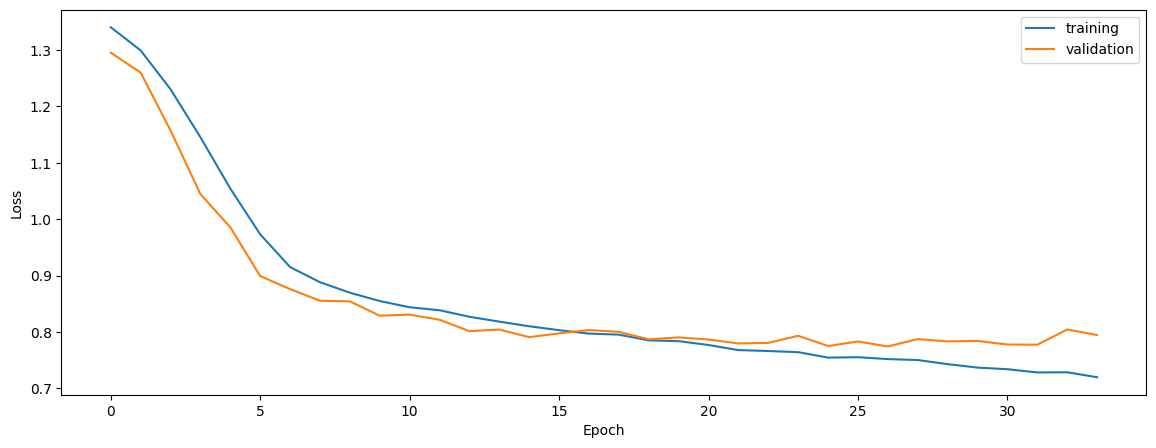

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.7054929013645117
0.6950460573432445
0.711512747042833


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.7054929013645117
0.6950460573432445
0.711512747042833


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.7030500144550448
0.6947443471175392
0.7116255661801711


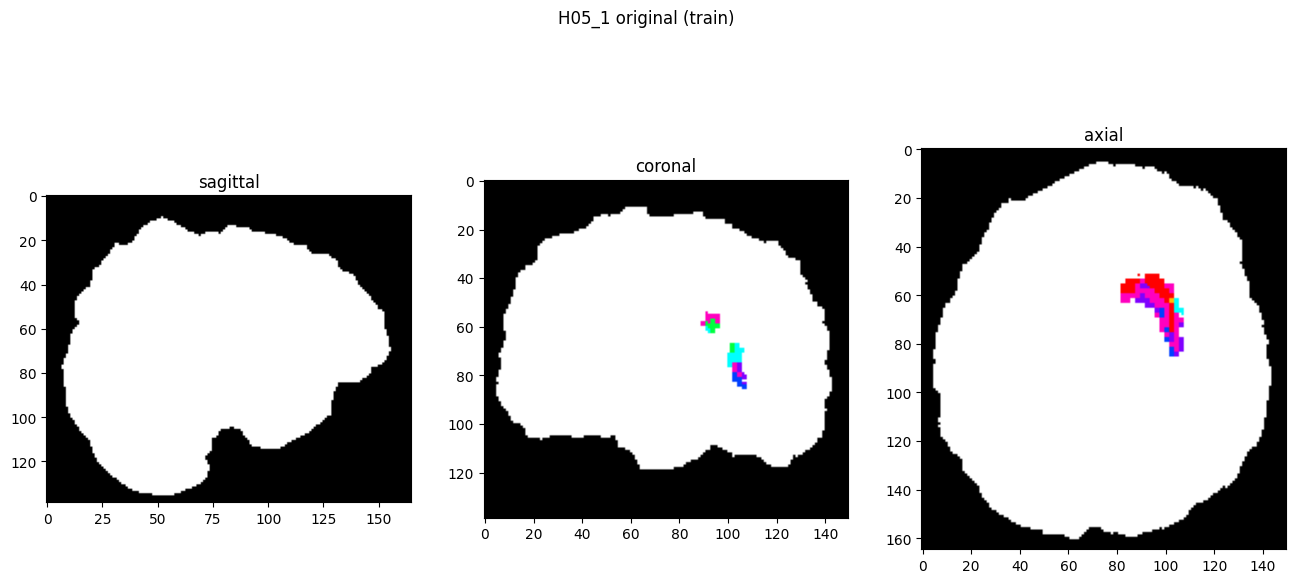

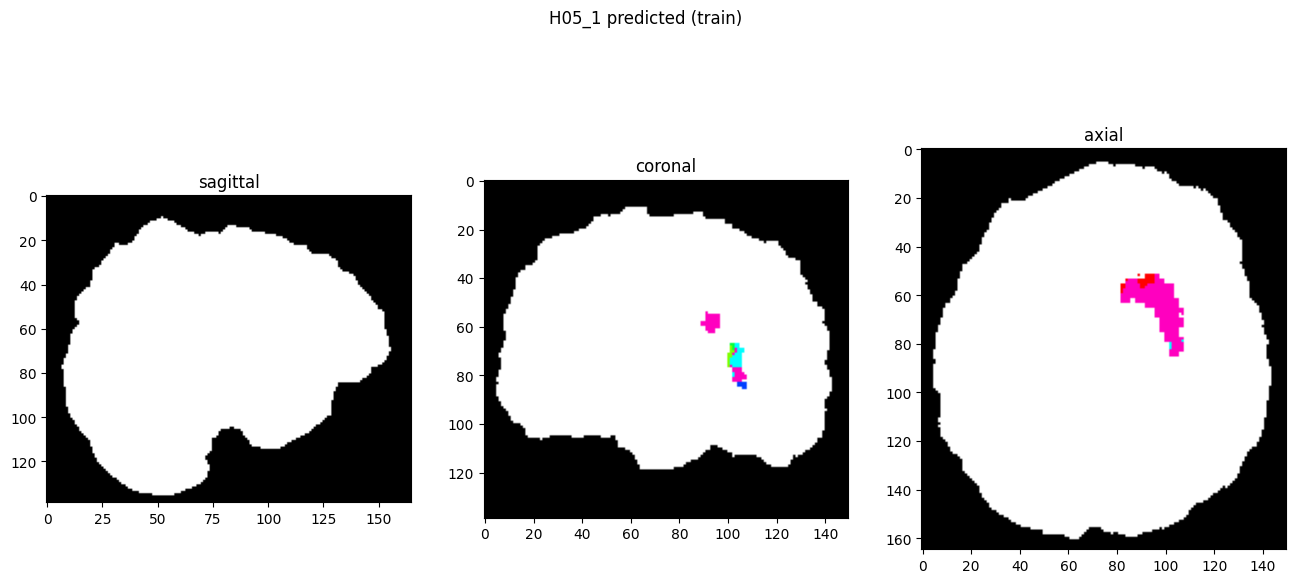

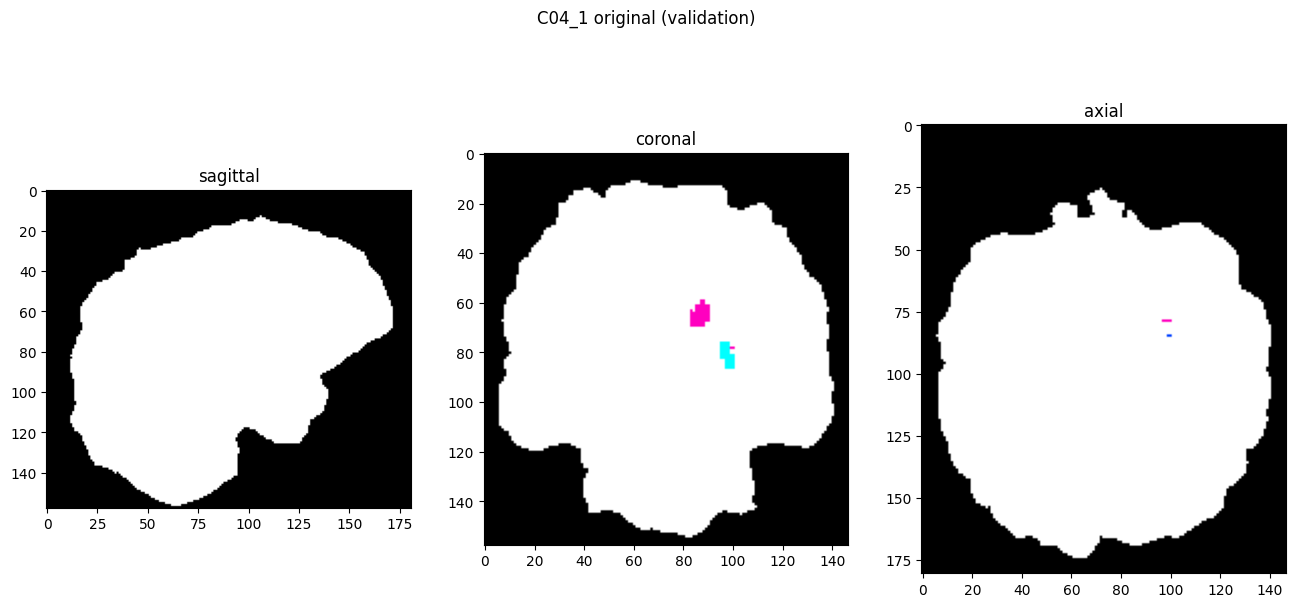

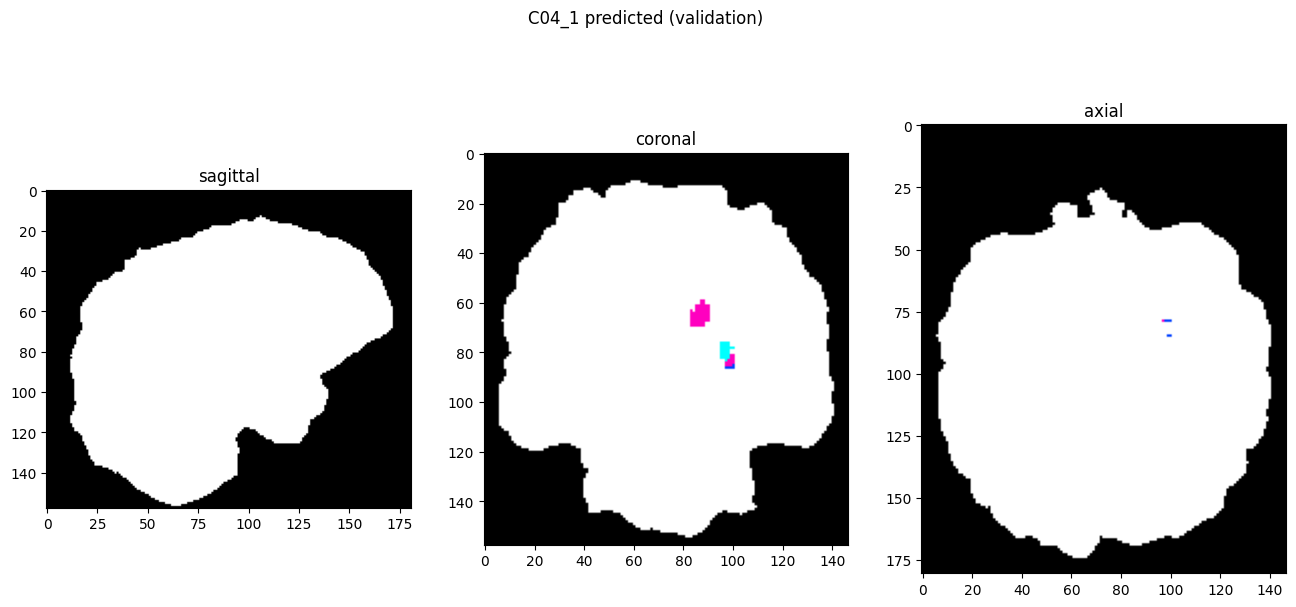

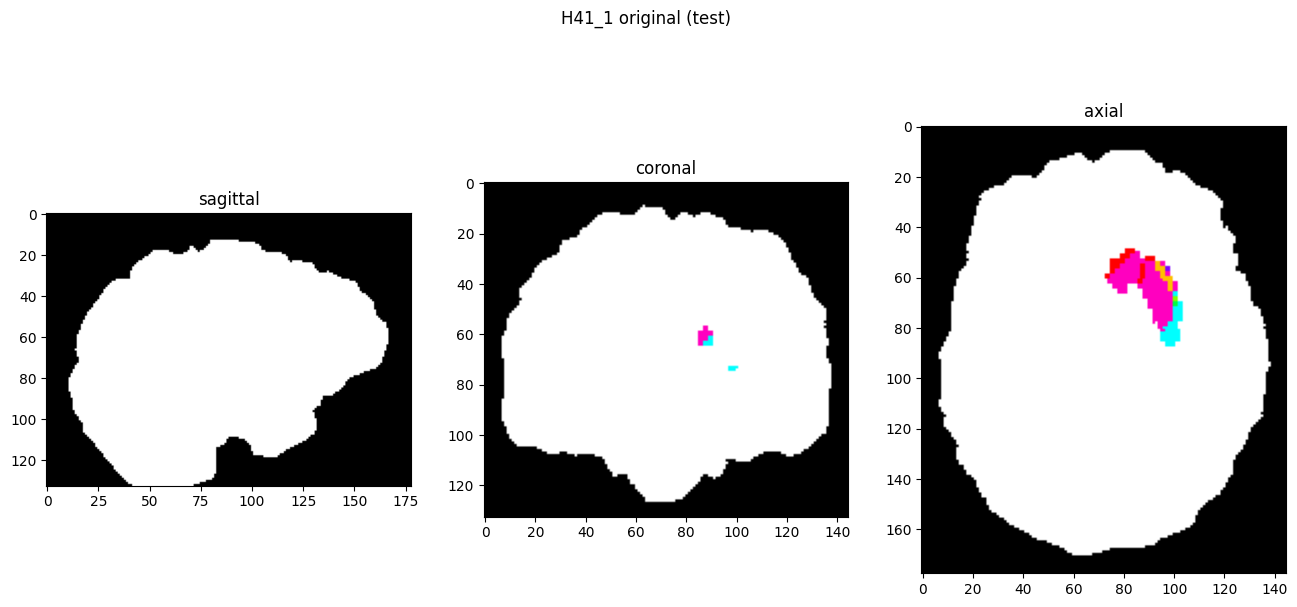

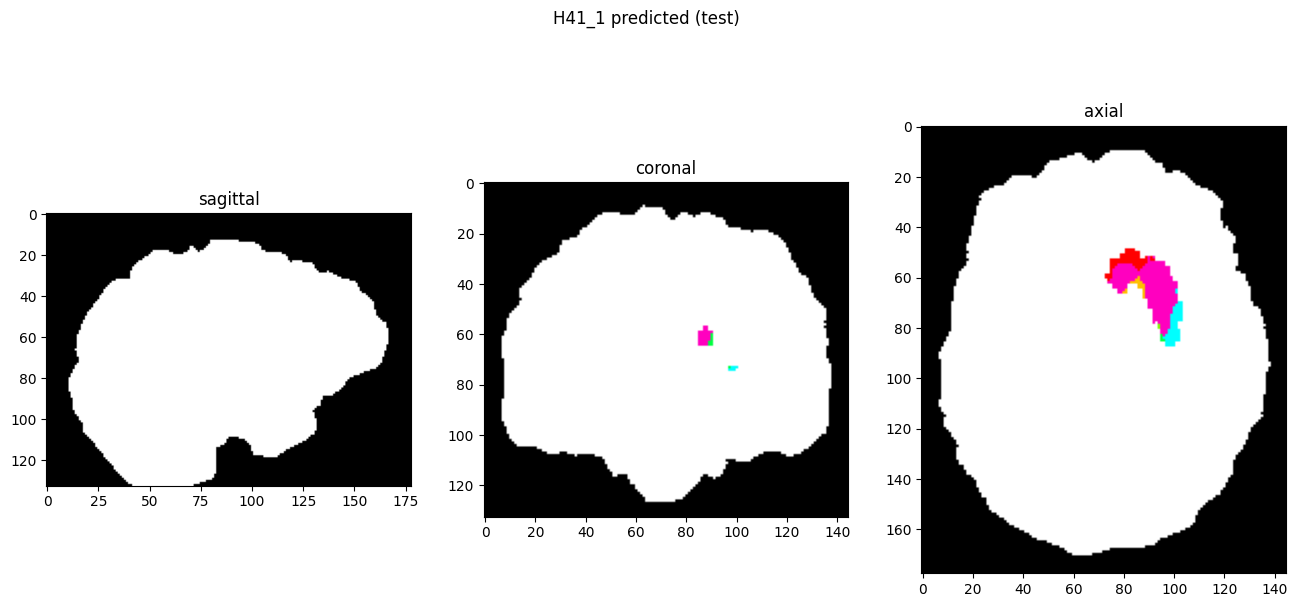

In [10]:
showResults(model, gen, threshold=0)